### OIBC : kontrabass
#### prototype

- 작성자 및 일자 : 임규연 (lky473736), 2024.11.08. ~ 2024.11.09.

<br>

- 2024 POSTECH X OIBC CHALLENGE (https://competition.postech.ac.kr/)
    - 참가자 : Kontrabass (임규연)

- 순서
    - (1) 각각의 df를 EDA 및 전처리 
    - (2) ts를 기준으로 모두 병합 및 결측치에 대한 처리 수행
    - (3) time-series data augmentation using jitter 
    - (4) modeling with no pre-trained model
        - (4-1) CNN-LSTM-dense
        - (4-2) U-net (GRU + CNN)
        - (4-3) transformer-encoder (LSTM + skip connection) 

<br>

- **addition library**
    - GPUtil
    - memory_profiler

In [211]:
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from scipy.stats import skew
import os
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import numpy as np
import scipy

In [212]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# cnn model vary kernel size
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from keras.utils import to_categorical

import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, LSTM, Conv1D, MaxPooling1D
from tensorflow.keras.layers import TimeDistributed, Conv1D, MaxPooling1D


In [213]:
# ignoring future warnings
import warnings
warnings.simplefilter('ignore')

In [214]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [215]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices() )


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5734523868000243517
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 40577794048
locality {
  bus_id: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 9507799128748897735
physical_device_desc: "device: 0, name: CUDA GPU, pci bus id: 0000:4c:00.0, compute capability: 8.0"
xla_global_id: 416903419
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 40577794048
locality {
  bus_id: 2
  numa_node: 1
  links {
    link {
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 16905512989444813134
physical_device_desc: "device: 1, name: CUDA GPU, pci bus id: 0000:c8:00.0, compute capability: 8.0"
xla_global_id: 2144165316
]


2024-11-09 07:09:48.783421: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1638] Created device /device:GPU:0 with 38698 MB memory:  -> device: 0, name: CUDA GPU, pci bus id: 0000:4c:00.0, compute capability: 8.0
2024-11-09 07:09:48.785439: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1638] Created device /device:GPU:1 with 38698 MB memory:  -> device: 1, name: CUDA GPU, pci bus id: 0000:c8:00.0, compute capability: 8.0


In [216]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [217]:
import psutil
import platform
import GPUtil

# System and CPU information
system = platform.system()
processor = platform.processor()

cpu_count = psutil.cpu_count(logical=True)
cpu_usage = psutil.cpu_percent(interval=1)
virtual_memory = psutil.virtual_memory()

print(f"System: {system}")
print(f"Processor: {processor}")
print(f"CPU Cores: {cpu_count}")
print(f"CPU Usage: {cpu_usage}%")
print(f"Total RAM: {virtual_memory.total / (1024**3):.2f} GB")
print(f"Available RAM: {virtual_memory.available / (1024**3):.2f} GB")
print(f"RAM Usage: {virtual_memory.percent}%")

# GPU information
gpus = GPUtil.getGPUs()
if gpus:
    for gpu in gpus:
        print(f"\nGPU {gpu.id}: {gpu.name}")
        print(f"  Load: {gpu.load * 100:.1f}%")
        print(f"  Free Memory: {gpu.memoryFree / 1024:.2f} GB")
        print(f"  Used Memory: {gpu.memoryUsed / 1024:.2f} GB")
        print(f"  Total Memory: {gpu.memoryTotal / 1024:.2f} GB")
        print(f"  Temperature: {gpu.temperature} °C")
else:
    print("\nNo GPU found.")


System: Linux
Processor: x86_64
CPU Cores: 16
CPU Usage: 8.8%
Total RAM: 1039.13 GB
Available RAM: 1002.24 GB
RAM Usage: 3.6%

GPU 0: CUDA GPU
  Load: 0.0%
  Free Memory: 1.76 GB
  Used Memory: 38.24 GB
  Total Memory: 40.00 GB
  Temperature: 29.0 °C

GPU 1: CUDA GPU
  Load: 0.0%
  Free Memory: 39.55 GB
  Used Memory: 0.45 GB
  Total Memory: 40.00 GB
  Temperature: 29.0 °C


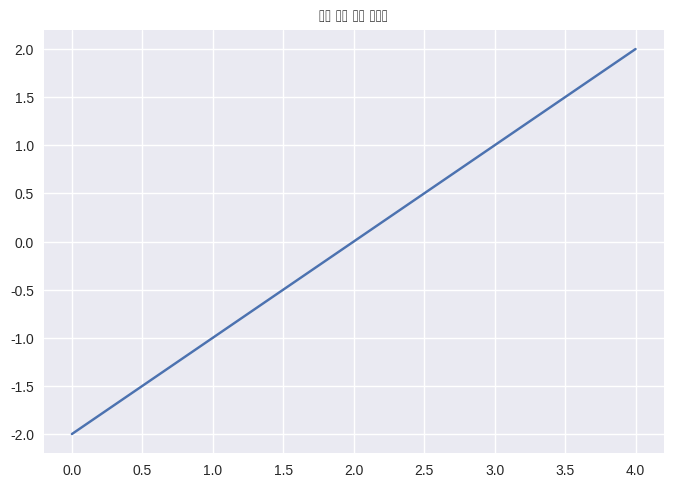

In [218]:
# 시스템 폰트 목록에서 한글 폰트 경로 찾기 & 한글 설정

# for font in fm.findSystemFonts():
#     print(fm.FontProperties(fname=font).get_name()) 

# plt.rc('font', family='NanumSquare') 
# plt.rcParams['axes.unicode_minus'] = False 

# import koreanize_matplotlib

# pd.Series([-2,-1,0,1,2]).plot(title="한글 정상 출력 테스트")
# plt.show()

In [219]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/dejavu: caching, new cache contents: 6 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 33 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/dejavu: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/nanum: sk

In [220]:
plt.rc('font', family='NanumBarunGothic') 
plt.rcParams['axes.unicode_minus'] =False

In [221]:
sns.set_theme(font="NanumBarunGothic", 
        rc={"axes.unicode_minus":False},
        style='darkgrid')

----

In [222]:
# 모든 파일 열어서 column 확인

import glob

path = '../../data/OIBC/'  
csv_files = glob.glob(os.path.join(path, "*.csv"))
df_list = [pd.read_csv(file) for file in csv_files]

# print (df_list)

for i, df in enumerate(df_list) :
    print (f"df {i+1} - {os.path.basename(csv_files[i])}")
    print (df.columns, "\n")

df 1 - 제주전력시장_시장전기가격_하루전가격.csv
Index(['ts', '하루전가격(원/kWh)'], dtype='object') 

df 2 - 기상실측데이터_2.csv
Index(['location', 'ts', 'cloud', 'temp', 'temp_max', 'temp_min', 'humidity',
       'ground_press', 'wind_speed', 'wind_dir', 'rain', 'snow'],
      dtype='object') 

df 3 - 기상예측데이터_1.csv
Index(['location', 'base_ts', 'ts', 'temp', 'real_feel_temp', 'wet_bulb_temp',
       'dew_point', 'wind_dir', 'wind_spd', 'wind_gust_spd', 'rel_hum', 'vis',
       'ceiling', 'uv_idx', 'precip_prob', 'rain_prob', 'snow_prob',
       'ice_prob', 'total_liq', 'rain', 'snow', 'ice', 'cld_cvr'],
      dtype='object') 

df 4 - 기상실측데이터_1.csv
Index(['location', 'ts', 'temp', 'real_feel_temp', 'real_feel_temp_shade',
       'rel_hum', 'dew_point', 'wind_dir', 'wind_spd', 'wind_gust_spd',
       'uv_idx', 'vis', 'cld_cvr', 'ceiling', 'pressure', 'appr_temp',
       'wind_chill_temp', 'wet_bulb_temp', 'precip_1h'],
      dtype='object') 

df 5 - 기상예측데

In [223]:
df_list[0].columns = ["ts", "Price Yesterday (kW)"]
df_list[5].columns = ['ts', 'Supply Capacity (kW)', 'Current Demand (kW)', 'Solar Power Generation (kW)', 
               'Wind Power Generation (kW)', 'Total Renewable Power Generation (kW)', 
               'Supply Reserve Capacity (kW)', 'Operational Reserve Capacity (kW)']

df_list[6].columns = ['ts', 'Real-time Temporary Price (KRW/kWh)', 'Real-time Confirmed Price (KRW/kWh)']


In [224]:
def statistics(df):
    print (df.head(10))
    stats = []
    for col in df.columns:
        stats.append((col, 
                      df[col].nunique(), 
                      df[col].isnull().sum(), 
                      df[col].isnull().sum() * 100 / df.shape[0], 
                      df[col].dtype))
    
    stats_df = pd.DataFrame(stats, columns=['특성', '특이치', '결측치', '결측치 비율', '데이터 형태'])
    stats_df.set_index('특성', inplace=True)
    
    stats_df.sort_values('결측치 비율', ascending=False, inplace=True)
    return stats_df

In [225]:
df_list[0]['ts'] = pd.to_numeric(df_list[0]['ts'], errors='coerce')
df_list[0]['ts'] = pd.to_datetime(df_list[0]['ts'], unit='s', errors='coerce')

statistics(df_list[0])

                   ts  Price Yesterday (kW)
0 2024-02-29 15:00:00                107.39
1 2024-02-29 16:00:00                107.39
2 2024-02-29 17:00:00                 95.30
3 2024-02-29 18:00:00                 87.89
4 2024-02-29 19:00:00                  0.00
5 2024-02-29 20:00:00                  0.00
6 2024-02-29 21:00:00                  0.00
7 2024-02-29 22:00:00                111.40
8 2024-02-29 23:00:00                  0.00
9 2024-03-01 00:00:00                111.67


,특이치,결측치,결측치 비율,데이터 형태
특성,,,,
ts,5665,0,0.0,datetime64[ns]
Price Yesterday (kW),3051,0,0.0,float64


In [226]:
df_list[1]['ts'] = pd.to_numeric(df_list[1]['ts'], errors='coerce')
df_list[1]['ts'] = pd.to_datetime(df_list[1]['ts'], unit='s', errors='coerce')
df_list[1]['location'] = df_list[1]['location'].astype('category')
df_list[1]['cloud'] = pd.to_numeric(df_list[1]['cloud'], errors='coerce')
df_list[1]['temp'] = pd.to_numeric(df_list[1]['temp'], errors='coerce')
df_list[1]['temp_max'] = pd.to_numeric(df_list[1]['temp_max'], errors='coerce')
df_list[1]['temp_min'] = pd.to_numeric(df_list[1]['temp_min'], errors='coerce')
df_list[1]['humidity'] = pd.to_numeric(df_list[1]['humidity'], errors='coerce')
df_list[1]['ground_press'] = pd.to_numeric(df_list[1]['ground_press'], errors='coerce')
df_list[1]['wind_speed'] = pd.to_numeric(df_list[1]['wind_speed'], errors='coerce')
df_list[1]['wind_dir'] = pd.to_numeric(df_list[1]['wind_dir'], errors='coerce')
df_list[1]['rain'] = pd.to_numeric(df_list[1]['rain'], errors='coerce')
df_list[1]['snow'] = pd.to_numeric(df_list[1]['snow'], errors='coerce')

statistics(df_list[1])

    location                  ts  cloud  temp  temp_max  temp_min  humidity  \
0  Gaigeturi 2024-02-29 15:00:56   80.0  8.03      8.03      8.03      73.0   
1  Gaigeturi 2024-02-29 15:31:04   75.0  8.03      8.03      8.03      66.0   
2  Gaigeturi 2024-02-29 16:00:54   85.0  7.75      7.75      7.75      71.0   
3  Gaigeturi 2024-02-29 16:31:16   75.0  8.03      8.03      8.03      66.0   
4  Gaigeturi 2024-02-29 17:00:58   88.0  7.11      7.11      7.11      66.0   
5  Gaigeturi 2024-02-29 17:31:18   75.0  7.03      7.03      7.03      61.0   
6  Gaigeturi 2024-02-29 18:00:42   87.0  6.79      6.79      6.79      65.0   
7  Gaigeturi 2024-02-29 18:31:29   40.0  6.03      6.03      6.03      61.0   
8  Gaigeturi 2024-02-29 19:00:57   33.0  6.19      6.19      6.19      67.0   
9  Gaigeturi 2024-02-29 19:30:44   40.0  5.03      5.03      5.03      65.0   

   ground_press  wind_speed  wind_dir  rain  snow  
0        1023.0       10.34     352.0  0.00   0.0  
1        1022.0        3.0

,특이치,결측치,결측치 비율,데이터 형태
특성,,,,
ts,27393,2,0.00588,datetime64[ns]
cloud,101,2,0.00588,float64
temp,2868,2,0.00588,float64
temp_max,2868,2,0.00588,float64
temp_min,2868,2,0.00588,float64
humidity,82,2,0.00588,float64
ground_press,34,2,0.00588,float64
wind_speed,1232,2,0.00588,float64
wind_dir,361,2,0.00588,float64


In [227]:
df_list[2]['location'] = df_list[2]['location'].astype('category')
df_list[2]['base_ts'] = pd.to_numeric(df_list[2]['base_ts'], errors='coerce')
df_list[2]['ts'] = pd.to_numeric(df_list[2]['ts'], errors='coerce')
df_list[2]['temp'] = pd.to_numeric(df_list[2]['temp'], errors='coerce')
df_list[2]['real_feel_temp'] = pd.to_numeric(df_list[2]['real_feel_temp'], errors='coerce')
df_list[2]['wet_bulb_temp'] = pd.to_numeric(df_list[2]['wet_bulb_temp'], errors='coerce')
df_list[2]['dew_point'] = pd.to_numeric(df_list[2]['dew_point'], errors='coerce')
df_list[2]['wind_dir'] = pd.to_numeric(df_list[2]['wind_dir'], errors='coerce')
df_list[2]['wind_spd'] = pd.to_numeric(df_list[2]['wind_spd'], errors='coerce')
df_list[2]['wind_gust_spd'] = pd.to_numeric(df_list[2]['wind_gust_spd'], errors='coerce')
df_list[2]['ice'] = pd.to_numeric(df_list[2]['ice'], errors='coerce')
df_list[2]['snow'] = pd.to_numeric(df_list[2]['snow'], errors='coerce')
df_list[2]['rain'] = pd.to_numeric(df_list[2]['rain'], errors='coerce')
df_list[2]['total_liq'] = pd.to_numeric(df_list[2]['total_liq'], errors='coerce')
df_list[2]['ice_prob'] = pd.to_numeric(df_list[2]['ice_prob'], errors='coerce')
df_list[2]['snow_prob'] = pd.to_numeric(df_list[2]['snow_prob'], errors='coerce')
df_list[2]['rain_prob'] = pd.to_numeric(df_list[2]['rain_prob'], errors='coerce')
df_list[2]['precip_prob'] = pd.to_numeric(df_list[2]['precip_prob'], errors='coerce')
df_list[2]['uv_idx'] = pd.to_numeric(df_list[2]['uv_idx'], errors='coerce')
df_list[2]['vis'] = pd.to_numeric(df_list[2]['vis'], errors='coerce')
df_list[2]['rel_hum'] = pd.to_numeric(df_list[2]['rel_hum'], errors='coerce')
df_list[2]['cld_cvr'] = pd.to_numeric(df_list[2]['cld_cvr'], errors='coerce')
df_list[2]['base_ts'] = pd.to_datetime(df_list[2]['base_ts'], unit='s', errors='coerce')
df_list[2]['ts'] = pd.to_datetime(df_list[2]['ts'], unit='s', errors='coerce')


statistics(df_list[2])

   location             base_ts                  ts     temp  real_feel_temp  \
0  Ilgwa-ri 2024-03-01 02:00:00 2024-03-01 15:00:00  3.33333        -3.88889   
1  Ilgwa-ri 2024-03-01 02:00:00 2024-03-01 16:00:00  3.33333        -3.88889   
2  Ilgwa-ri 2024-03-01 02:00:00 2024-03-01 17:00:00  3.33333        -4.44444   
3  Ilgwa-ri 2024-03-01 02:00:00 2024-03-01 18:00:00  2.77778        -4.44444   
4  Ilgwa-ri 2024-03-01 02:00:00 2024-03-01 19:00:00  3.33333        -4.44444   
5  Ilgwa-ri 2024-03-01 02:00:00 2024-03-01 20:00:00  3.88889        -3.88889   
6  Ilgwa-ri 2024-03-01 02:00:00 2024-03-01 21:00:00  3.88889        -3.88889   
7  Ilgwa-ri 2024-03-01 02:00:00 2024-03-01 22:00:00  3.88889        -3.88889   
8  Ilgwa-ri 2024-03-01 02:00:00 2024-03-01 23:00:00  3.88889        -2.77778   
9  Ilgwa-ri 2024-03-01 02:00:00 2024-03-02 00:00:00  4.44444        -1.11111   

   wet_bulb_temp  dew_point  wind_dir  wind_spd  wind_gust_spd  ...  uv_idx  \
0        1.11111   -2.77778     343.0   

,특이치,결측치,결측치 비율,데이터 형태
특성,,,,
vis,331,8,0.015,float64
base_ts,237,8,0.015,datetime64[ns]
ice,1,8,0.015,float64
snow,1,8,0.015,float64
rain,93,8,0.015,float64
total_liq,93,8,0.015,float64
ice_prob,3,8,0.015,float64
snow_prob,7,8,0.015,float64
rain_prob,90,8,0.015,float64


In [228]:
df_list[3]['location'] = df_list[3]['location'].astype('category')
df_list[3]['ts'] = pd.to_numeric(df_list[3]['ts'], errors='coerce')
df_list[3]['temp'] = pd.to_numeric(df_list[3]['temp'], errors='coerce')
df_list[3]['real_feel_temp'] = pd.to_numeric(df_list[3]['real_feel_temp'], errors='coerce')
df_list[3]['real_feel_temp_shade'] = pd.to_numeric(df_list[3]['real_feel_temp_shade'], errors='coerce')
df_list[3]['rel_hum'] = pd.to_numeric(df_list[3]['rel_hum'], errors='coerce')
df_list[3]['dew_point'] = pd.to_numeric(df_list[3]['dew_point'], errors='coerce')
df_list[3]['wind_dir'] = pd.to_numeric(df_list[3]['wind_dir'], errors='coerce')
df_list[3]['wind_spd'] = pd.to_numeric(df_list[3]['wind_spd'], errors='coerce')
df_list[3]['wind_gust_spd'] = pd.to_numeric(df_list[3]['wind_gust_spd'], errors='coerce')
df_list[3]['uv_idx'] = pd.to_numeric(df_list[3]['uv_idx'], errors='coerce')
df_list[3]['vis'] = pd.to_numeric(df_list[3]['vis'], errors='coerce')
df_list[3]['cld_cvr'] = pd.to_numeric(df_list[3]['cld_cvr'], errors='coerce')
df_list[3]['ceiling'] = pd.to_numeric(df_list[3]['ceiling'], errors='coerce')
df_list[3]['pressure'] = pd.to_numeric(df_list[3]['pressure'], errors='coerce')
df_list[3]['appr_temp'] = pd.to_numeric(df_list[3]['appr_temp'], errors='coerce')
df_list[3]['wind_chill_temp'] = pd.to_numeric(df_list[3]['wind_chill_temp'], errors='coerce')
df_list[3]['wet_bulb_temp'] = pd.to_numeric(df_list[3]['wet_bulb_temp'], errors='coerce')
df_list[3]['precip_1h'] = pd.to_numeric(df_list[3]['precip_1h'], errors='coerce')
df_list[3]['ts'] = pd.to_datetime(df_list[3]['ts'], unit='s', errors='coerce')


statistics(df_list[3])

   location                  ts  temp  real_feel_temp  real_feel_temp_shade  \
0  Ilgwa-ri 2024-02-29 15:57:00   6.9             2.4                   2.4   
1  Ilgwa-ri 2024-02-29 16:03:00   7.1             2.7                   2.7   
2  Ilgwa-ri 2024-02-29 17:02:00   6.3             0.9                   0.9   
3  Ilgwa-ri 2024-02-29 17:57:00   5.6            -1.7                  -1.7   
4  Ilgwa-ri 2024-02-29 18:04:00   5.6            -1.7                  -1.7   
5  Ilgwa-ri 2024-02-29 18:57:00   5.1            -1.0                  -1.0   
6  Ilgwa-ri 2024-02-29 19:57:00   4.7            -0.7                  -0.7   
7  Ilgwa-ri 2024-02-29 20:57:00   4.2            -2.6                  -2.6   
8  Ilgwa-ri 2024-02-29 22:02:00   3.6            -4.1                  -4.1   
9  Ilgwa-ri 2024-02-29 22:57:00   3.4            -4.5                  -4.5   

   rel_hum  dew_point  wind_dir  wind_spd  wind_gust_spd  uv_idx   vis  \
0     69.0        1.5     338.0      18.7           37.7

,특이치,결측치,결측치 비율,데이터 형태
특성,,,,
wind_gust_spd,829,8,0.012371,float64
uv_idx,13,8,0.012371,float64
wet_bulb_temp,333,8,0.012371,float64
wind_chill_temp,81,8,0.012371,float64
appr_temp,87,8,0.012371,float64
pressure,309,8,0.012371,float64
ceiling,447,8,0.012371,float64
cld_cvr,101,8,0.012371,float64
vis,46,8,0.012371,float64


In [229]:
df_list[4]['location'] = df_list[4]['location'].astype('category')
df_list[4]['base_ts'] = pd.to_numeric(df_list[4]['base_ts'], errors='coerce')
df_list[4]['ts'] = pd.to_numeric(df_list[4]['ts'], errors='coerce')
df_list[4]['cloud'] = pd.to_numeric(df_list[4]['cloud'], errors='coerce')
df_list[4]['temp'] = pd.to_numeric(df_list[4]['temp'], errors='coerce')
df_list[4]['temp_max'] = pd.to_numeric(df_list[4]['temp_max'], errors='coerce')
df_list[4]['temp_min'] = pd.to_numeric(df_list[4]['temp_min'], errors='coerce')
df_list[4]['humidity'] = pd.to_numeric(df_list[4]['humidity'], errors='coerce')
df_list[4]['ground_press'] = pd.to_numeric(df_list[4]['ground_press'], errors='coerce')
df_list[4]['wind_speed'] = pd.to_numeric(df_list[4]['wind_speed'], errors='coerce')
df_list[4]['wind_dir'] = pd.to_numeric(df_list[4]['wind_dir'], errors='coerce')
df_list[4]['rain'] = pd.to_numeric(df_list[4]['rain'], errors='coerce')
df_list[4]['snow'] = pd.to_numeric(df_list[4]['snow'], errors='coerce')
df_list[4]['ts'] = pd.to_datetime(df_list[4]['ts'], unit='s', errors='coerce')
df_list[4]['base_ts'] = pd.to_datetime(df_list[4]['base_ts'], unit='s', errors='coerce')


statistics(df_list[4])

    location             base_ts                  ts  cloud  temp  temp_max  \
0  Gaigeturi 2024-03-01 02:00:00 2024-03-01 15:00:00  100.0  3.23      3.23   
1  Gaigeturi 2024-03-01 02:00:00 2024-03-01 16:00:00  100.0  3.30      3.30   
2  Gaigeturi 2024-03-01 02:00:00 2024-03-01 17:00:00  100.0  3.35      3.35   
3  Gaigeturi 2024-03-01 02:00:00 2024-03-01 18:00:00  100.0  3.35      3.35   
4  Gaigeturi 2024-03-01 02:00:00 2024-03-01 19:00:00   99.0  3.43      3.43   
5  Gaigeturi 2024-03-01 02:00:00 2024-03-01 20:00:00   99.0  3.62      3.62   
6  Gaigeturi 2024-03-01 02:00:00 2024-03-01 21:00:00   99.0  3.73      3.73   
7  Gaigeturi 2024-03-01 02:00:00 2024-03-01 22:00:00   99.0  3.76      3.76   
8  Gaigeturi 2024-03-01 02:00:00 2024-03-01 23:00:00   98.0  3.90      3.90   
9  Gaigeturi 2024-03-01 02:00:00 2024-03-02 00:00:00   96.0  4.23      4.23   

   temp_min  humidity  ground_press  wind_speed  wind_dir  rain  snow  
0      3.23      59.0        1027.0        9.59     337.0 

,특이치,결측치,결측치 비율,데이터 형태
특성,,,,
base_ts,237,2,0.01125,datetime64[ns]
ts,5689,2,0.01125,datetime64[ns]
cloud,101,2,0.01125,float64
temp,2826,2,0.01125,float64
temp_max,2826,2,0.01125,float64
temp_min,2826,2,0.01125,float64
humidity,70,2,0.01125,float64
ground_press,33,2,0.01125,float64
wind_speed,1238,2,0.01125,float64


In [230]:
df_list[5]['ts'] = pd.to_datetime(df_list[5]['ts'], unit='s')
statistics(df_list[5])

                   ts  Supply Capacity (kW)  Current Demand (kW)  \
0 2023-12-31 15:00:00             1298000.0             769000.0   
1 2023-12-31 15:05:00             1299000.0             761000.0   
2 2023-12-31 15:10:00             1290000.0             755000.0   
3 2023-12-31 15:15:00             1277000.0             756000.0   
4 2023-12-31 15:20:00             1269000.0             753000.0   
5 2023-12-31 15:25:00             1277000.0             751000.0   
6 2023-12-31 15:30:00             1259000.0             745000.0   
7 2023-12-31 15:35:00             1255000.0             748000.0   
8 2023-12-31 15:40:00             1261000.0             745000.0   
9 2023-12-31 15:45:00             1257000.0             736000.0   

   Solar Power Generation (kW)  Wind Power Generation (kW)  \
0                          0.0                    125426.0   
1                          0.0                    130393.0   
2                          0.0                    120691.0   
3  

,특이치,결측치,결측치 비율,데이터 형태
특성,,,,
ts,84080,0,0.0,datetime64[ns]
Supply Capacity (kW),800,0,0.0,float64
Current Demand (kW),787,0,0.0,float64
Solar Power Generation (kW),50665,0,0.0,float64
Wind Power Generation (kW),80030,0,0.0,float64
Total Renewable Power Generation (kW),79471,0,0.0,float64
Supply Reserve Capacity (kW),995,0,0.0,float64
Operational Reserve Capacity (kW),688,0,0.0,float64


In [231]:
df_list[6]['ts'] = pd.to_datetime(df_list[6]['ts'], unit='s')
statistics(df_list[6])

                   ts  Real-time Temporary Price (KRW/kWh)  \
0 2024-02-29 15:00:00                                95.30   
1 2024-02-29 15:15:00                               170.95   
2 2024-02-29 15:30:00                               170.42   
3 2024-02-29 15:45:00                               107.39   
4 2024-02-29 16:00:00                               107.39   
5 2024-02-29 16:15:00                                95.30   
6 2024-02-29 16:30:00                                95.30   
7 2024-02-29 16:45:00                                95.30   
8 2024-02-29 17:00:00                                95.30   
9 2024-02-29 17:15:00                                87.89   

   Real-time Confirmed Price (KRW/kWh)  
0                                95.30  
1                               170.95  
2                               170.42  
3                               107.39  
4                               107.39  
5                                95.30  
6                             

,특이치,결측치,결측치 비율,데이터 형태
특성,,,,
ts,22559,0,0.0,datetime64[ns]
Real-time Temporary Price (KRW/kWh),4105,0,0.0,float64
Real-time Confirmed Price (KRW/kWh),3514,0,0.0,float64


In [232]:
# 모든 frame의 결측치를 그 열의 이전 records와 다음 records의 평균으로 구성

for df in df_list:
    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]) : # 열의 dtype이 숫자일 때만
            df[col] = df[col].fillna((df[col].shift(1) + df[col].shift(-1)) / 2)
        elif pd.api.types.is_datetime64_any_dtype(df[col]) :
            df[col] = df[col].fillna(df[col].shift(1))

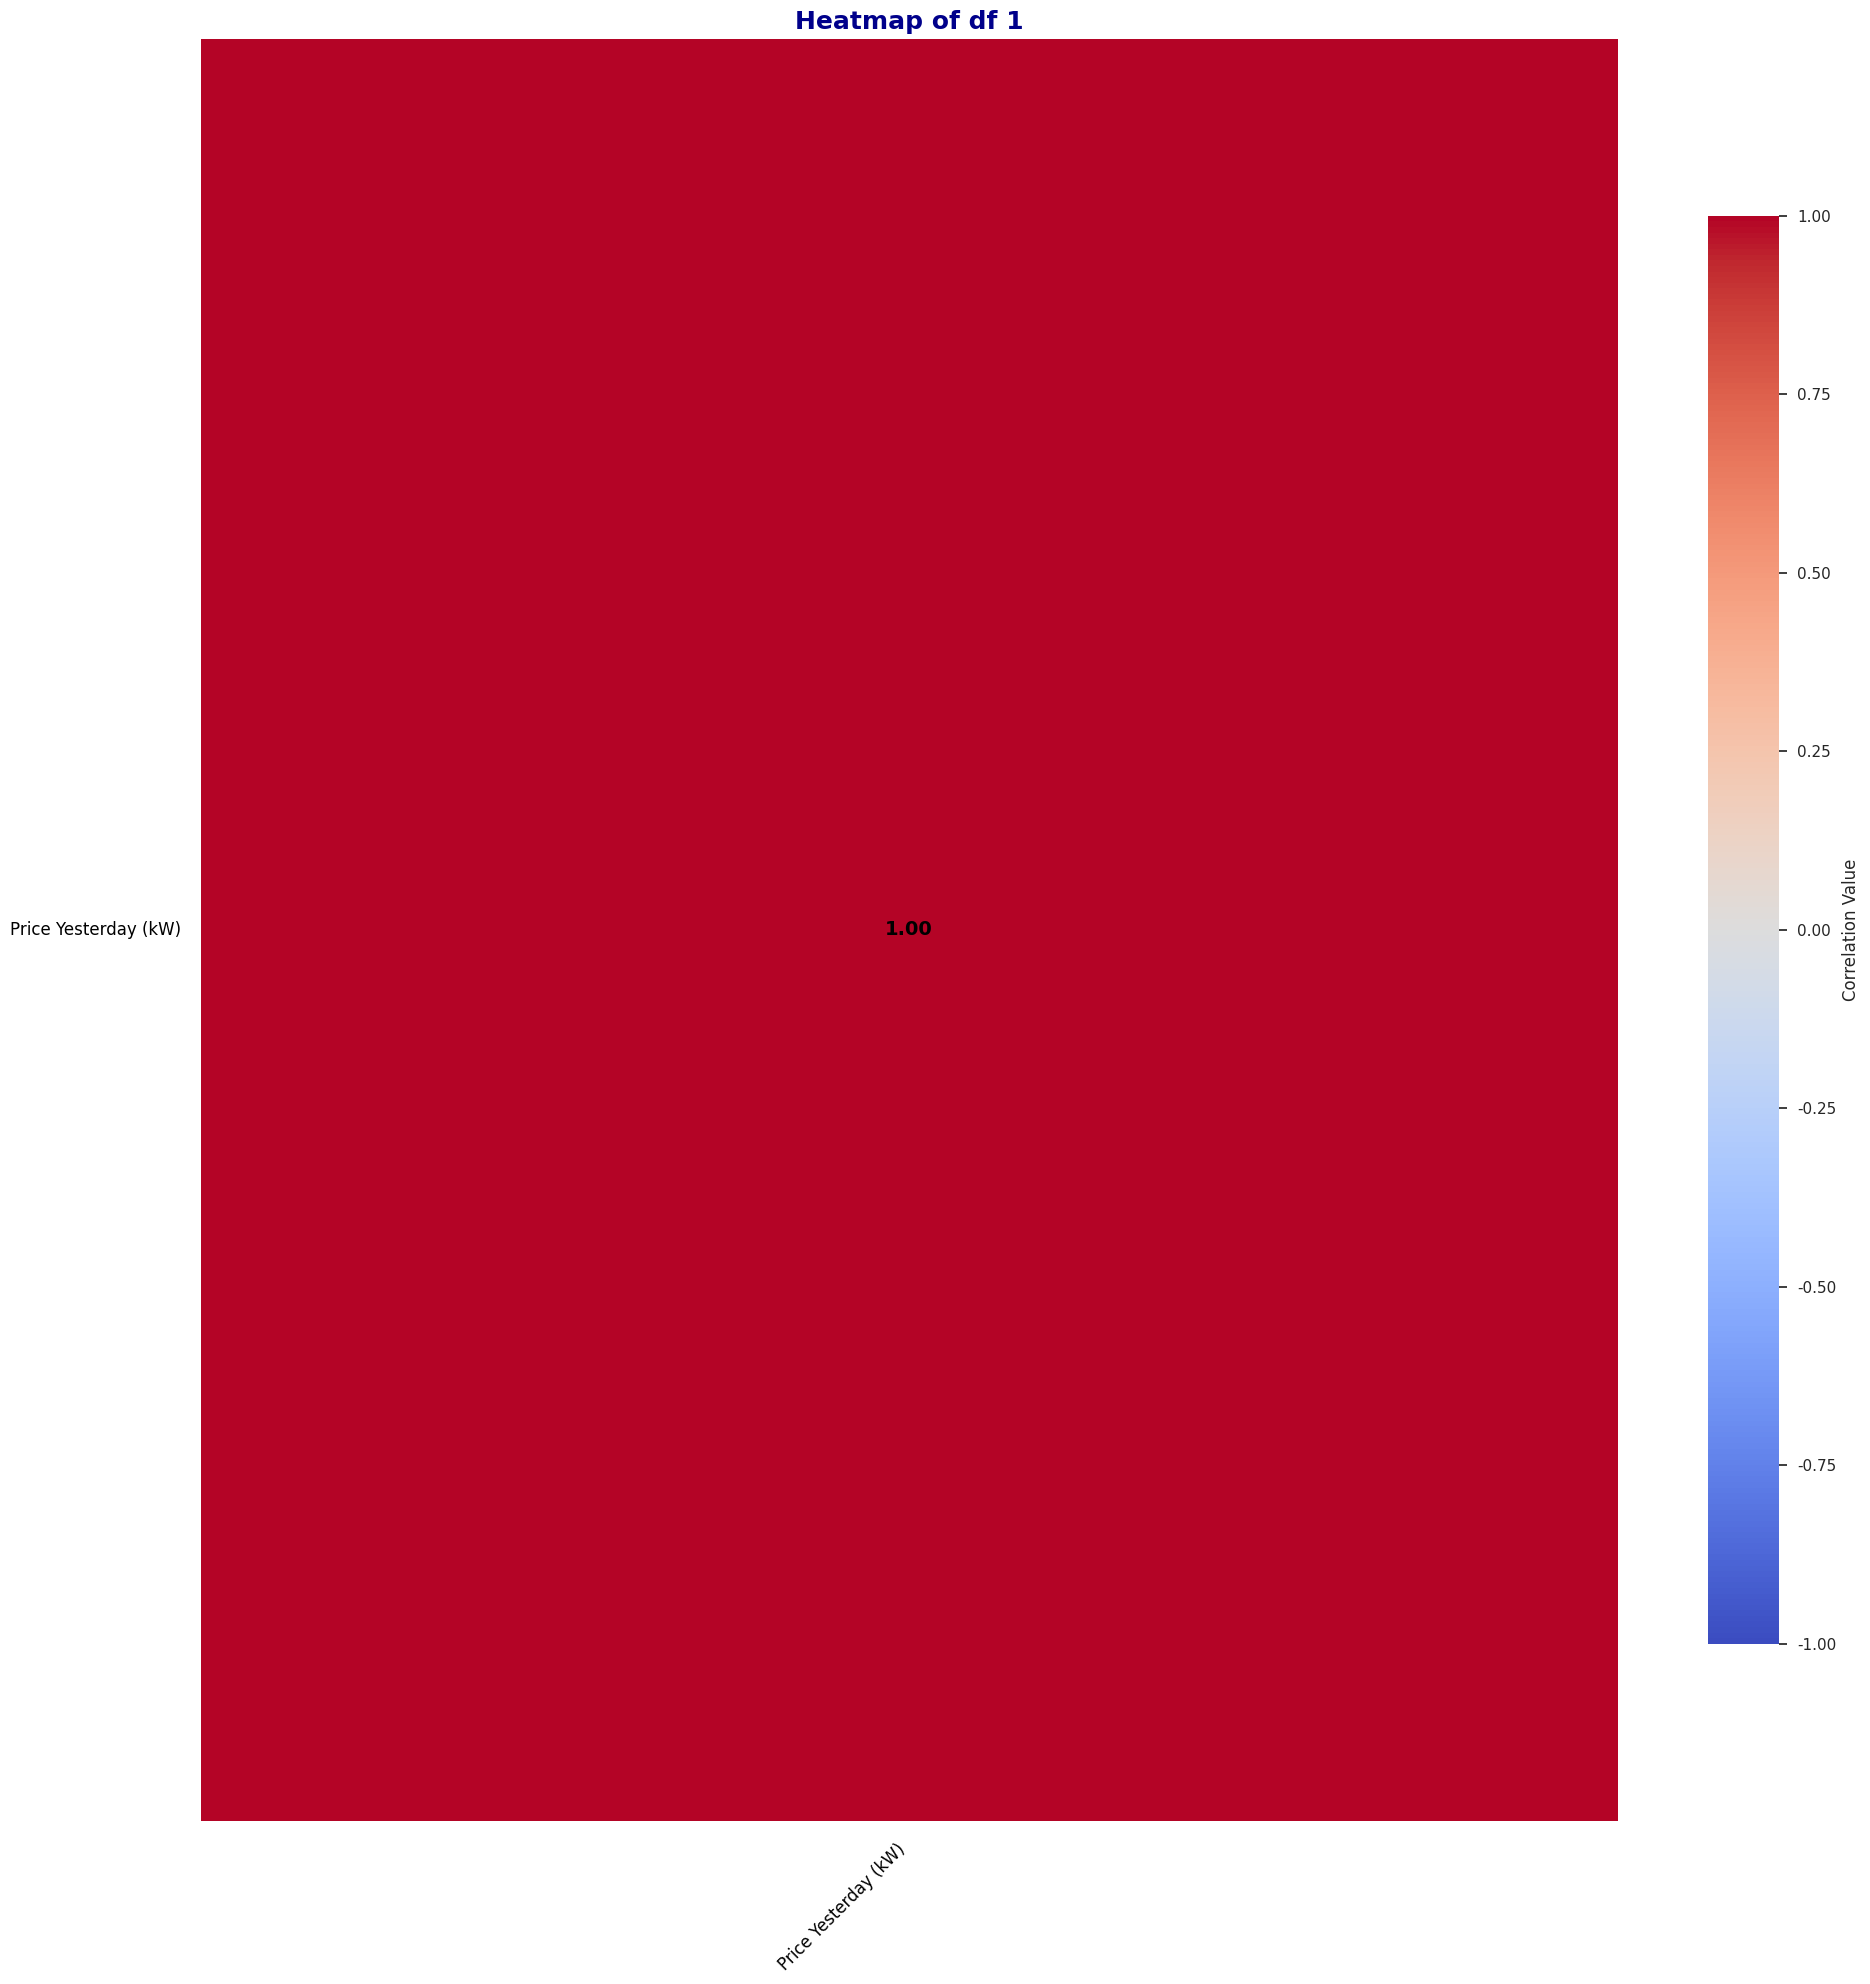

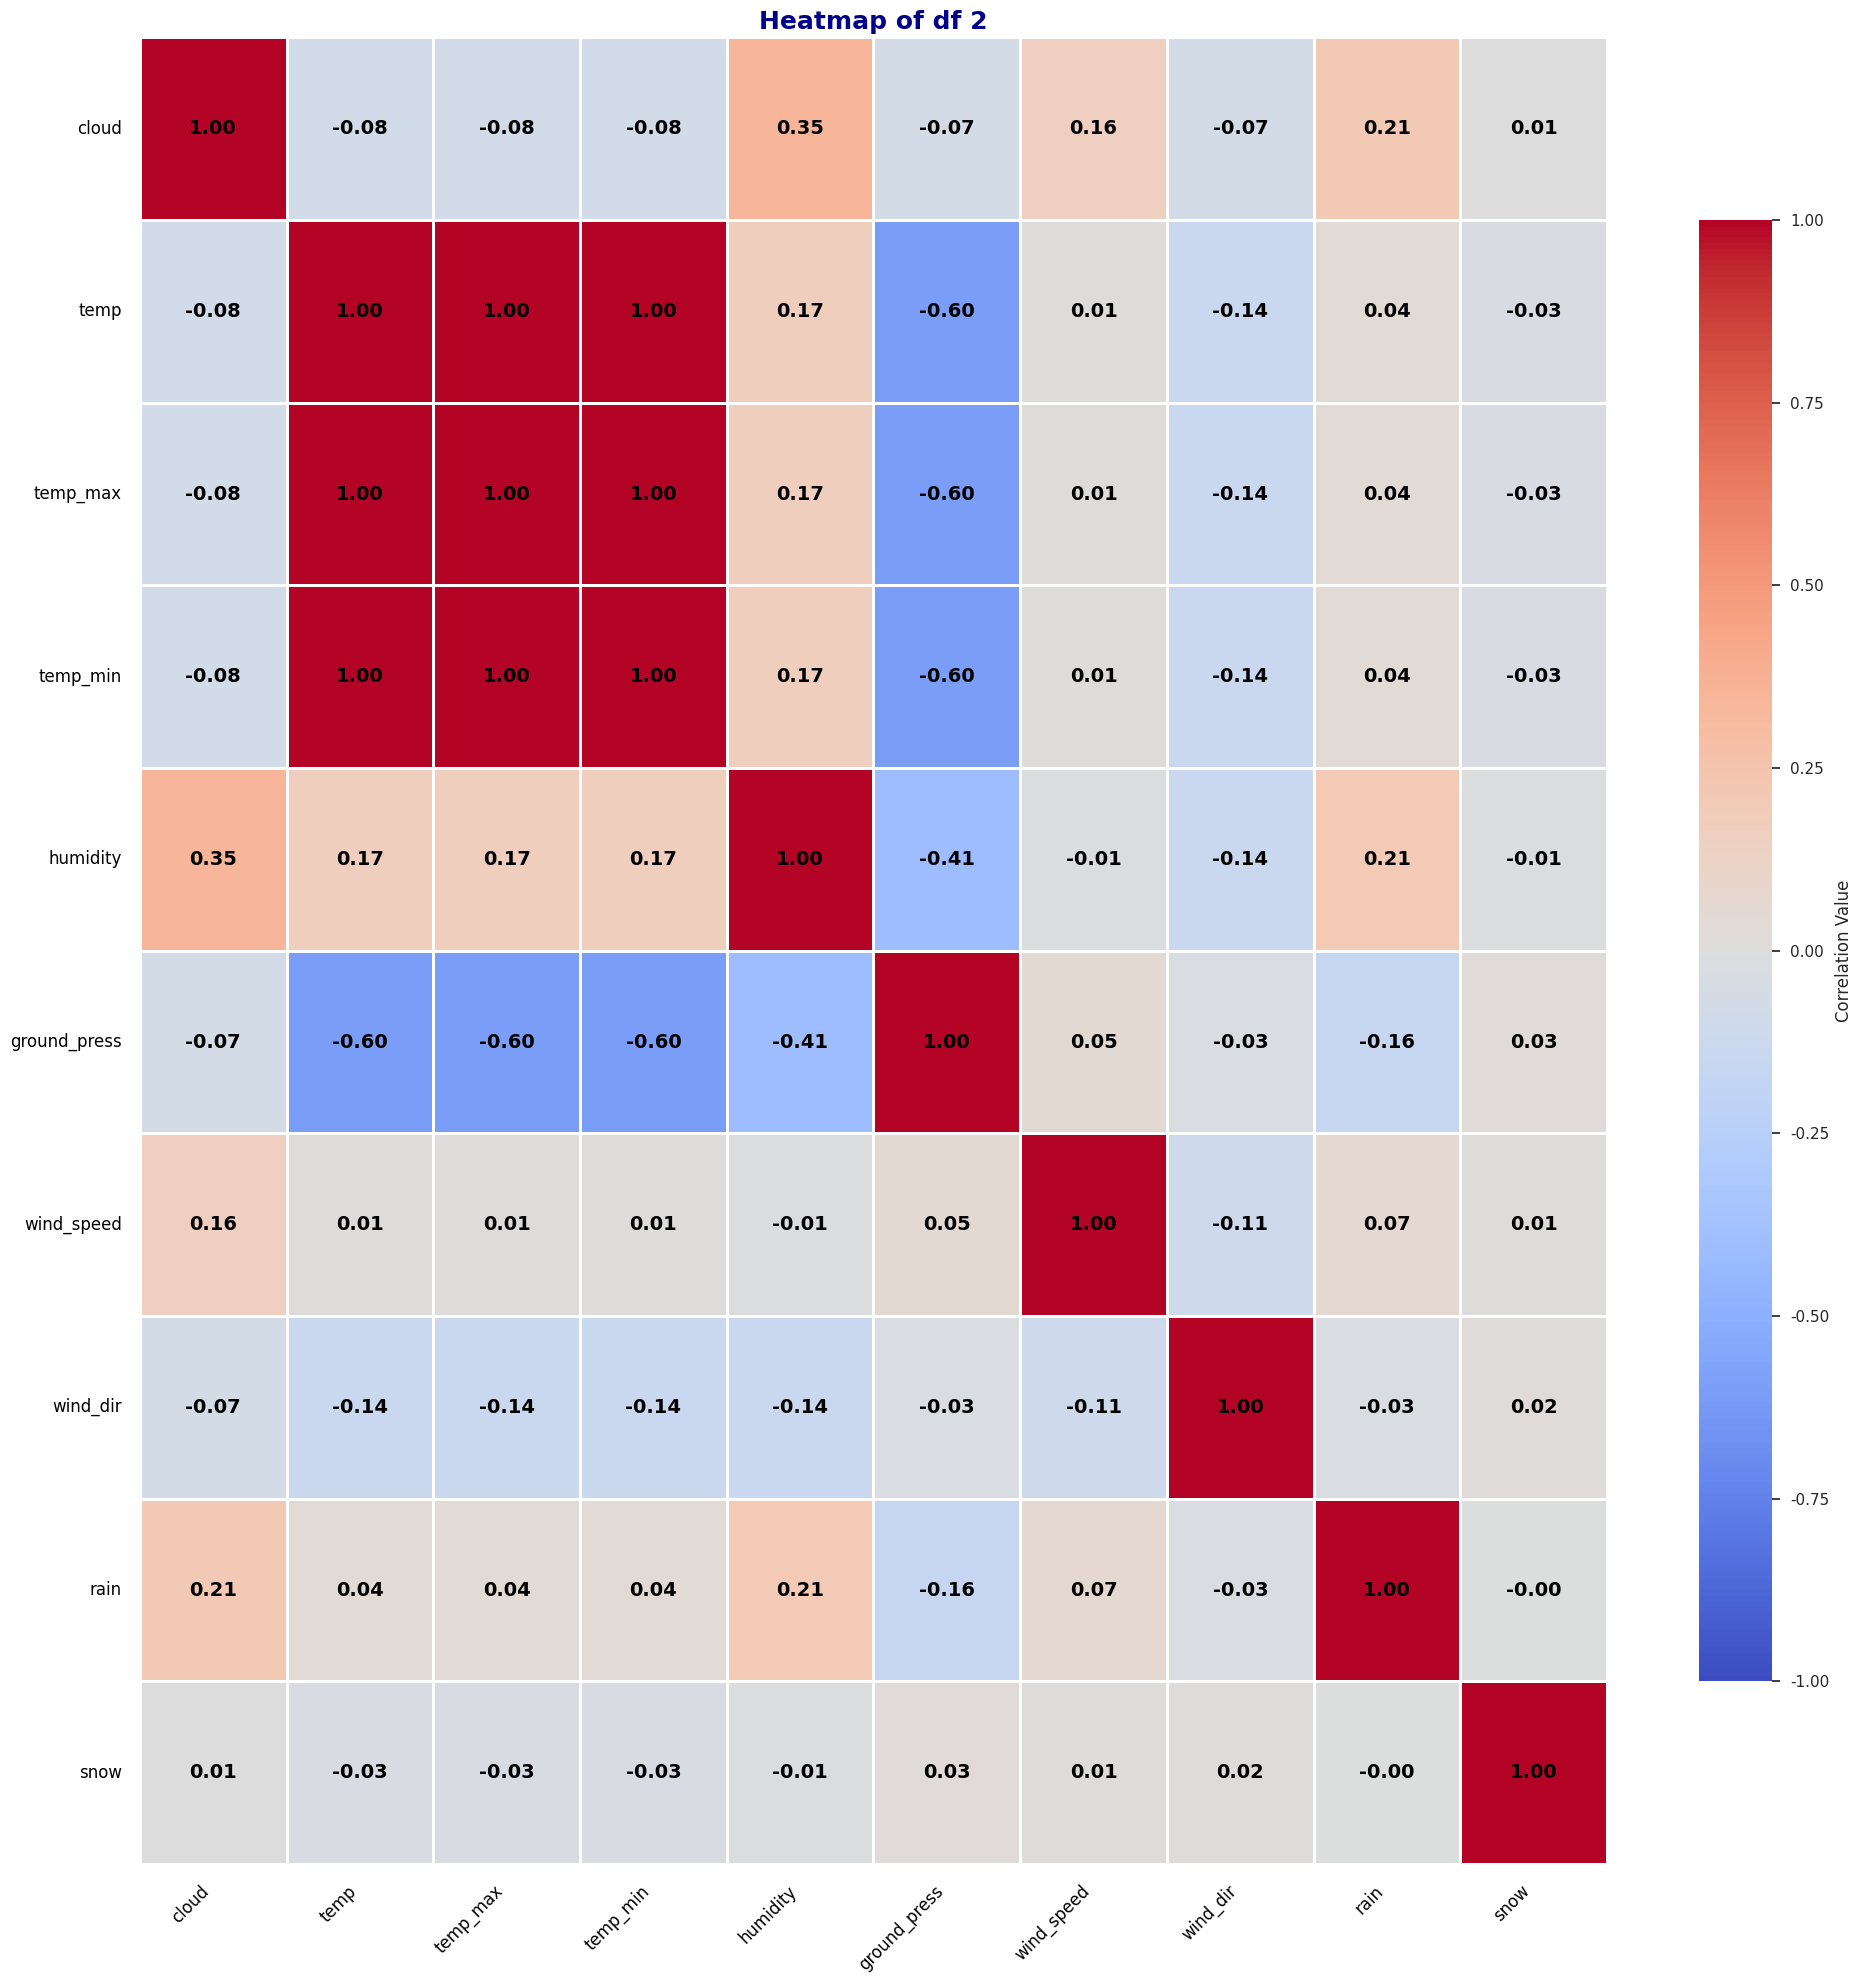

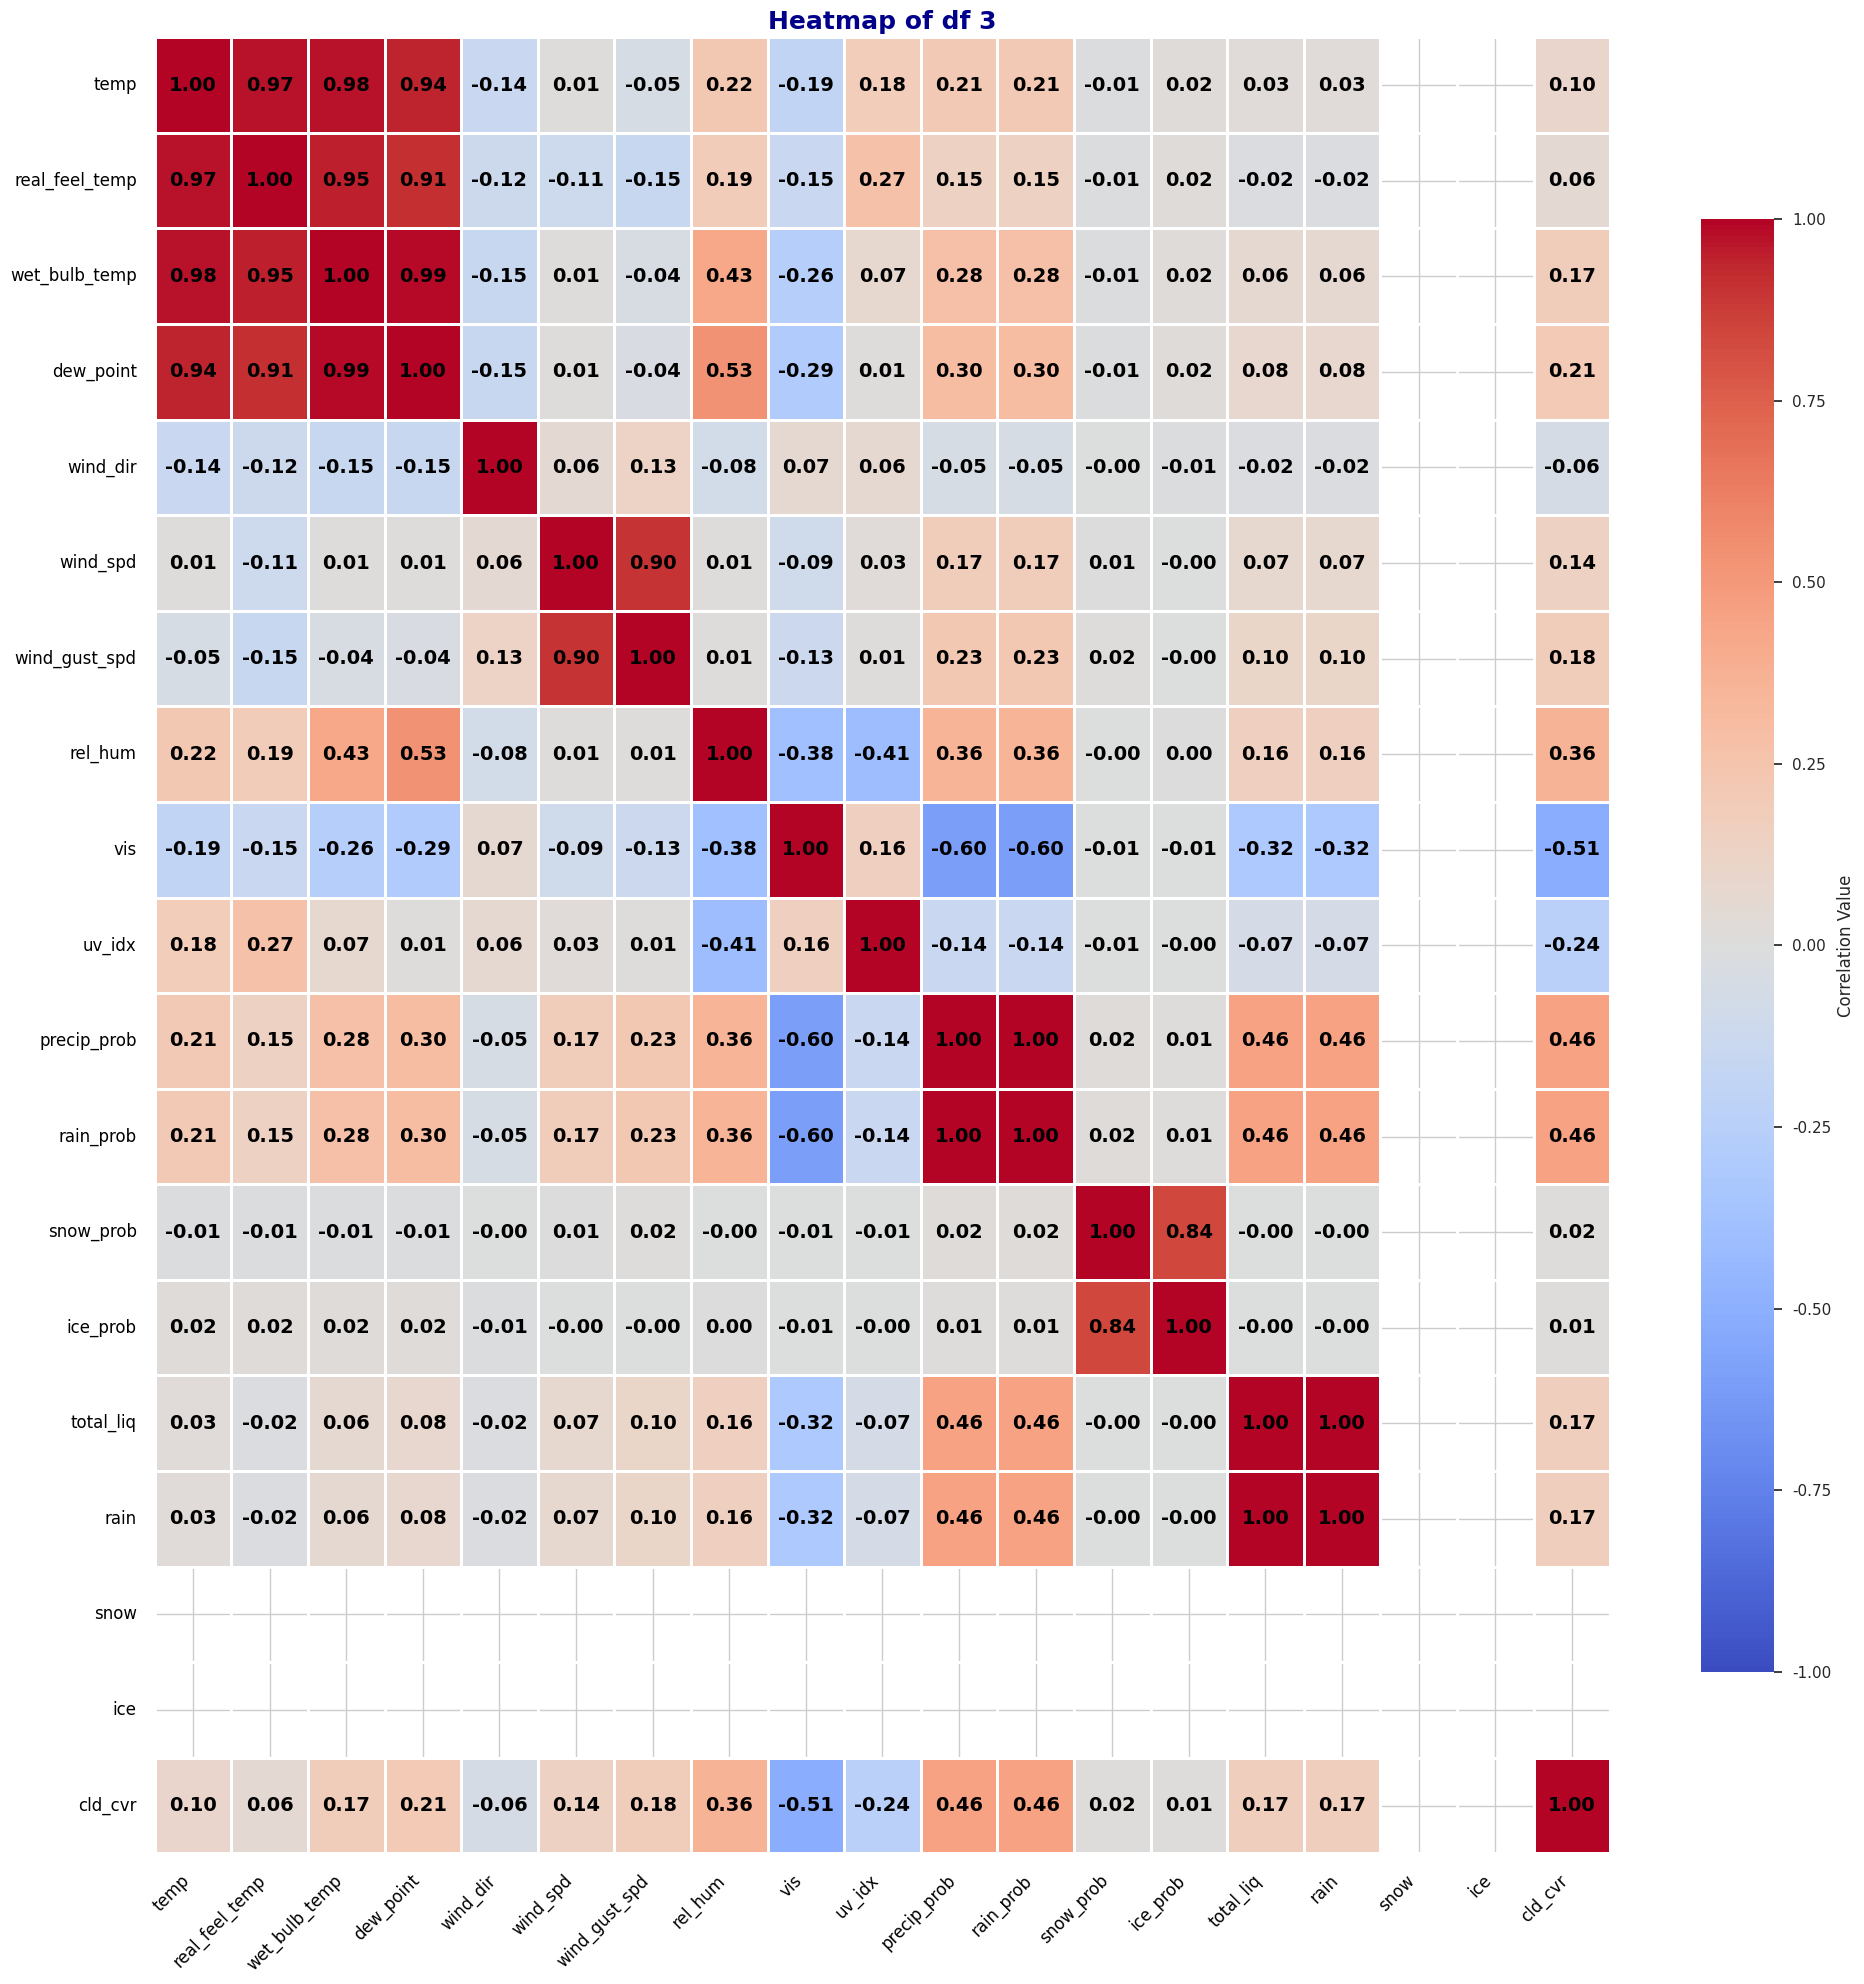

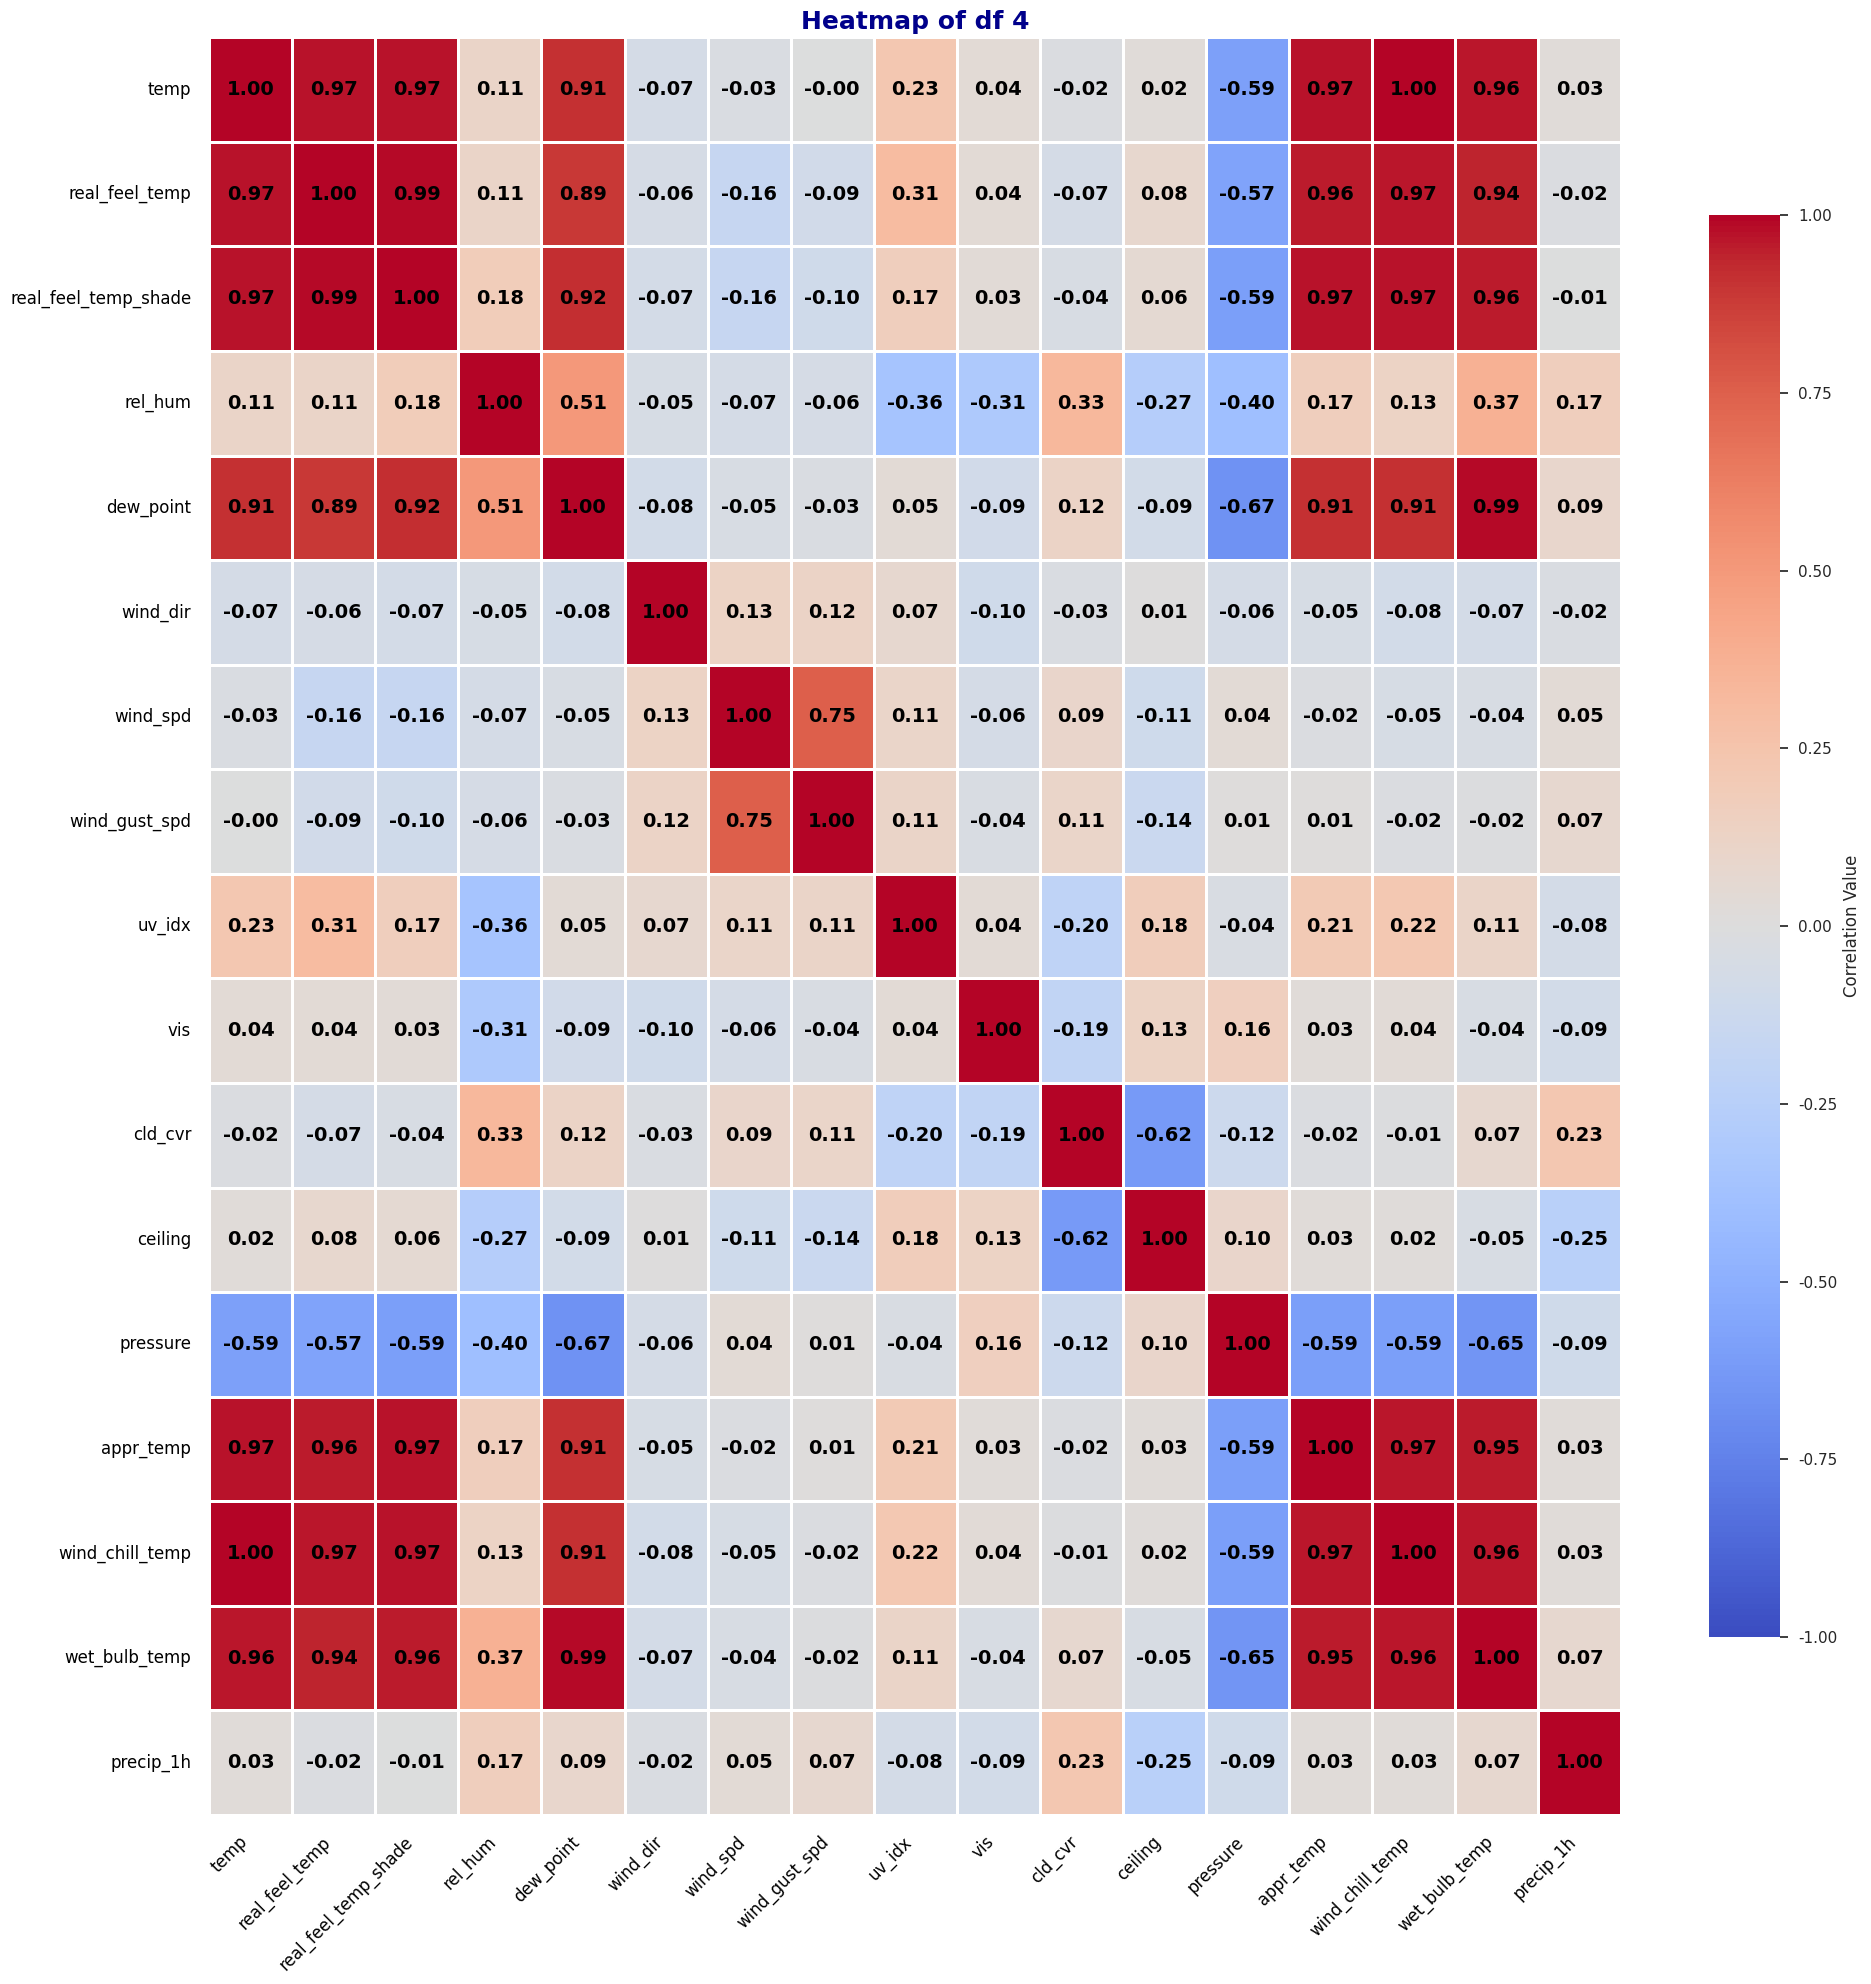

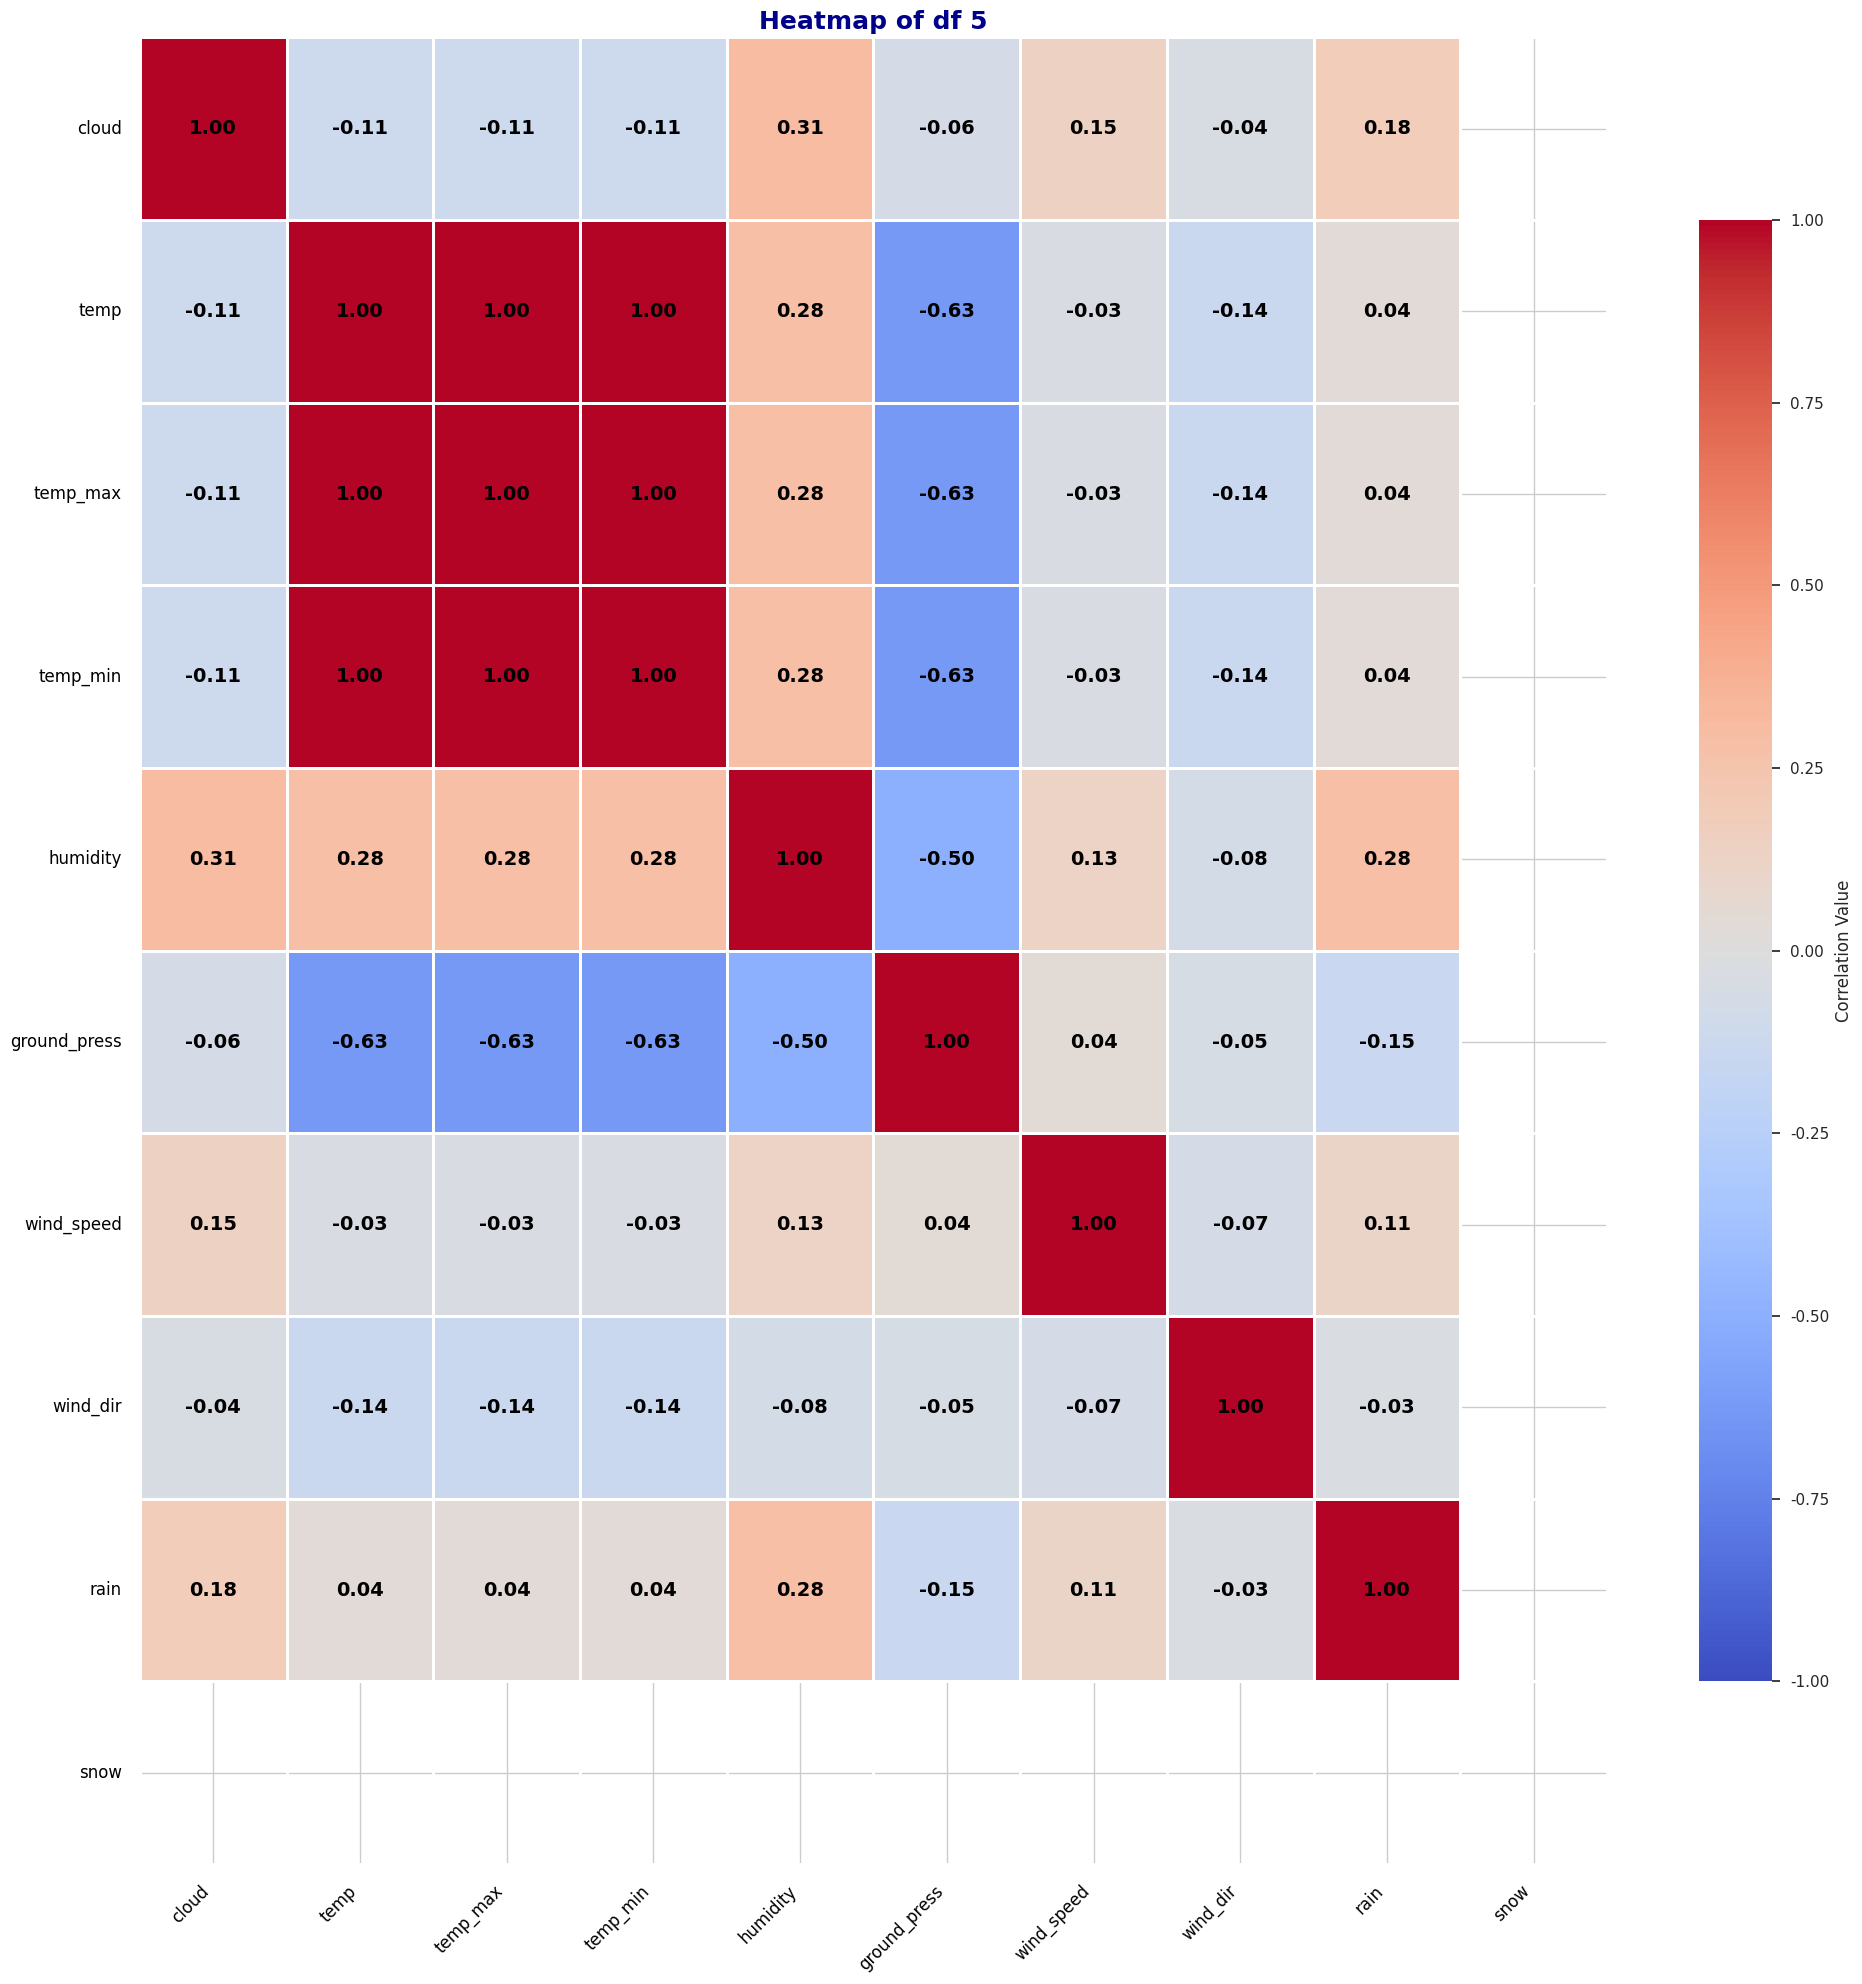

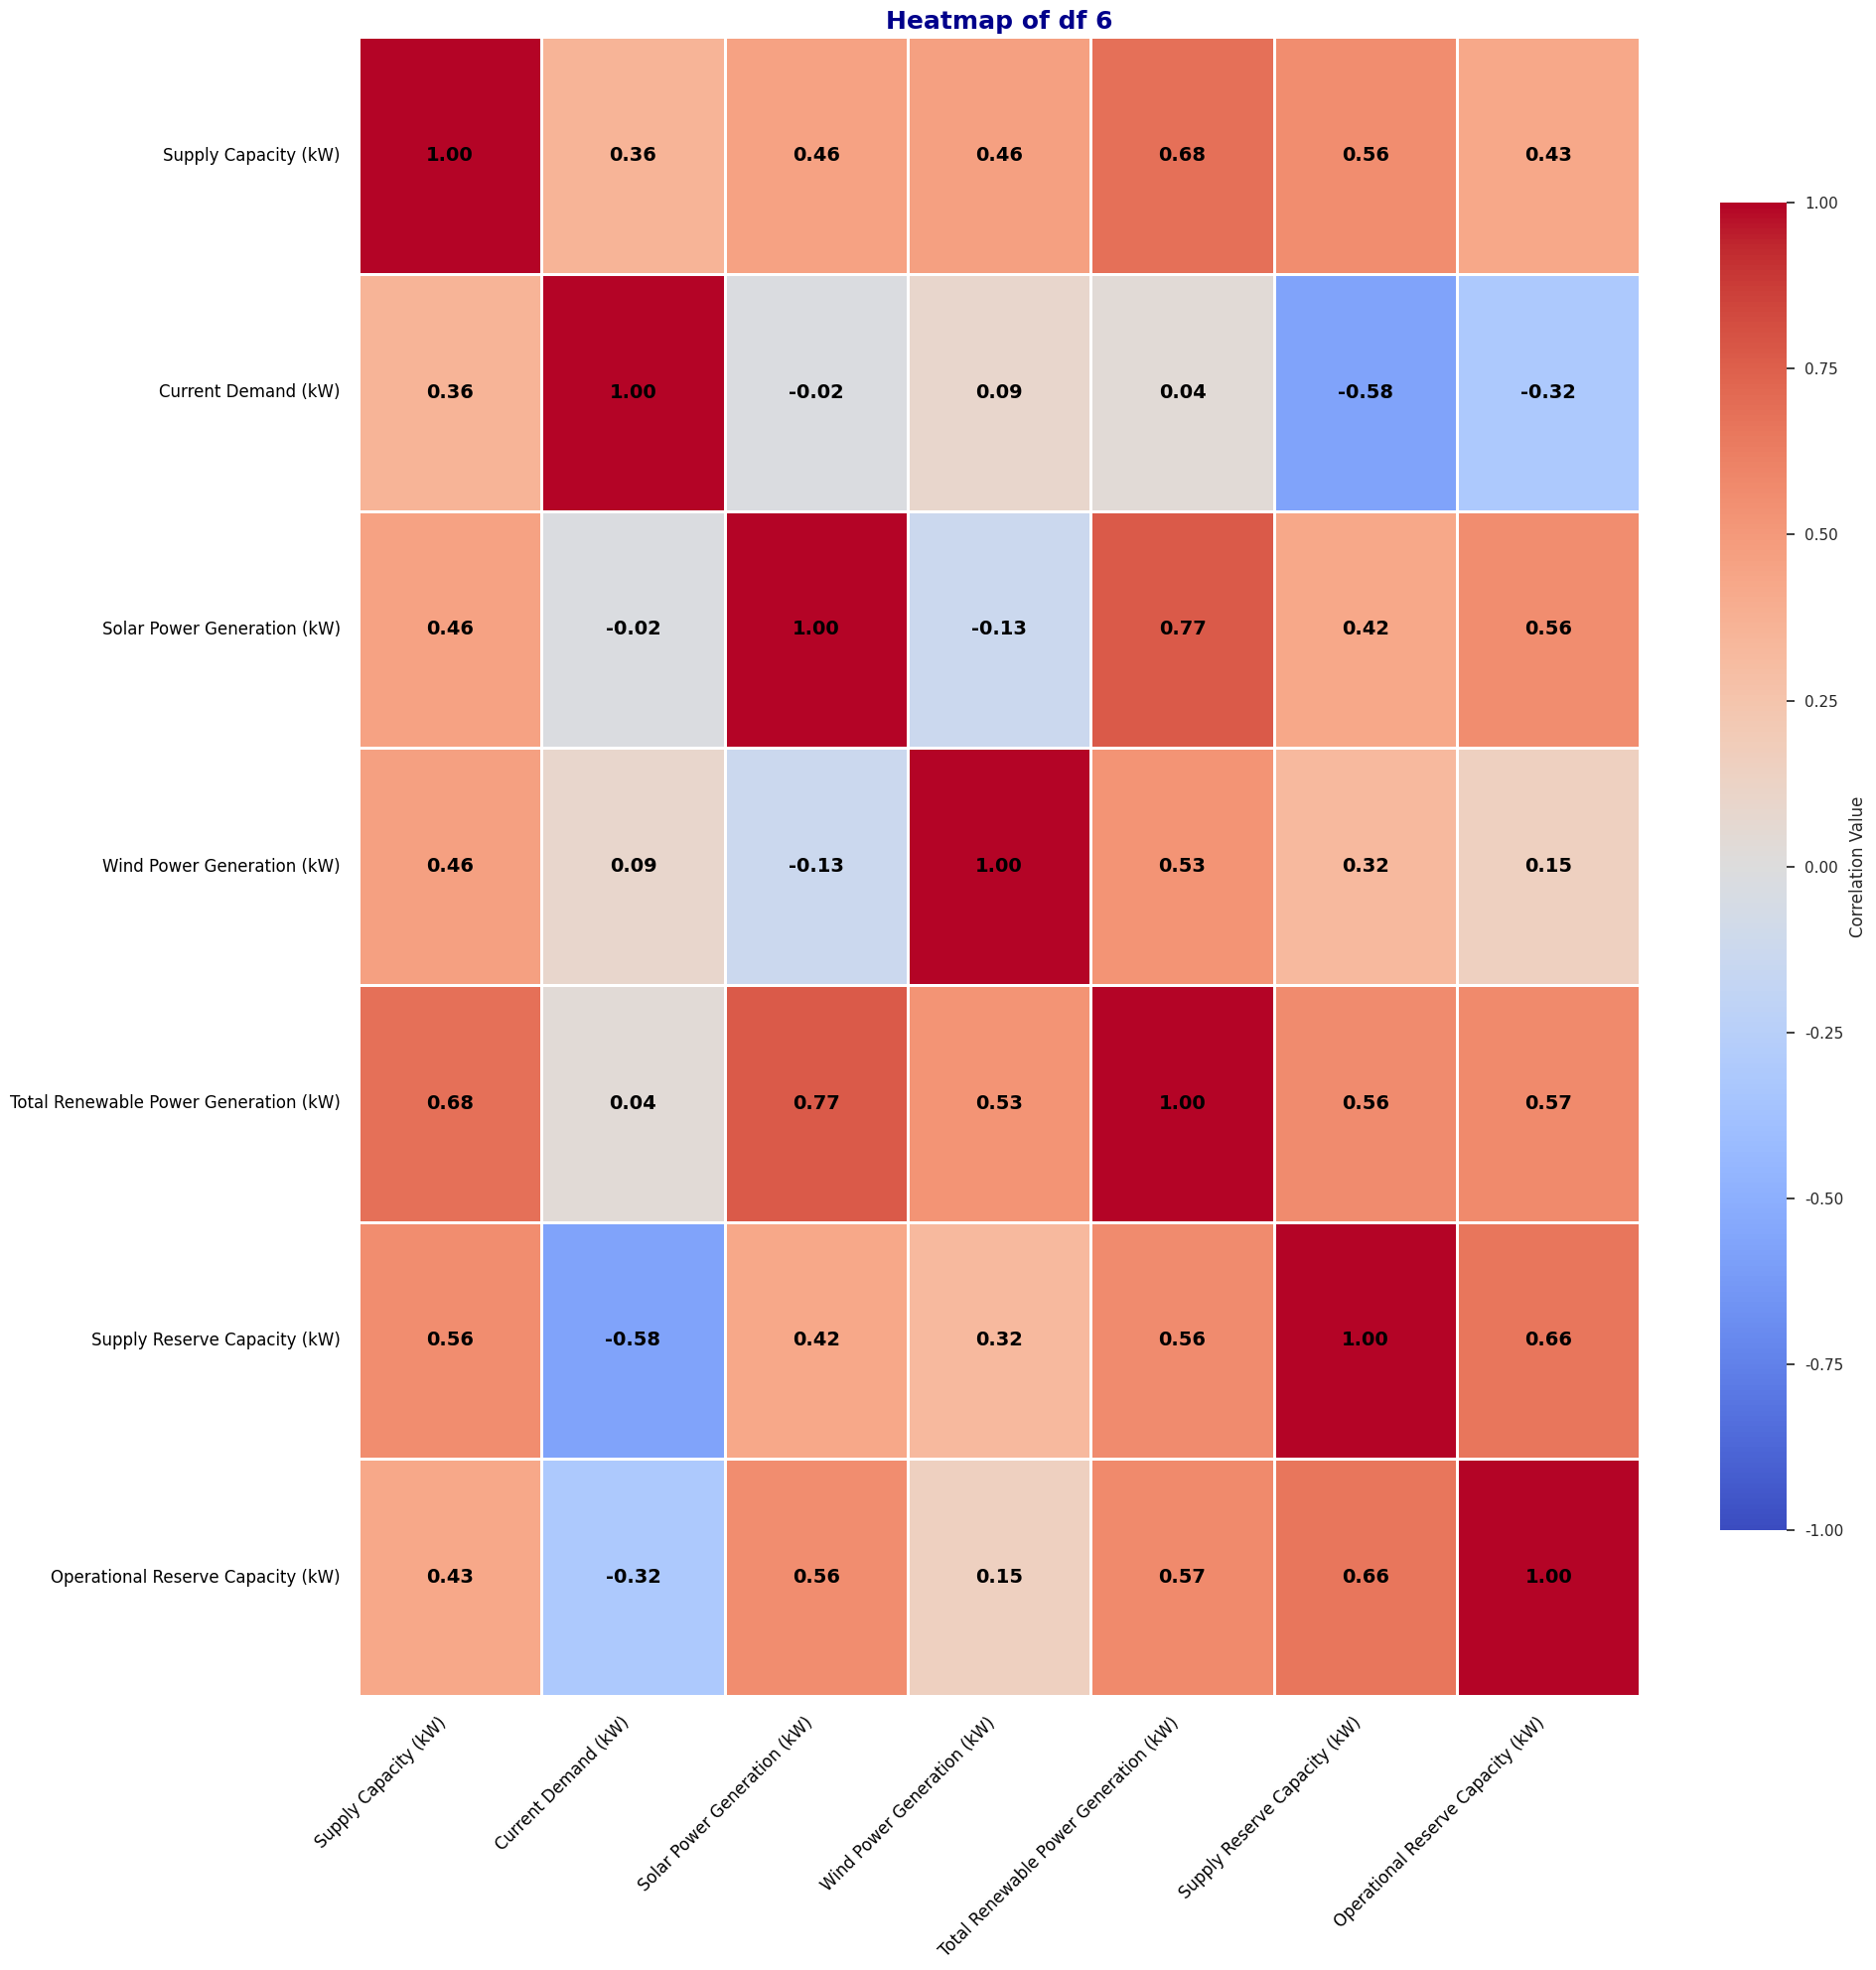

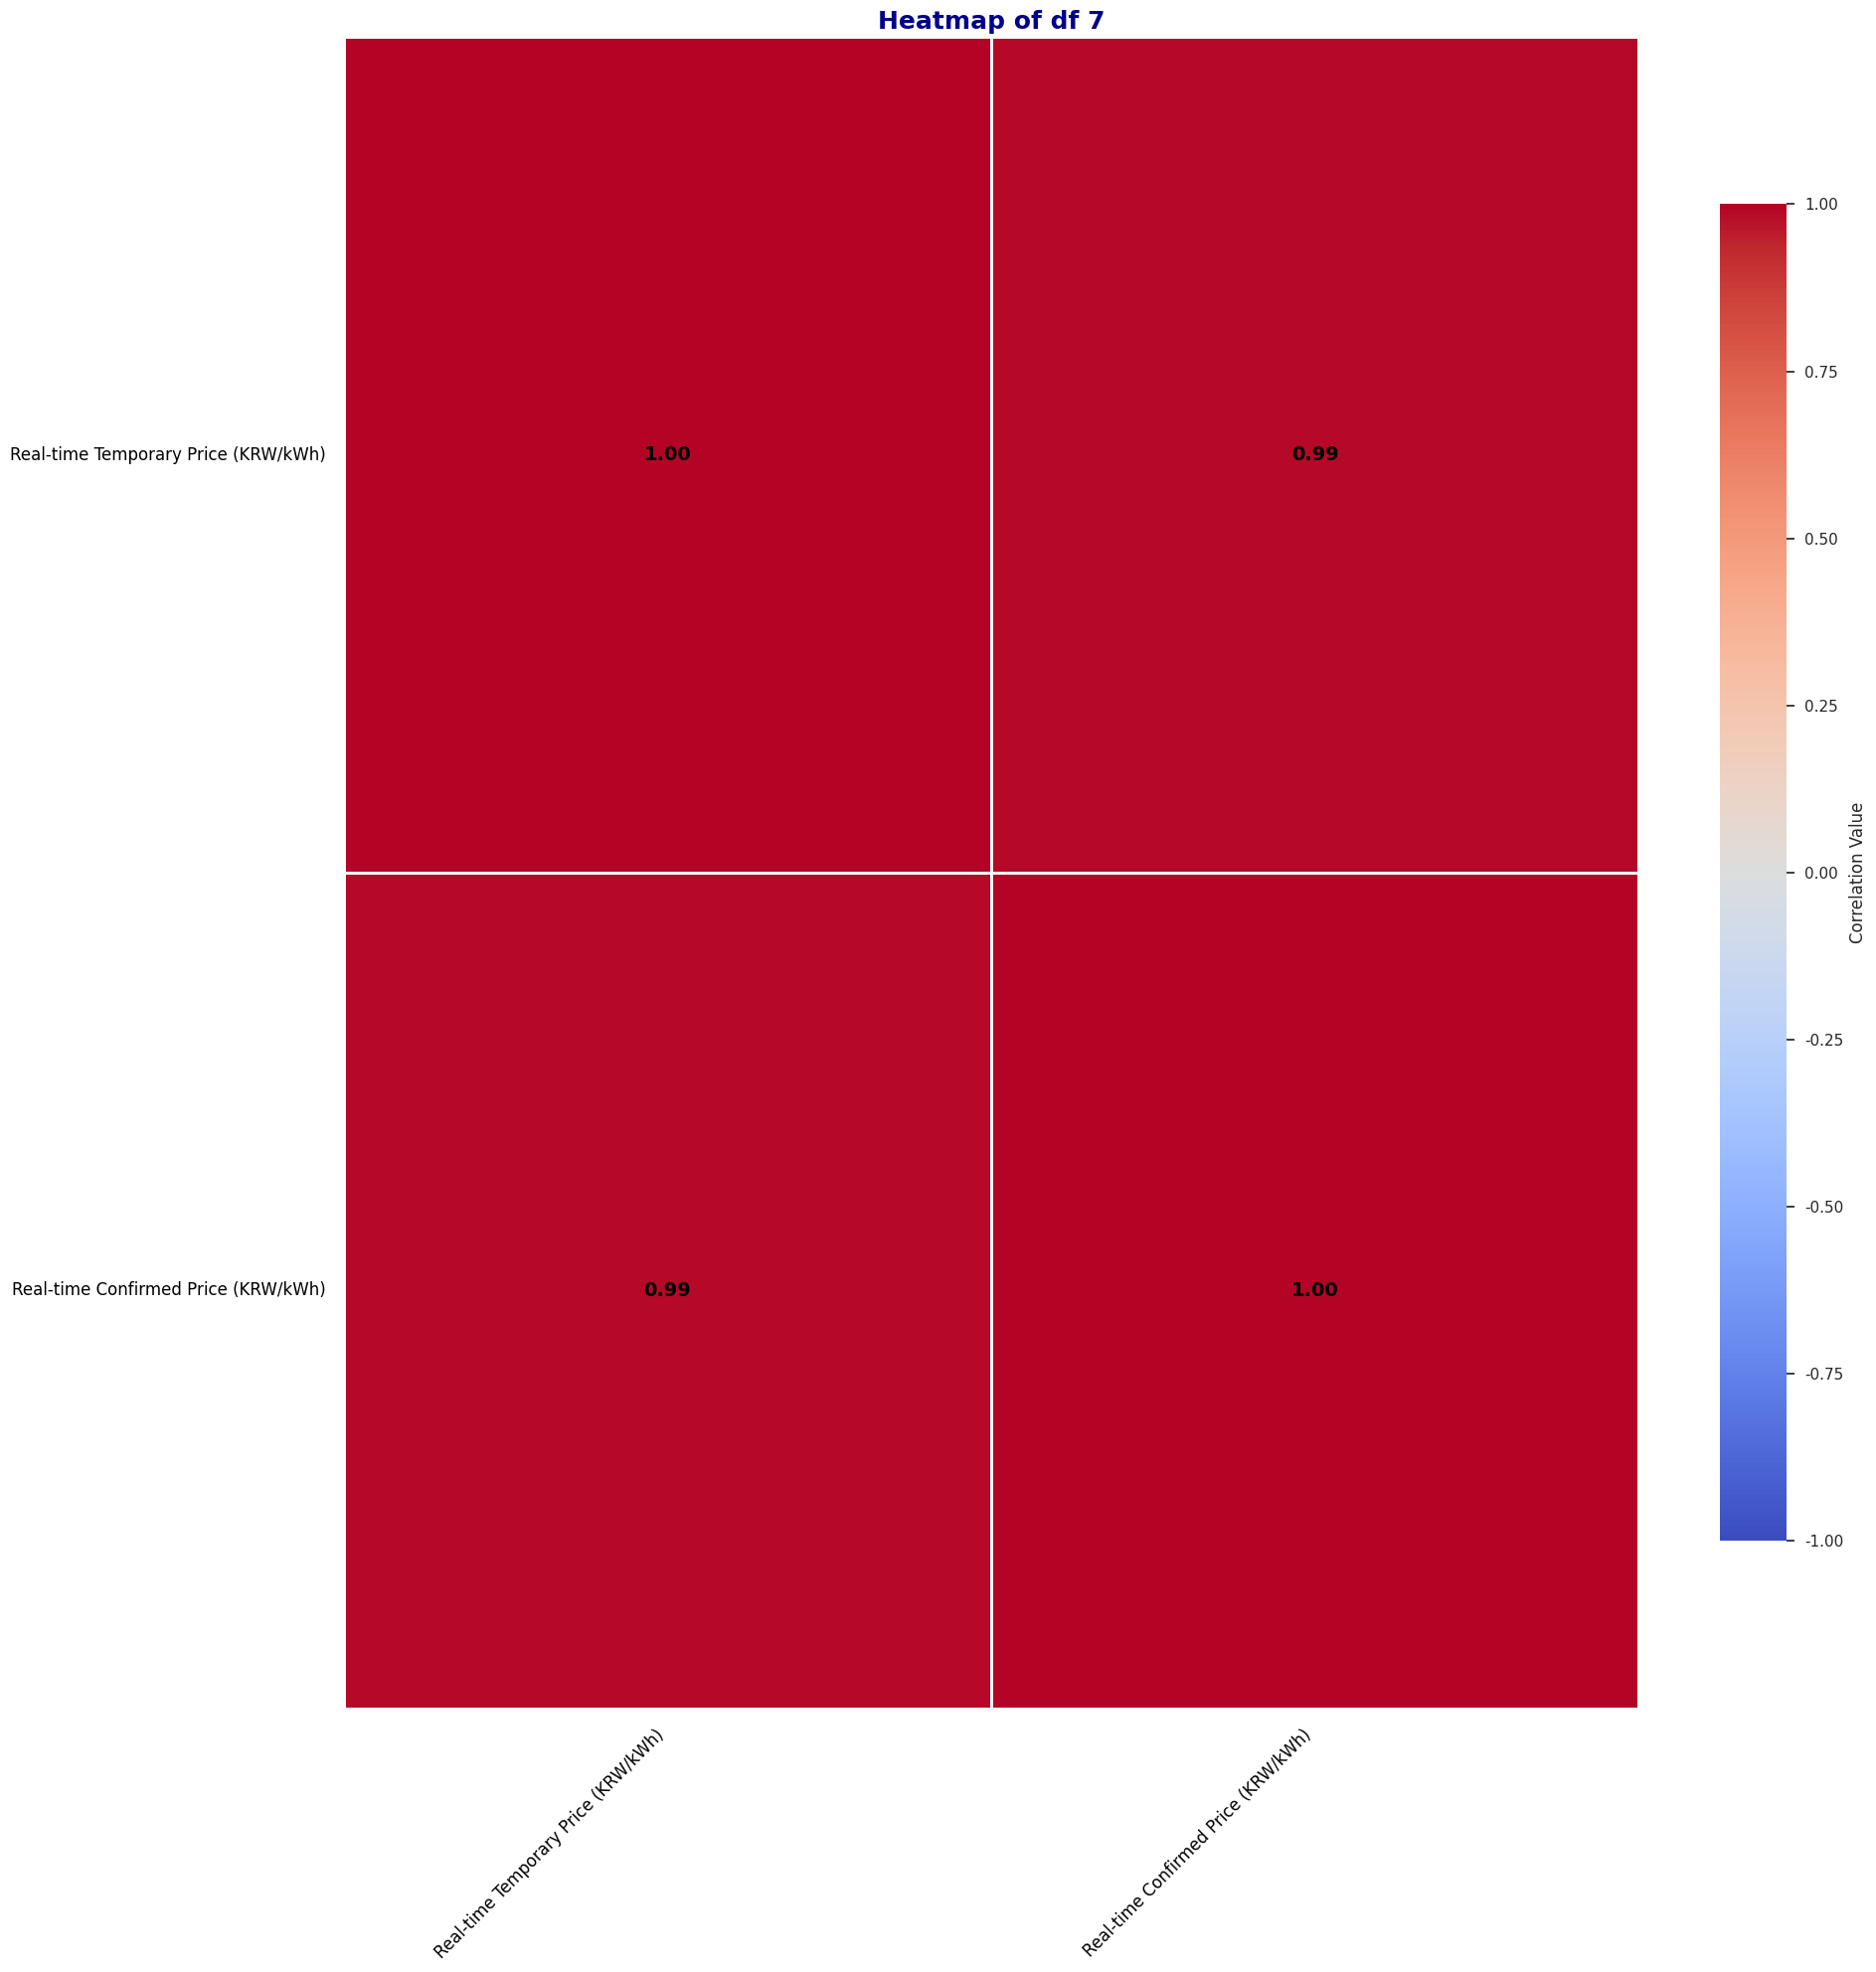

In [233]:
# 각 frame의 heatmap 시각화

for i, df in enumerate(df_list):
    if len(df.columns) >= 2:
        corr = df.corr()
        
        if corr.empty: 
            continue

        plt.figure(figsize=(20, 20))
        sns.set(style='whitegrid')

        heatmap = sns.heatmap(
            corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, 
            annot_kws={"size": 14, "weight": "bold", "color": "black"},
            linewidths=0.8, linecolor='white', vmin=-1, vmax=1, 
            cbar_kws={"shrink": 0.8, "label": "Correlation Value"}
        )

        plt.title(f"Heatmap of df {i+1}", fontsize=18, fontweight='bold', color='darkblue')

        heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, ha='right', fontsize=12, fontweight='light')
        heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0, fontsize=12, fontweight='light')

        heatmap.tick_params(axis='both', which='major', length=6, width=1.5, colors='black')
        
        plt.tight_layout()
        plt.show()
    else:
        pass

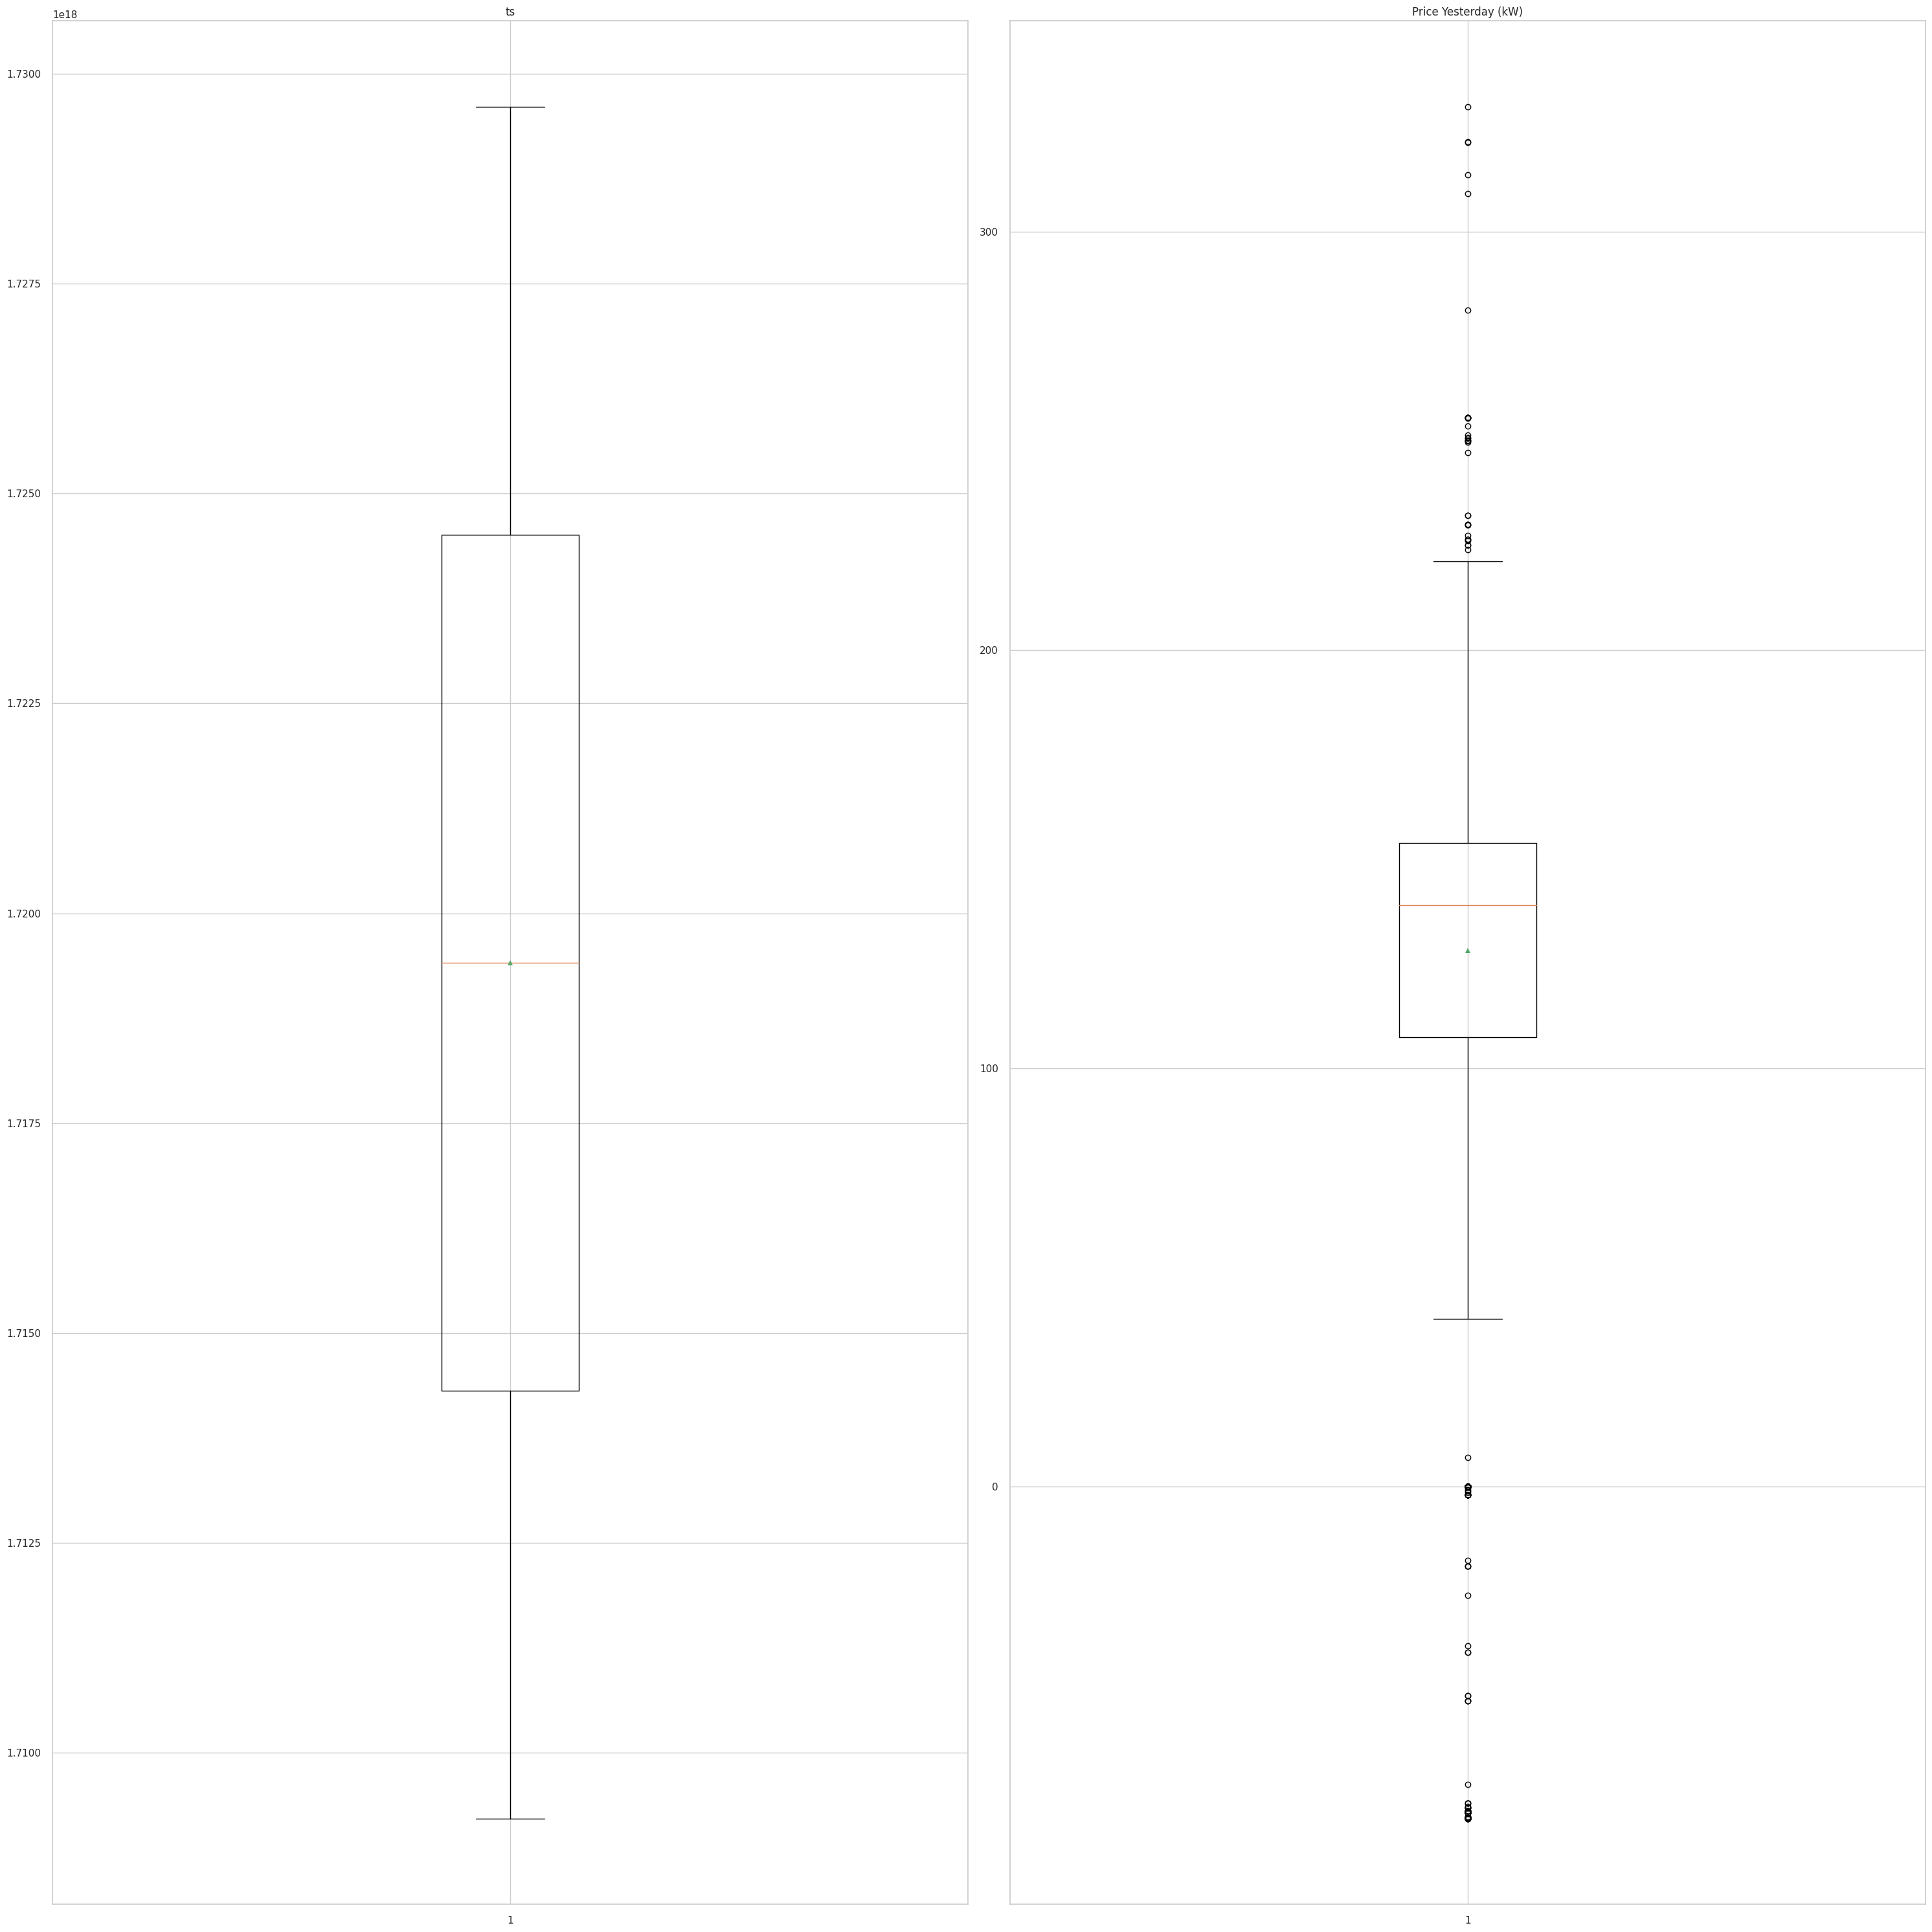

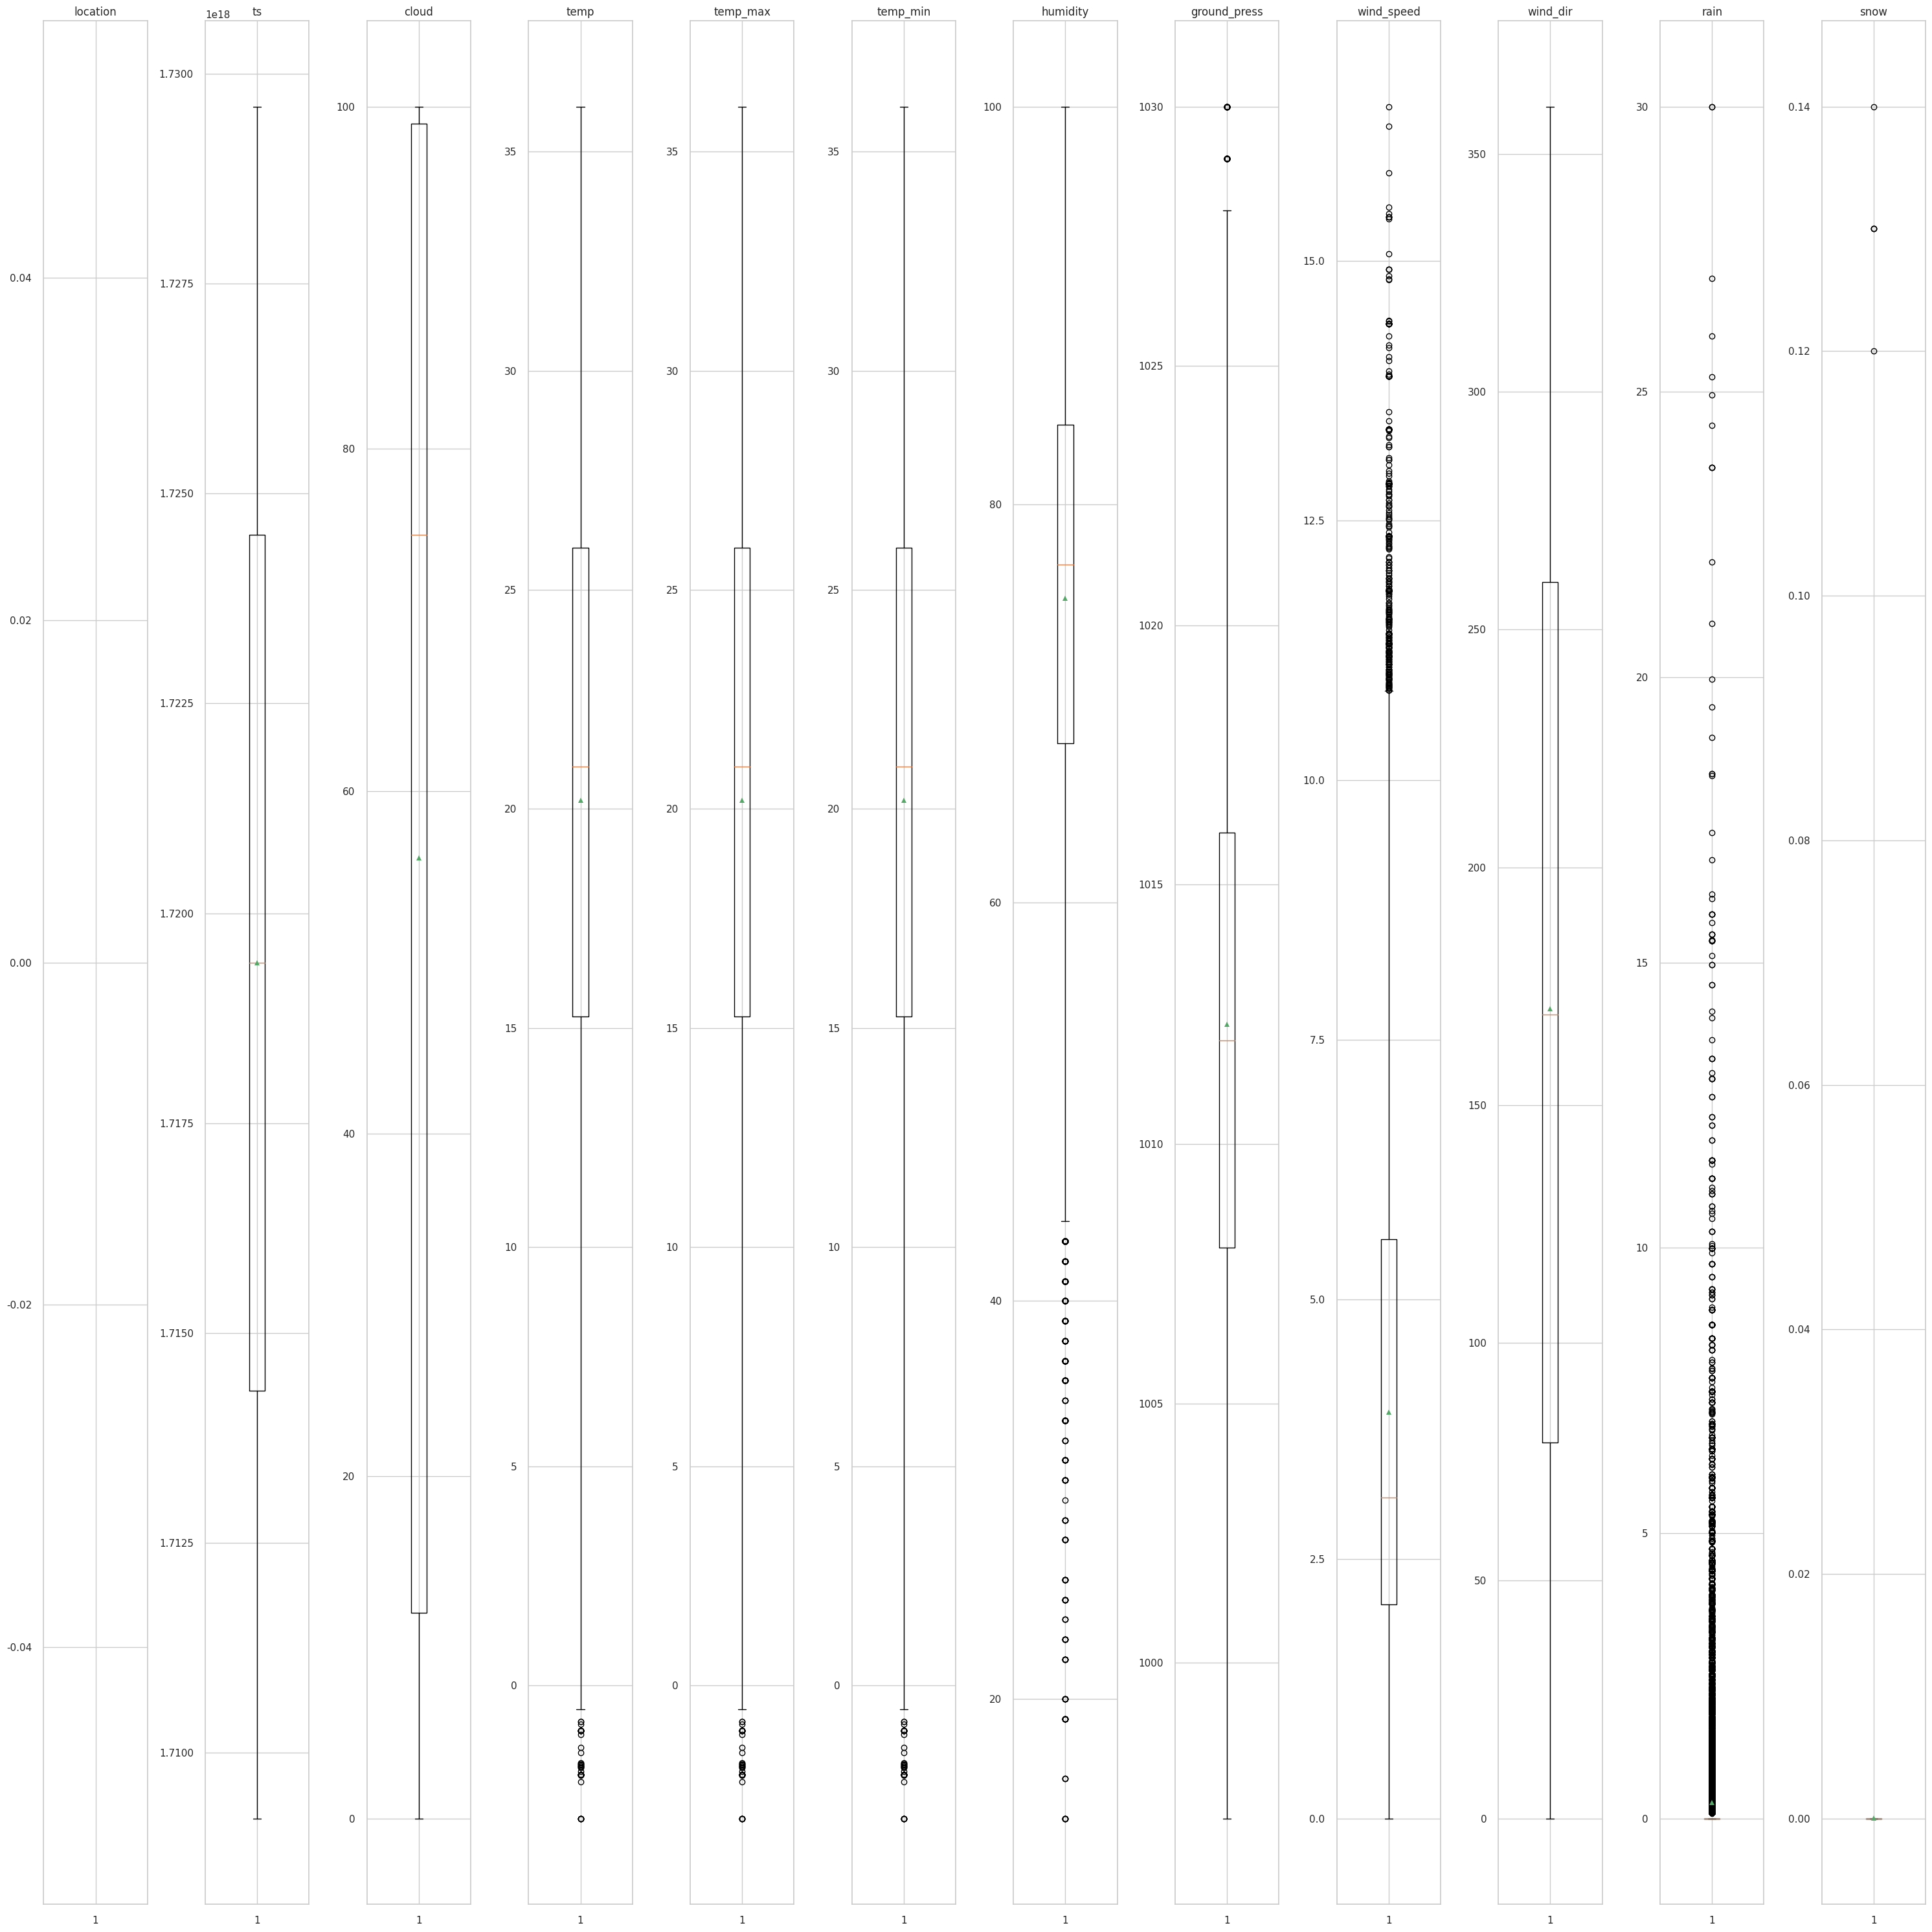

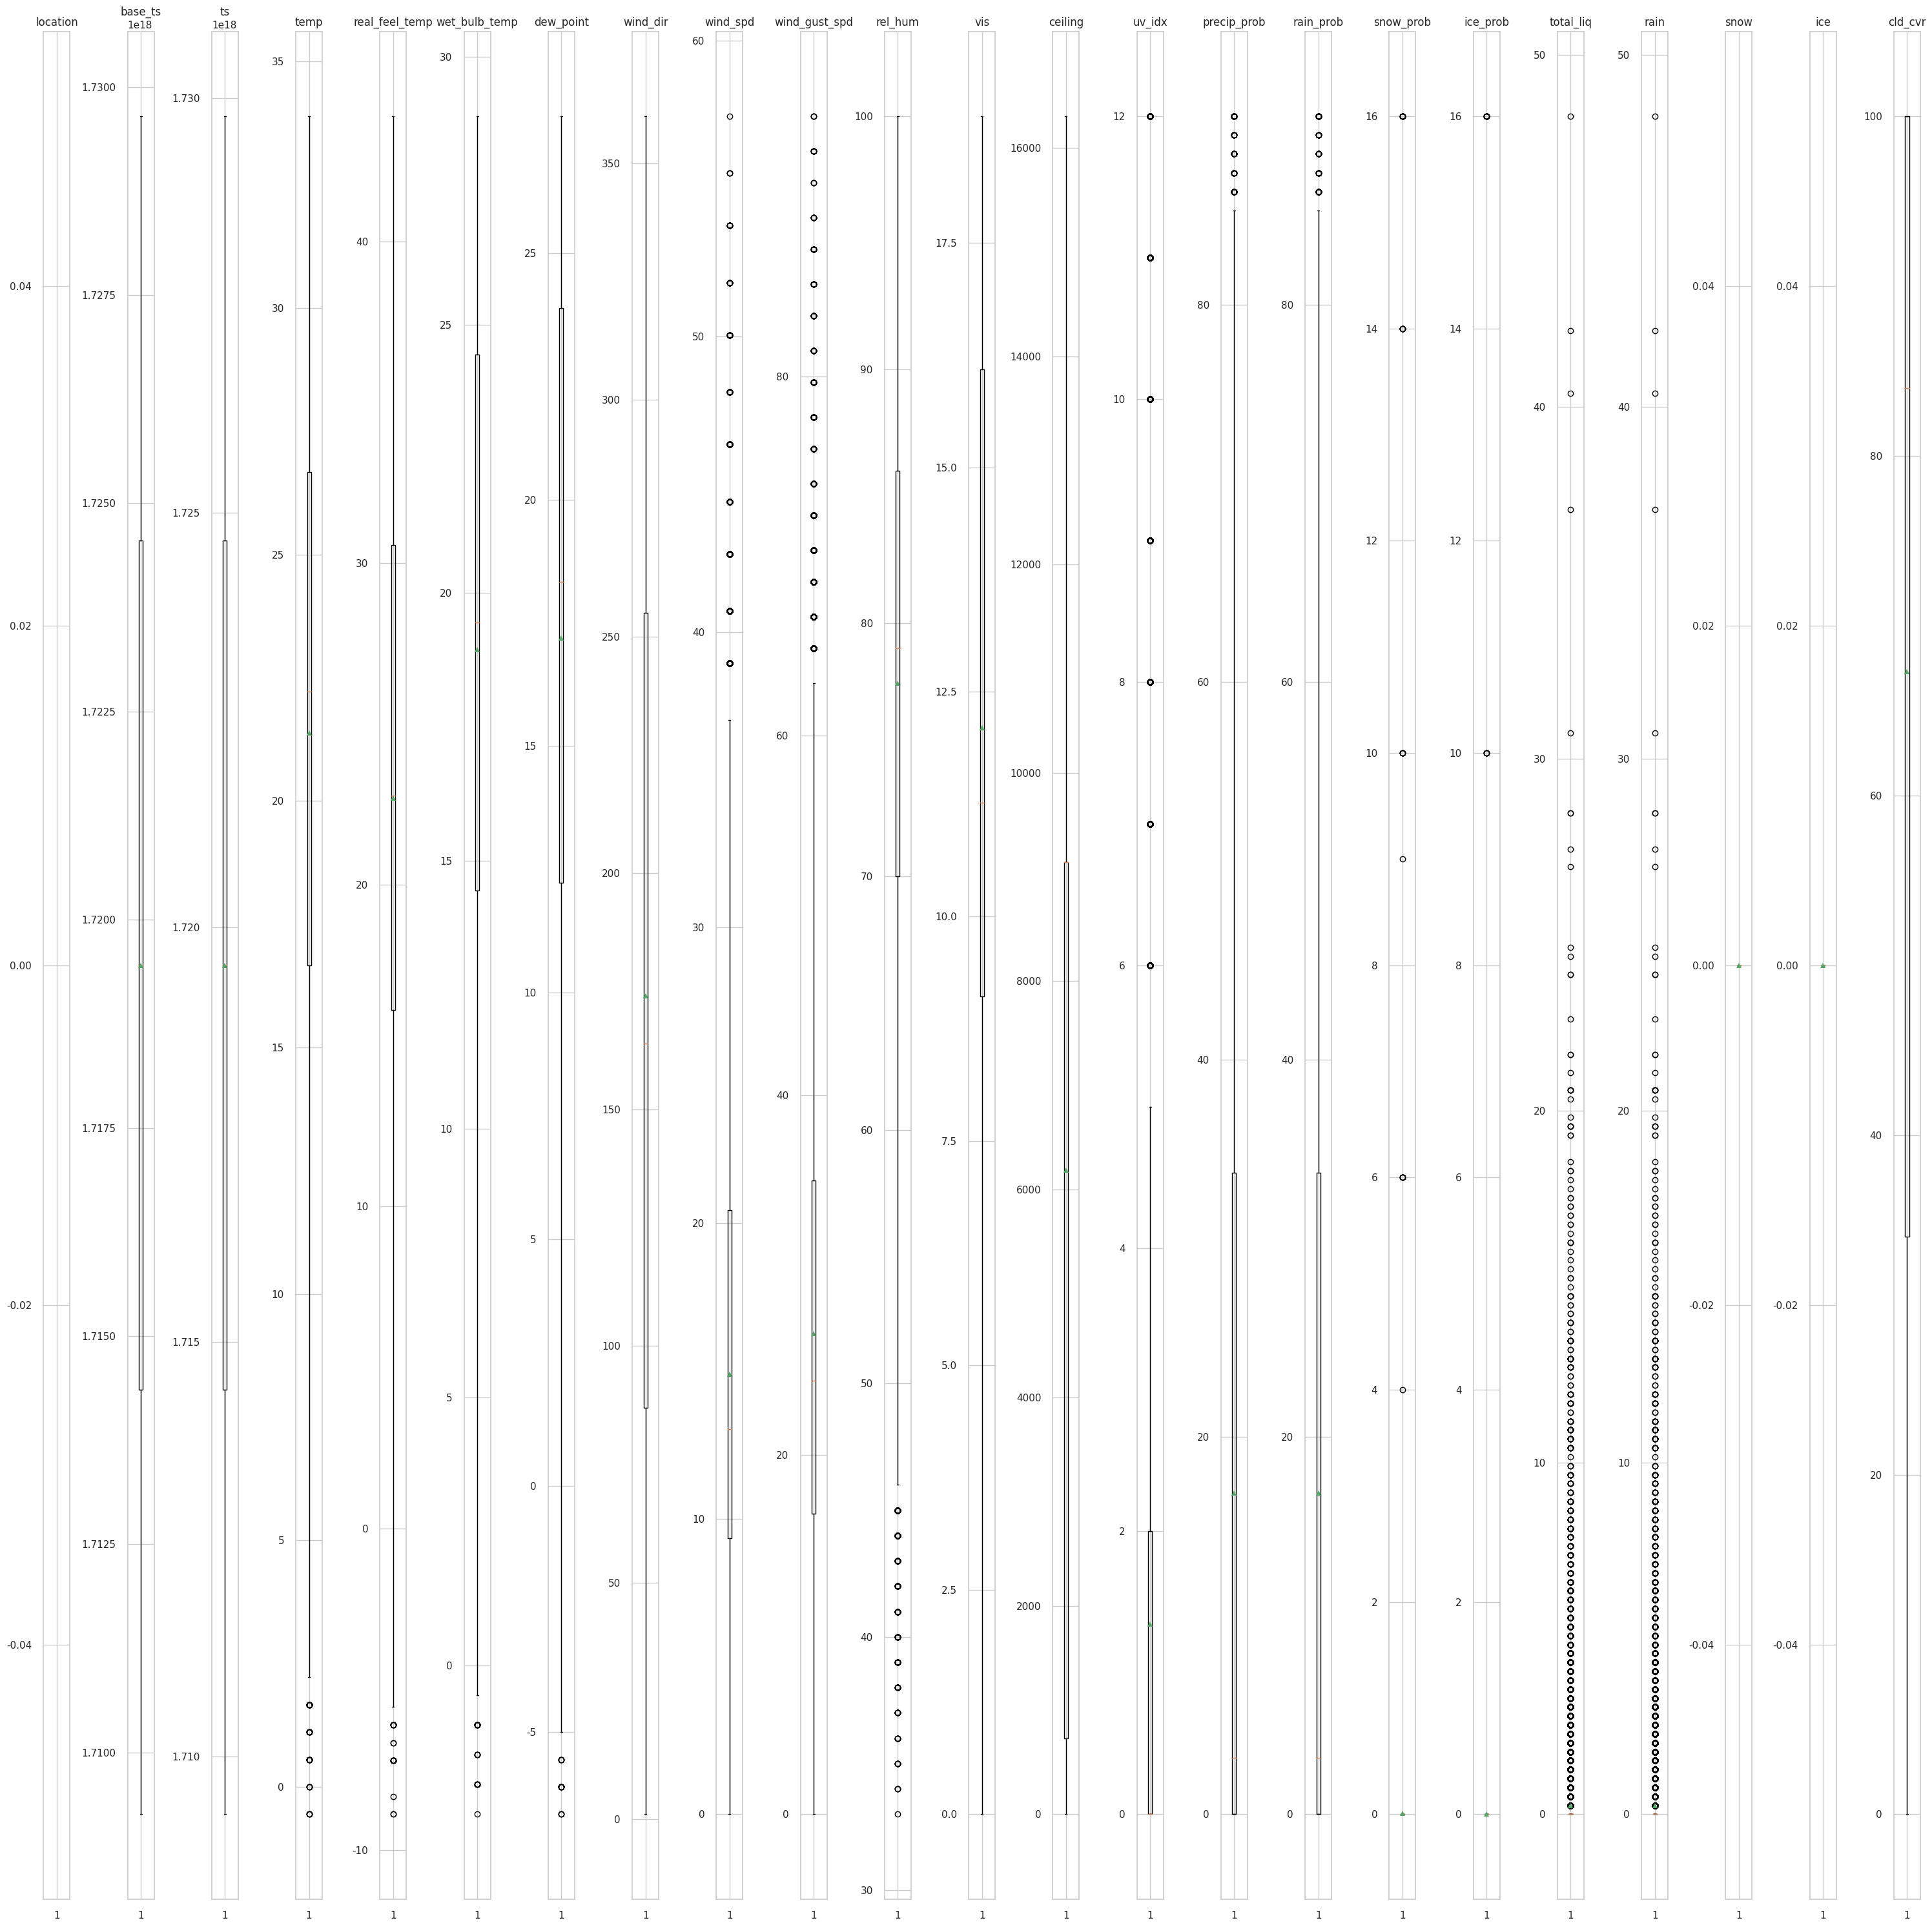

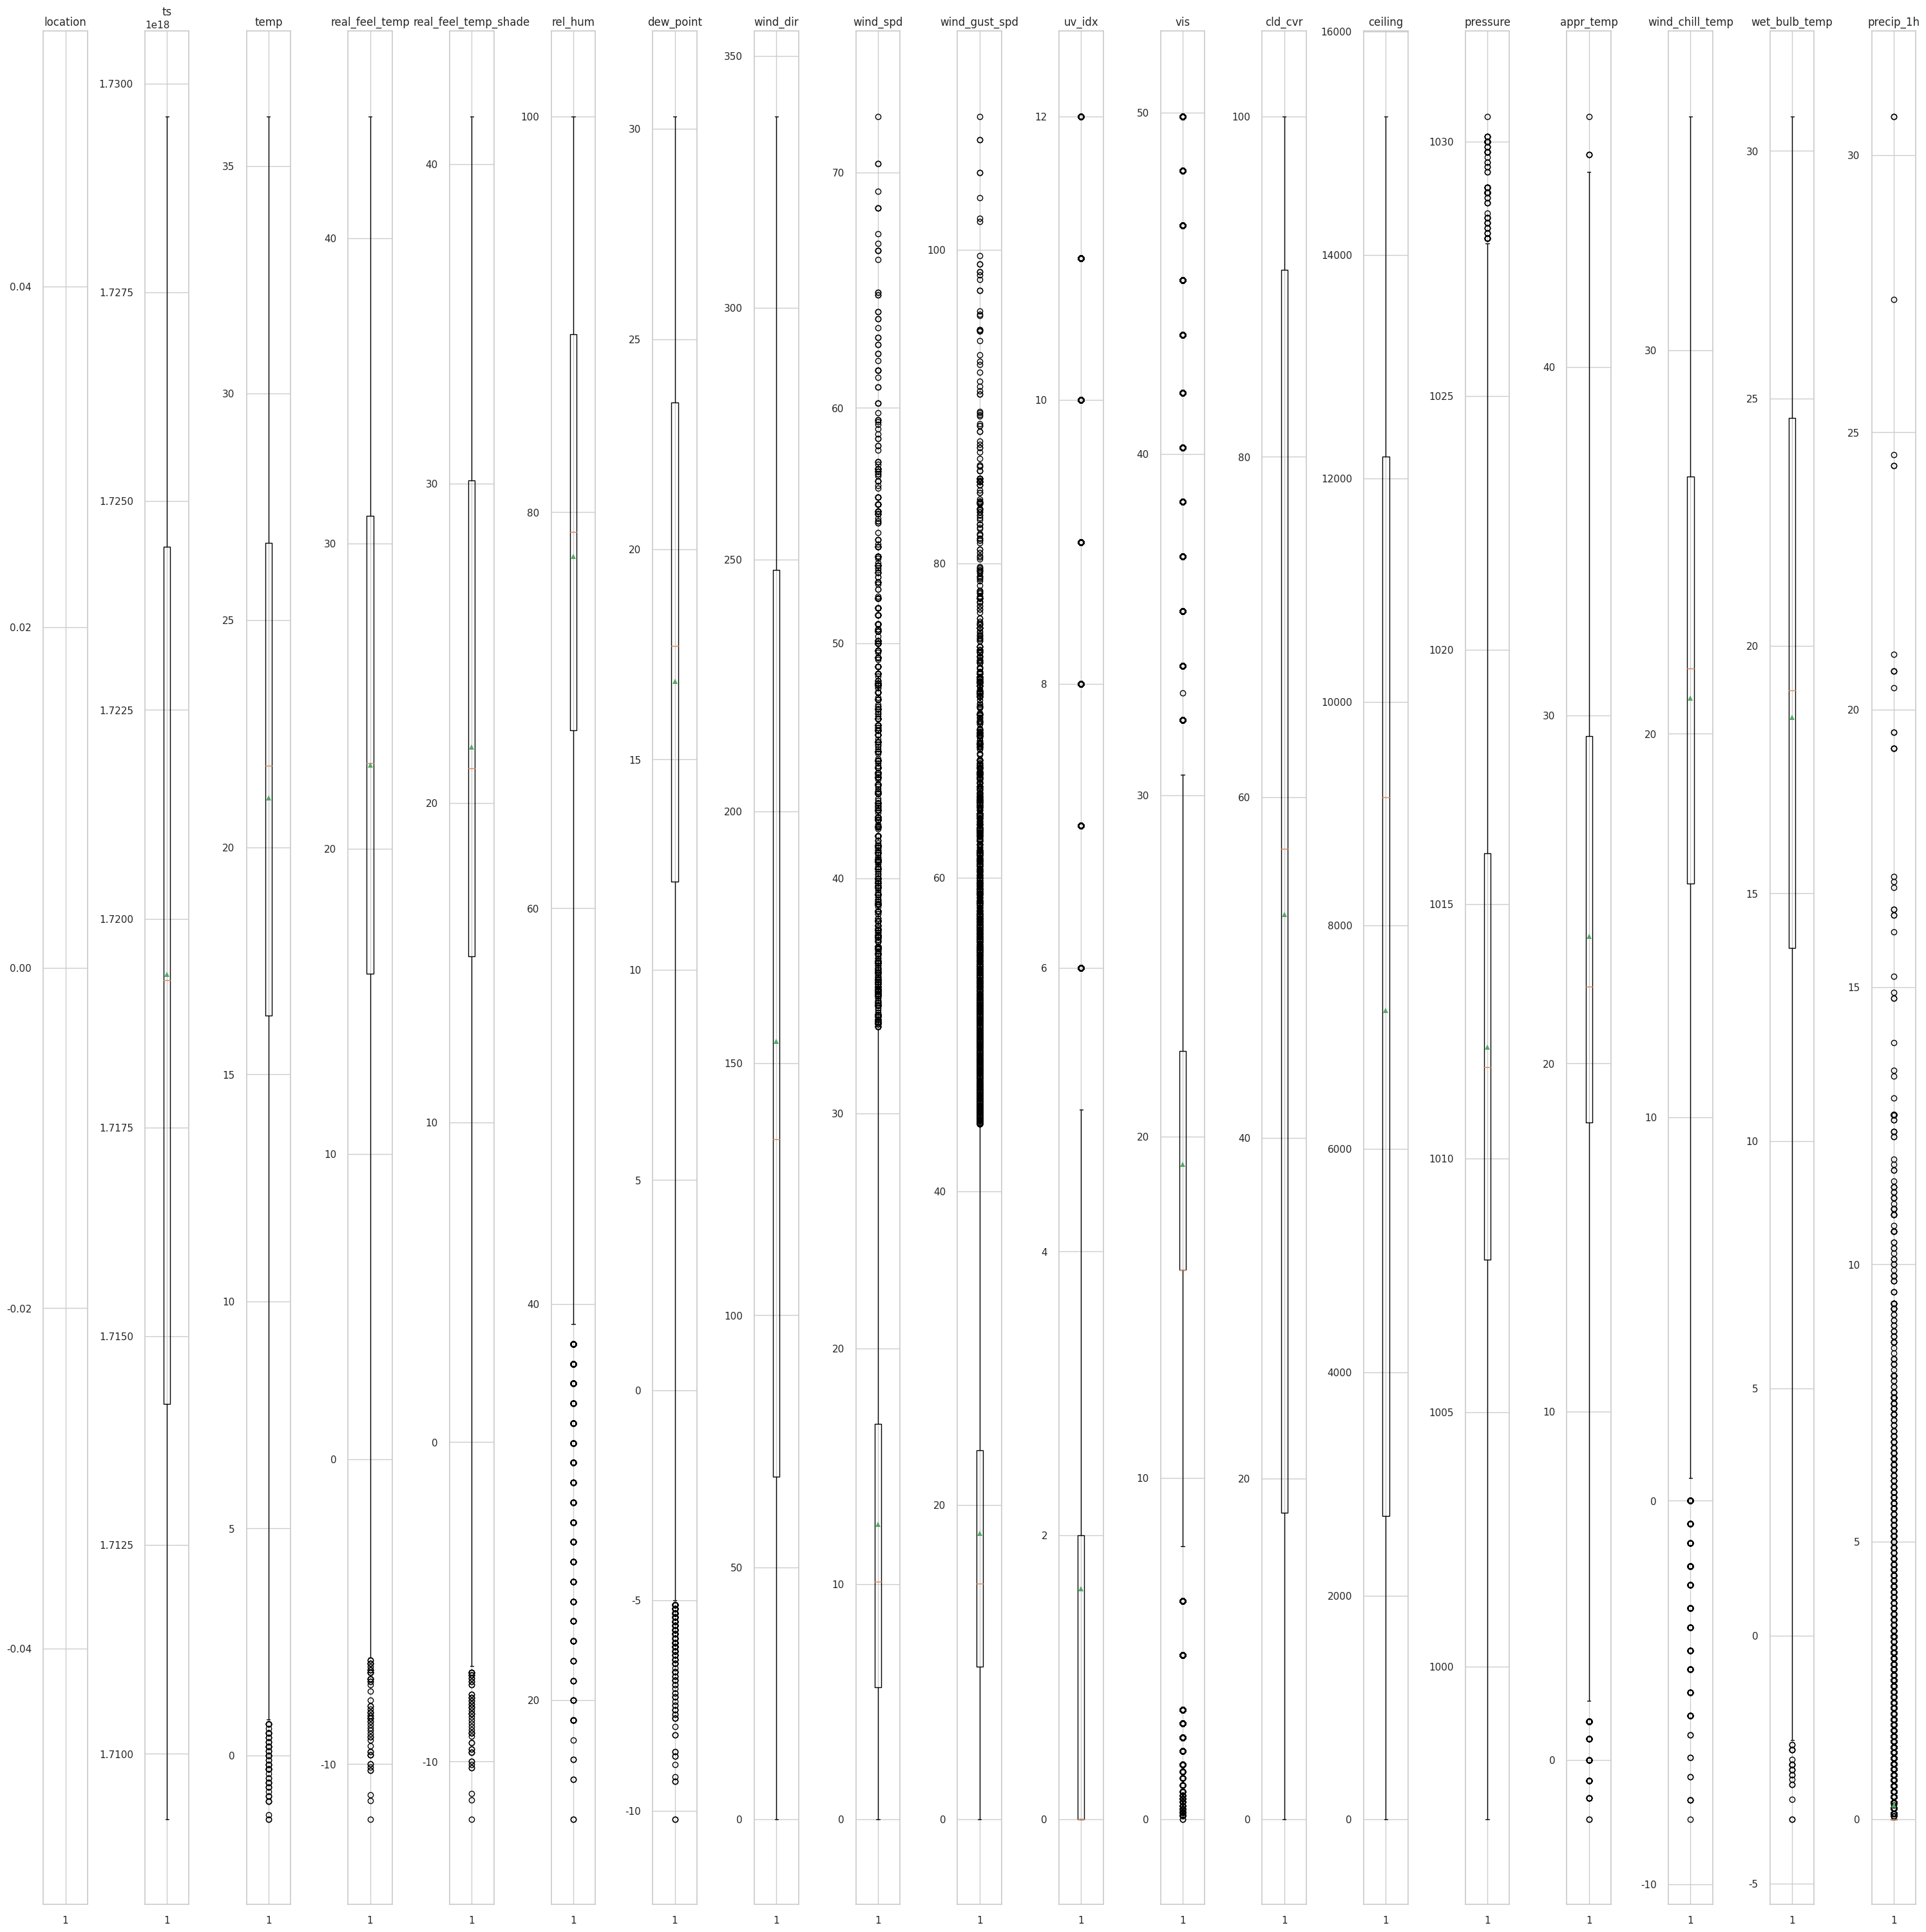

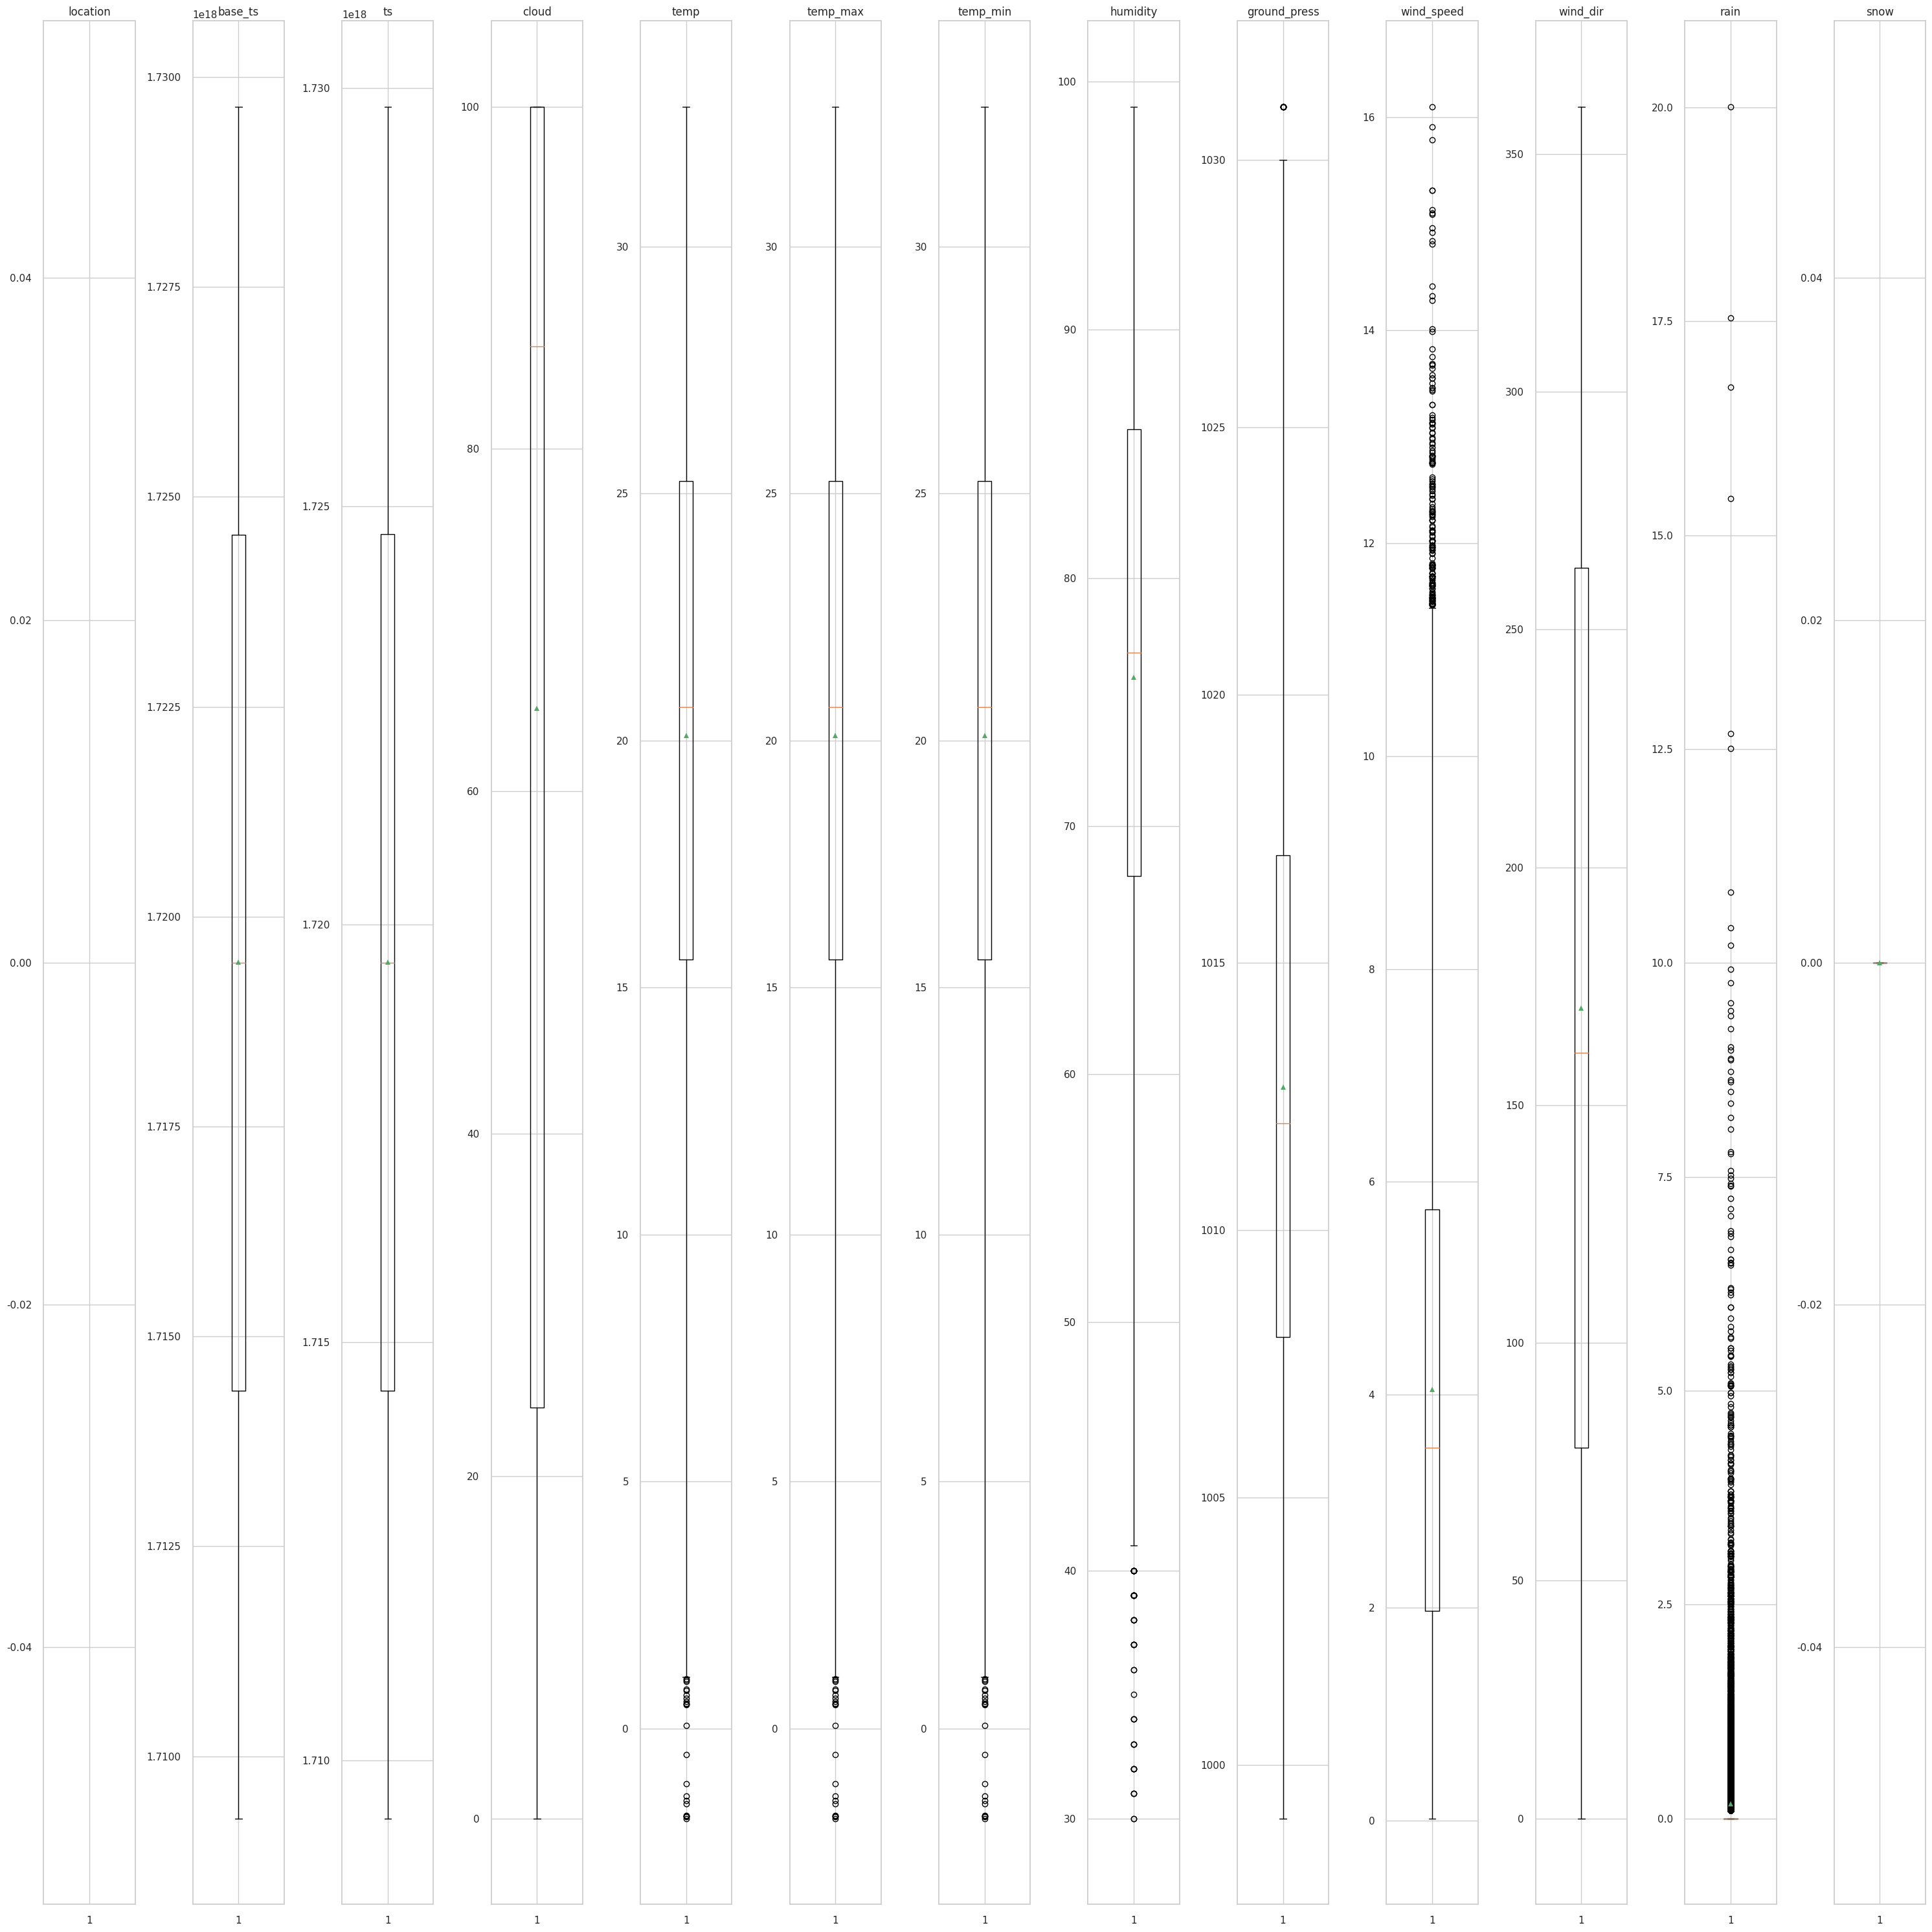

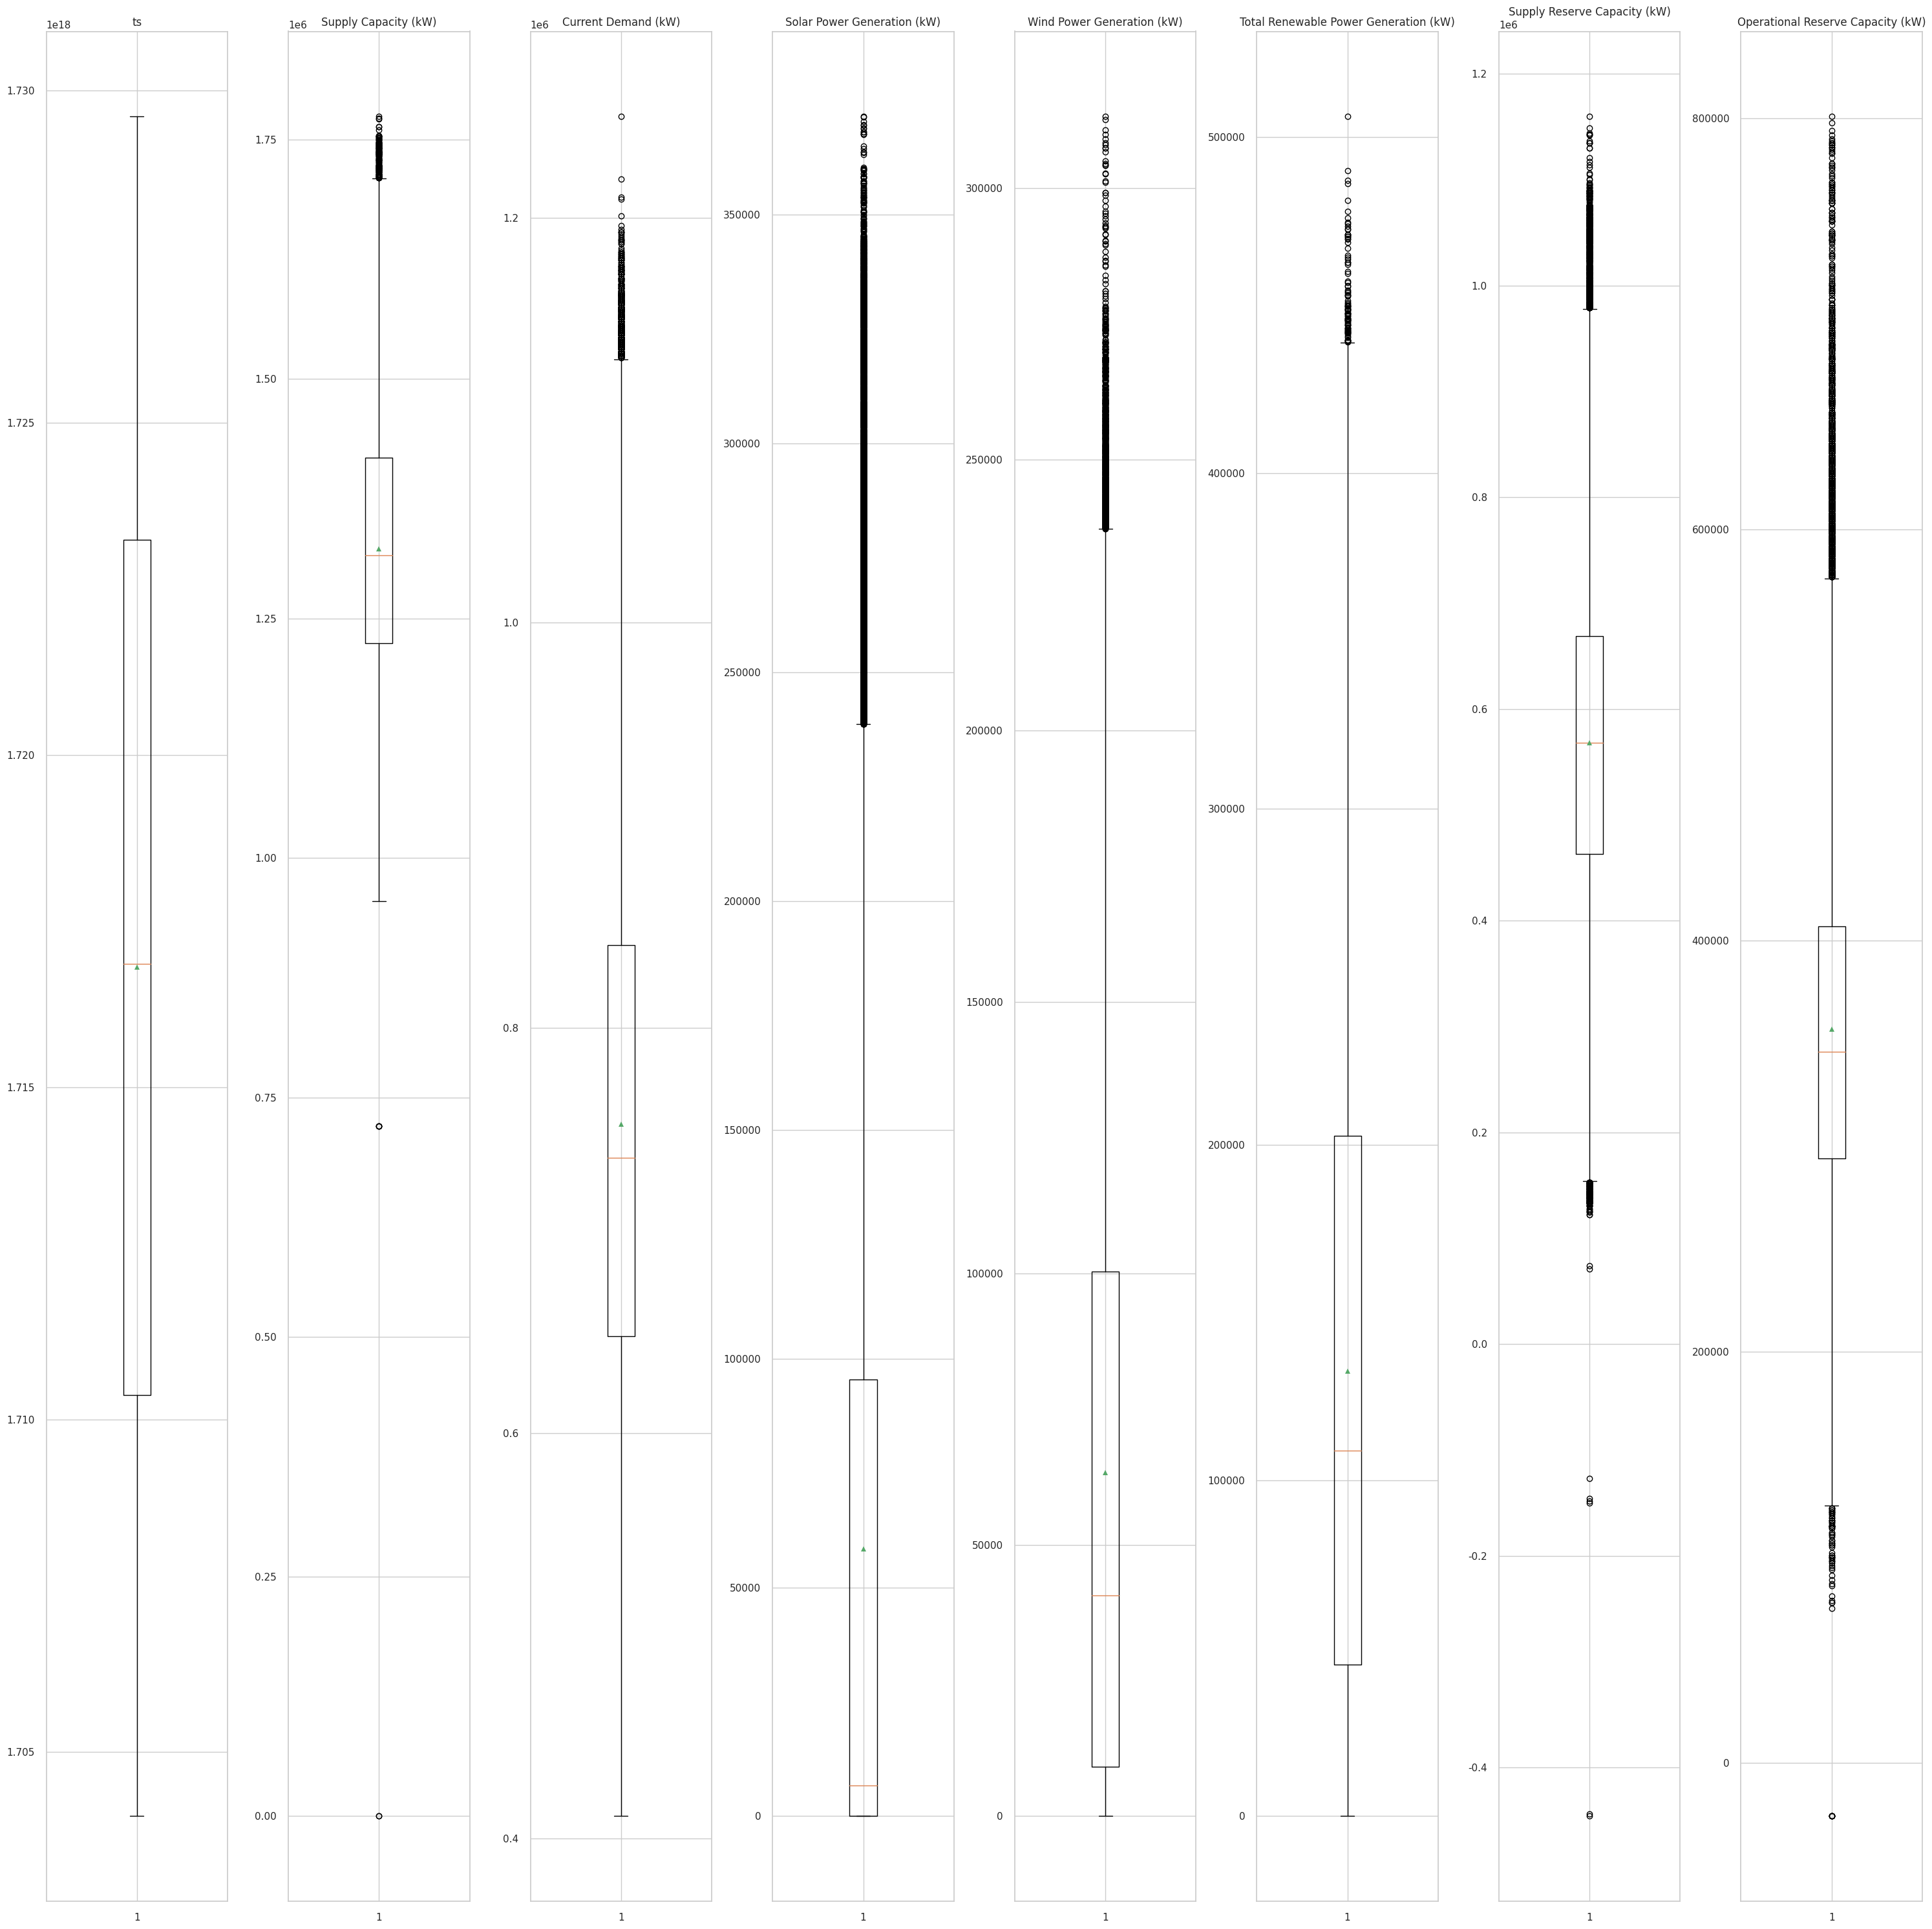

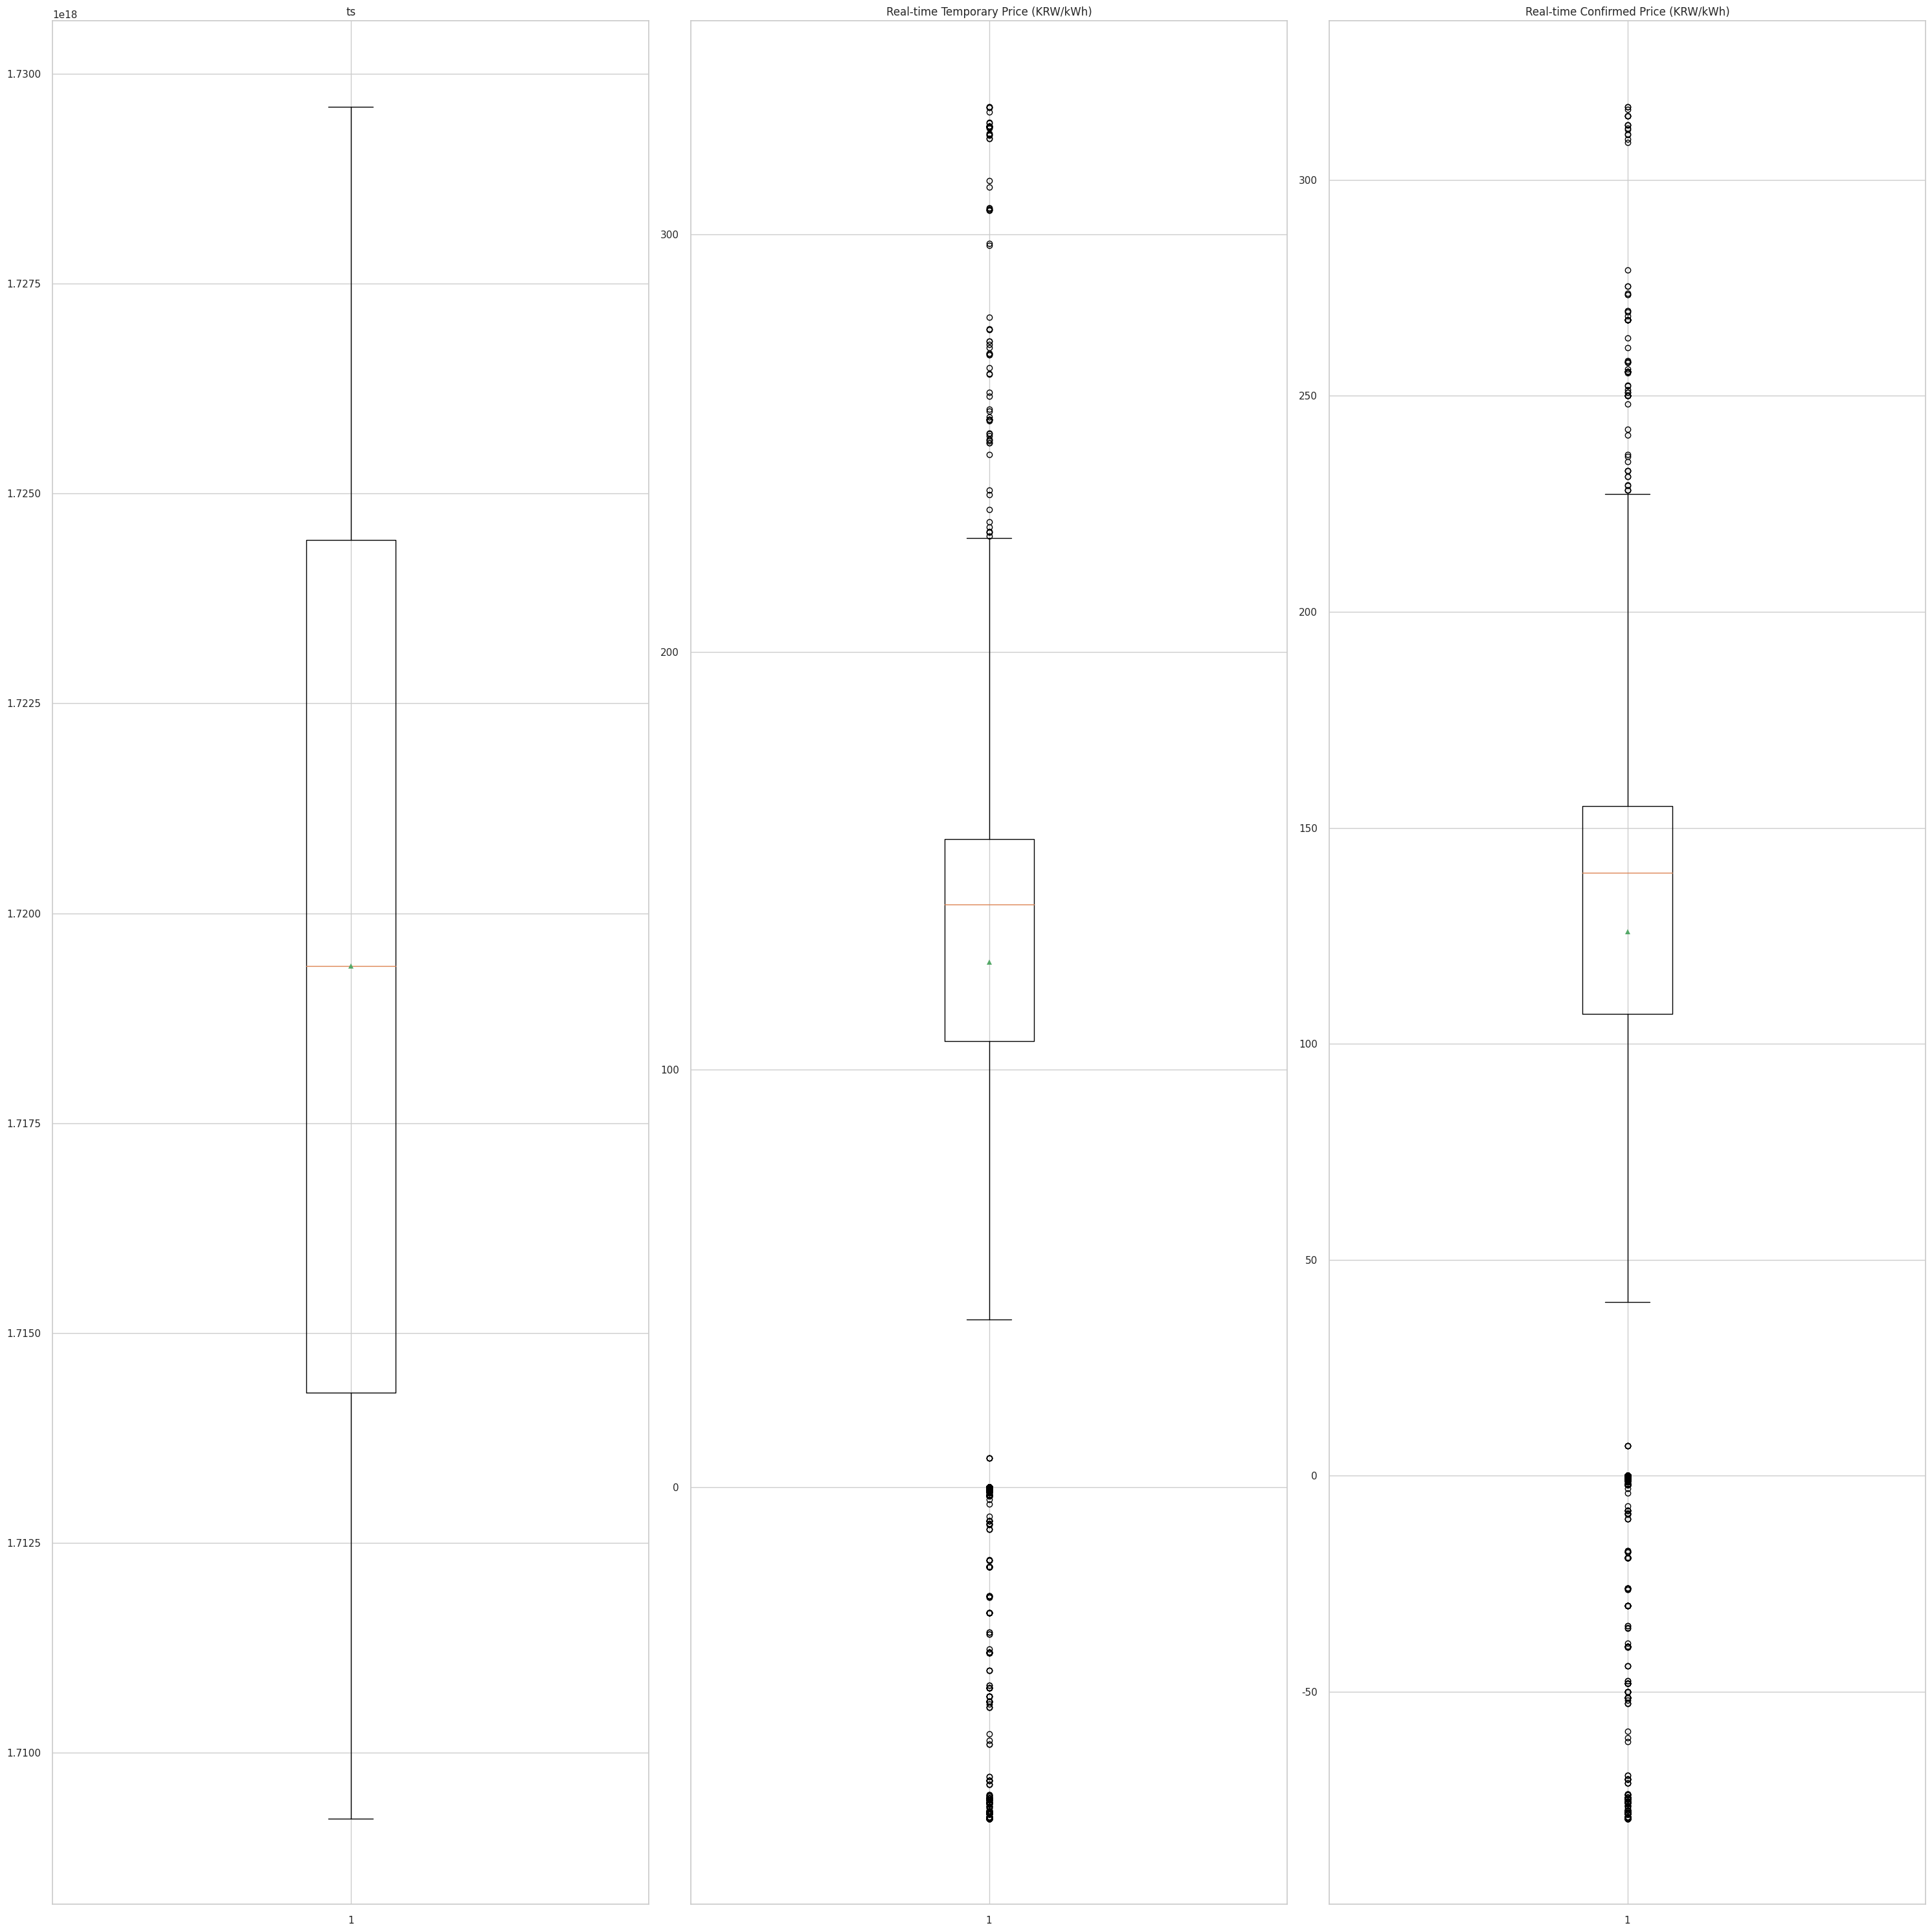

In [234]:
# box plot 그려 데이터 분포 확인

for df in df_list:
    df = df.apply(pd.to_numeric, errors='coerce')
    df = df.fillna(df.median())

    fig, axes = plt.subplots(nrows=1, ncols=df.shape[1], figsize=(30, 30))

    for i, var in enumerate(df.columns):
        ax = axes[i]
        ax.boxplot(df[var], showmeans=True)
        ax.set_title(var)

    plt.tight_layout()
    plt.show()

In [235]:
# 첫 번째 데이터프레임을 기준으로 다른 데이터프레임들과 병합

for i in range (7) : 
    print (os.path.basename(csv_files[i]))
    
dfs_to_merge = [0, 5, 6, 2]  

ts_sets = [set(df_list[idx]['ts'].values) for idx in dfs_to_merge]
common_ts = set.intersection(*ts_sets)
filtered_dfs = [df_list[idx][df_list[idx]['ts'].isin(common_ts)] for idx in dfs_to_merge]

merged_df = filtered_dfs[0]
for df in filtered_dfs[1:]:
    merged_df = pd.merge(merged_df, df, on='ts', how='inner')

merged_df = merged_df.sort_values('ts')

print (f"공통된 ts 개수 : {len(common_ts)}")
print (merged_df.info())

제주전력시장_시장전기가격_하루전가격.csv
기상실측데이터_2.csv
기상예측데이터_1.csv
기상실측데이터_1.csv
기상예측데이터_2.csv
제주전력시장_현황데이터.csv
제주전력시장_시장전기가격_실시간가격.csv
공통된 ts 개수 : 5559
<class 'pandas.core.frame.DataFrame'>
Int64Index: 52128 entries, 0 to 52127
Data columns (total 33 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   ts                                     52128 non-null  datetime64[ns]
 1   Price Yesterday (kW)                   52128 non-null  float64       
 2   Supply Capacity (kW)                   52128 non-null  float64       
 3   Current Demand (kW)                    52128 non-null  float64       
 4   Solar Power Generation (kW)            52128 non-null  float64       
 5   Wind Power Generation (kW)             52128 non-null  float64       
 6   Total Renewable Power Generation (kW)  5212

In [236]:
# base_ts, ceiling 삭제 및 location label encoding

from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()

merged_df = merged_df.drop(['base_ts', 'ceiling'], axis=1, errors='ignore')
merged_df['location'] = LE.fit_transform(merged_df['location'])

merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52128 entries, 0 to 52127
Data columns (total 31 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   ts                                     52128 non-null  datetime64[ns]
 1   Price Yesterday (kW)                   52128 non-null  float64       
 2   Supply Capacity (kW)                   52128 non-null  float64       
 3   Current Demand (kW)                    52128 non-null  float64       
 4   Solar Power Generation (kW)            52128 non-null  float64       
 5   Wind Power Generation (kW)             52128 non-null  float64       
 6   Total Renewable Power Generation (kW)  52128 non-null  float64       
 7   Supply Reserve Capacity (kW)           52128 non-null  float64       
 8   Operational Reserve Capacity (kW)      52128 non-null  float64       
 9   Real-time Temporary Price (KRW/kWh)    52128 non-null  float6

In [237]:
# merged_df에서 Real-time Confirmed Price (KRW/kWh)와의 상관관계를 내림차순으로 나타냄

correlation_matrix = merged_df.corr()
correlation_with_price = correlation_matrix['Real-time Confirmed Price (KRW/kWh)']
corr = correlation_with_price.abs().sort_values(ascending=False)

corr

Real-time Confirmed Price (KRW/kWh)      1.000000e+00
Real-time Temporary Price (KRW/kWh)      9.890211e-01
Price Yesterday (kW)                     6.589807e-01
Current Demand (kW)                      4.842746e-01
Supply Reserve Capacity (kW)             4.760503e-01
Operational Reserve Capacity (kW)        3.799568e-01
uv_idx                                   2.567949e-01
Total Renewable Power Generation (kW)    2.501234e-01
Solar Power Generation (kW)              2.380804e-01
dew_point                                1.993521e-01
wet_bulb_temp                            1.850551e-01
rel_hum                                  1.626854e-01
temp                                     1.593310e-01
real_feel_temp                           1.433871e-01
precip_prob                              8.390683e-02
rain_prob                                8.389025e-02
cld_cvr                                  7.619905e-02
wind_gust_spd                            7.396095e-02
Wind Power Generation (kW)  

In [238]:
# snow, ice 열 제거

merged_df.drop('snow', axis=1)
merged_df.drop('ice', axis=1)

,ts,Price Yesterday (kW),Supply Capacity (kW),Current Demand (kW),Solar Power Generation (kW),Wind Power Generation (kW),Total Renewable Power Generation (kW),Supply Reserve Capacity (kW),Operational Reserve Capacity (kW),Real-time Temporary Price (KRW/kWh),...,vis,uv_idx,precip_prob,rain_prob,snow_prob,ice_prob,total_liq,rain,snow,cld_cvr
0,2024-03-01 15:00:00,112.19,1362000.0,888000.0,0.0,200648.0,216284.0,473000.0,371000.0,112.19,...,16.09340,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,81.0
1,2024-03-01 15:00:00,112.19,1362000.0,888000.0,0.0,200648.0,216284.0,473000.0,371000.0,112.19,...,16.09340,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80.0
2,2024-03-01 15:00:00,112.19,1362000.0,888000.0,0.0,200648.0,216284.0,473000.0,371000.0,112.19,...,16.09340,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,81.0
3,2024-03-01 15:00:00,112.19,1362000.0,888000.0,0.0,200648.0,216284.0,473000.0,371000.0,112.19,...,16.09340,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0
4,2024-03-01 15:00:00,112.19,1362000.0,888000.0,0.0,200648.0,216284.0,473000.0,371000.0,112.19,...,16.09340,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,66.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52111,2024-10-22 15:00:00,121.78,1254000.0,599000.0,0.0,248589.0,257082.0,650000.0,303000.0,99.86,...,6.43738,0.0,16.0,16.0,0.0,0.0,0.0,0.0,0.0,100.0
52110,2024-10-22 15:00:00,121.78,1254000.0,599000.0,0.0,248589.0,257082.0,650000.0,303000.0,99.86,...,6.43738,0.0,16.0,16.0,0.0,0.0,0.0,0.0,0.0,100.0
52126,2024-10-22 15:00:00,121.78,1254000.0,599000.0,0.0,248589.0,257082.0,650000.0,303000.0,99.86,...,6.43738,0.0,16.0,16.0,0.0,0.0,0.0,0.0,0.0,99.0
52117,2024-10-22 15:00:00,121.78,1254000.0,599000.0,0.0,248589.0,257082.0,650000.0,303000.0,99.86,...,8.04672,0.0,34.0,34.0,0.0,0.0,0.0,0.0,0.0,48.0


In [239]:
# Z-score normalization

from sklearn.preprocessing import StandardScaler

X = merged_df.drop(columns=['ts'])  

SS = StandardScaler()
X_scaled = SS.fit_transform(X)

merged_df_scaled = pd.DataFrame(X_scaled, columns=X.columns)
merged_df_scaled['Real-time Confirmed Price (KRW/kWh)'] = merged_df['Real-time Confirmed Price (KRW/kWh)']
merged_df_scaled['ts'] = merged_df['ts']

merged_df_scaled.head(6)

,Price Yesterday (kW),Supply Capacity (kW),Current Demand (kW),Solar Power Generation (kW),Wind Power Generation (kW),Total Renewable Power Generation (kW),Supply Reserve Capacity (kW),Operational Reserve Capacity (kW),Real-time Temporary Price (KRW/kWh),Real-time Confirmed Price (KRW/kWh),...,precip_prob,rain_prob,snow_prob,ice_prob,total_liq,rain,snow,ice,cld_cvr,ts
0,-0.42238,0.478024,0.971,-0.684929,2.310594,0.849728,-0.514393,0.233723,-0.299851,112.19,...,-0.755695,-0.75568,-0.021537,-0.01663,-0.208807,-0.208807,0.0,0.0,0.368051,2024-03-01 15:00:00
1,-0.42238,0.478024,0.971,-0.684929,2.310594,0.849728,-0.514393,0.233723,-0.299851,112.19,...,-0.755695,-0.75568,-0.021537,-0.01663,-0.208807,-0.208807,0.0,0.0,0.340337,2024-03-01 15:00:00
2,-0.42238,0.478024,0.971,-0.684929,2.310594,0.849728,-0.514393,0.233723,-0.299851,112.19,...,-0.755695,-0.75568,-0.021537,-0.01663,-0.208807,-0.208807,0.0,0.0,0.368051,2024-03-01 15:00:00
3,-0.42238,0.478024,0.971,-0.684929,2.310594,0.849728,-0.514393,0.233723,-0.299851,112.19,...,-0.755695,-0.75568,-0.021537,-0.01663,-0.208807,-0.208807,0.0,0.0,-0.213941,2024-03-01 15:00:00
4,-0.42238,0.478024,0.971,-0.684929,2.310594,0.849728,-0.514393,0.233723,-0.299851,112.19,...,-0.755695,-0.75568,-0.021537,-0.01663,-0.208807,-0.208807,0.0,0.0,-0.047657,2024-03-01 15:00:00
5,-0.42238,0.478024,0.971,-0.684929,2.310594,0.849728,-0.514393,0.233723,-0.299851,112.19,...,-0.755695,-0.75568,-0.021537,-0.01663,-0.208807,-0.208807,0.0,0.0,0.229482,2024-03-01 15:00:00


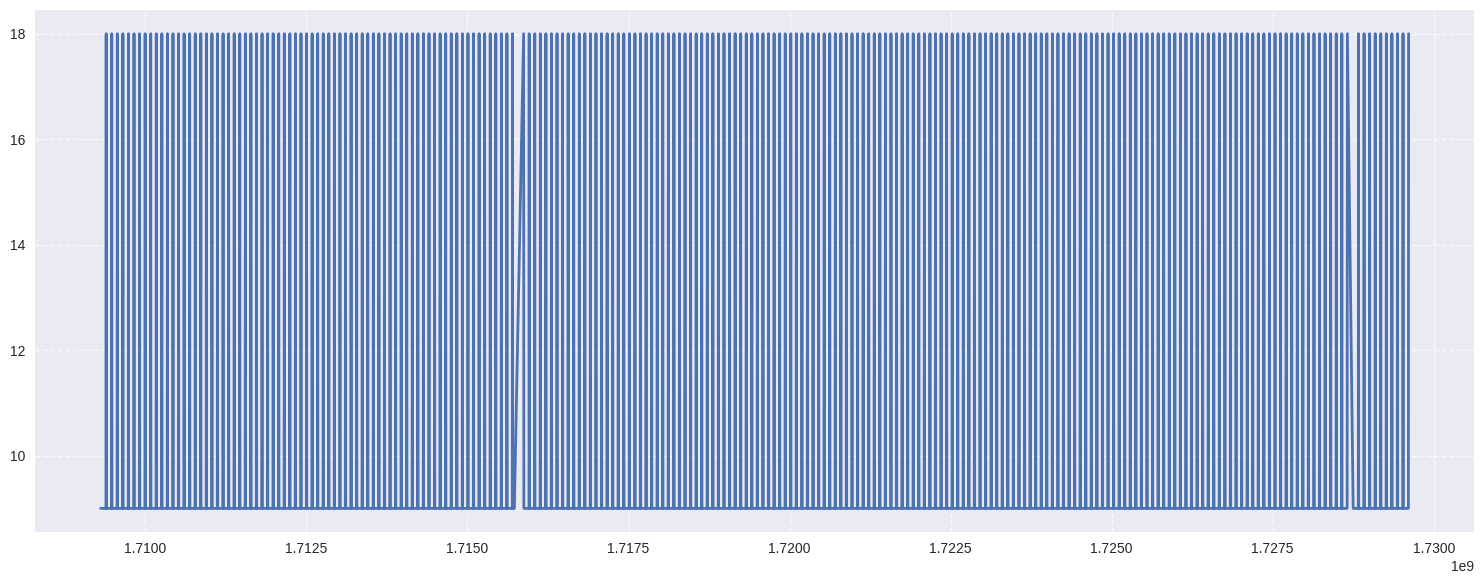

In [257]:
set_date = set()

for i in range (merged_df.shape[0]) :
    set_date.add(merged_df['ts'].iloc[i])
    
# print (set_date)

'''
    병합된 df가 1시간 간격으로 이루어진 것을 확인 가능.
'''

plt.style.use('seaborn')
plt.figure(figsize=(15, 6))
ts_counts = merged_df['ts'].value_counts().sort_index()
plt.plot(ts_counts.index, ts_counts.values, linewidth=2)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

-----

In [241]:
# sliding window (judging by frequency)

from collections import Counter

def split_sequences(sequences, n_steps) :
	X, y = list(), list()
	for i in range(len(sequences)):
    # find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [242]:
# CNN-LSTM

from tensorflow import keras
from tensorflow.keras import layers, regularizers

def build_CNN_LSTM(input_shape, l2_lambda=0.01):
    model = keras.Sequential()

    # Convolutional layers
    model.add(layers.Conv1D(128, kernel_size=4, padding='same', strides=1, activation='relu', 
                            kernel_regularizer=regularizers.l2(l2_lambda)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv1D(64, kernel_size=3, padding='same', strides=1, activation='relu', 
                            kernel_regularizer=regularizers.l2(l2_lambda)))
    model.add(layers.Dropout(0.4))

    # LSTM layers
    model.add(layers.LSTM(64, return_sequences=True))
    model.add(layers.LSTM(32, return_sequences=False))
    model.add(layers.Dropout(0.5))

    # Fully connected layers
    model.add(layers.Dense(100, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda)))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(80, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda)))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(60, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda)))
    model.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda)))

    # Output layer
    model.add(layers.Dense(1))

    return model


In [243]:
from tensorflow.keras import layers, models, regularizers

def build_unet_1d_custom(input_shape, l2_lambda=0.01):

    inputs = layers.Input(shape=input_shape)

    c1 = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same', 
                       kernel_regularizer=regularizers.l2(l2_lambda))(inputs)
    c1 = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same', 
                       kernel_regularizer=regularizers.l2(l2_lambda))(c1)
    p1 = layers.MaxPooling1D(pool_size=2)(c1)

    c2 = layers.Conv1D(32, kernel_size=3, activation='relu', padding='same', 
                       kernel_regularizer=regularizers.l2(l2_lambda))(p1)
    c2 = layers.Conv1D(32, kernel_size=3, activation='relu', padding='same', 
                       kernel_regularizer=regularizers.l2(l2_lambda))(c2)
    p2 = layers.MaxPooling1D(pool_size=2)(c2)

    c3 = layers.Conv1D(16, kernel_size=3, activation='relu', padding='same', 
                       kernel_regularizer=regularizers.l2(l2_lambda))(p2)
    c3 = layers.Conv1D(16, kernel_size=3, activation='relu', padding='same', 
                       kernel_regularizer=regularizers.l2(l2_lambda))(c3)
    p3 = layers.MaxPooling1D(pool_size=2)(c3)

    b1 = layers.Conv1D(16, kernel_size=3, activation='relu', padding='same', 
                       kernel_regularizer=regularizers.l2(l2_lambda))(p3)
    b1 = layers.Conv1D(16, kernel_size=3, activation='relu', padding='same', 
                       kernel_regularizer=regularizers.l2(l2_lambda))(b1)

    gru_bottleneck = layers.GRU(32, return_sequences=True)(b1)

    u3 = layers.Conv1DTranspose(16, kernel_size=2, strides=2, padding='same')(gru_bottleneck)
    c3_shape = layers.Lambda(lambda x: x[:, :u3.shape[1], :])(c3)
    u3 = layers.concatenate([u3, c3_shape], axis=-1)

    c4 = layers.Conv1D(32, kernel_size=3, activation='relu', padding='same')(u3)
    c4 = layers.Conv1D(32, kernel_size=3, activation='relu', padding='same')(c4)

    gru_decoder_1 = layers.GRU(32, return_sequences=True)(c4)

    u4 = layers.Conv1DTranspose(32, kernel_size=2, strides=2, padding='same')(gru_decoder_1)
    c2_shape = layers.Lambda(lambda x: x[:, :u4.shape[1], :])(c2)
    u4 = layers.concatenate([u4, c2_shape], axis=-1)

    c5 = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(u4)
    c5 = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(c5)

    gru_decoder_2 = layers.GRU(64, return_sequences=True)(c5)

    f1 = layers.Flatten()(gru_decoder_2)
    dense1 = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda))(f1)
    outputs = layers.Dense(1)(dense1)

    model = models.Model(inputs=[inputs], outputs=[outputs])

    return model

In [244]:
from tensorflow.keras import layers, models, regularizers
import tensorflow.keras as keras

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.2, l2_lambda=0.02):
    x = keras.layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = keras.layers.Dropout(dropout)(x)
    x = keras.layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    x = keras.layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu",
                           kernel_regularizer=regularizers.l2(l2_lambda))(res)
    x = keras.layers.Dropout(dropout)(x)
    x = keras.layers.Conv1D(filters=inputs.shape[-1], kernel_size=1,
                           kernel_regularizer=regularizers.l2(l2_lambda))(x)
    x = keras.layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

def build_transformer(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0.2,
    mlp_dropout=0.3,
    n_classes=0,
    l2_lambda=0.02,
    use_lstm=True, 
    lstm_units=32
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    
    # Apply Transformer blocks
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout, l2_lambda)

    # If using LSTM, apply it after the transformer layers
    if use_lstm:
        x = layers.LSTM(lstm_units, return_sequences=True)(x)  # Ensure return_sequences=True for GlobalMaxPooling1D

    # Reshape to 3D tensor (batch_size, timesteps, channels) for GlobalMaxPooling1D
    x = layers.Reshape((-1, x.shape[-1]))(x)  # Reshaping before pooling
    
    # Apply GlobalMaxPooling1D
    x = keras.layers.GlobalMaxPooling1D(data_format="channels_first")(x)
    
    # MLP layer
    for dim in mlp_units:
        x = keras.layers.Dense(dim, activation="relu",
                              kernel_regularizer=regularizers.l2(l2_lambda))(x)
        x = keras.layers.Dropout(mlp_dropout)(x)

    # Output layer
    if n_classes > 0:
        outputs = keras.layers.Dense(n_classes, activation="softmax")(x)
    else:  
        outputs = keras.layers.Dense(1)(x)  # For regression

    return keras.Model(inputs, outputs)


In [245]:
# build pipeline to fit

import time
from memory_profiler import profile
from keras.callbacks import Callback

class EpochTimeLogger(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = time.time()  

    def on_epoch_end(self, epoch, logs=None):
        elapsed_time = time.time() - self.start_time  
        print(f"epoch {epoch + 1} completed : {elapsed_time:.2f} seconds", end='\n')

@profile  # to protect memory overflow
def run_all_model(X, y, models, epochs=50):
    histories = {
        'CNN_LSTM' : None,
        'UNet' : None,
        'transformer_encoder' : None
    }
    
    trained_models = {
        'CNN_LSTM' : None,
        'UNet' : None,
        'transformer_encoder' : None
    }
    
#     early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

    for idx, model in enumerate(models) : 
        print (f"model {idx} running")    
        try:
            start_time = time.time()
            history = model.fit(X, y, epochs=epochs, 
                                validation_split=0.2,
                                batch_size=512,
                                callbacks=[EpochTimeLogger()], 
                                verbose=0)
            
            end_time = time.time()
            total_time = end_time - start_time
            avg_time_per_epoch = total_time / epochs
            
            print(f"Total training time: {total_time / 60:.2f} minutes")
            print(f"Average time per epoch: {avg_time_per_epoch:.2f} seconds")
            
            if idx == 0: 
                histories['CNN_LSTM'] = history
                print ("CNN_LSTM completed")
                trained_models['CNN_LSTM'] = model
            elif idx == 1: 
                histories['UNet'] = history
                print ("UNet completed")
                trained_models['UNet'] = model
            else: 
                histories['transformer_encoder'] = history
                print ("transformer_encoder completed")
                trained_models['transformer_encoder'] = model
                
        except Exception as e: 
            print (f"Error occurred while running model {idx}: {e}")
            
        print ()
    
    return histories, trained_models

def activate_all_model(X, y, input_shape, epochs=100):
    CNN_LSTM = build_CNN_LSTM(input_shape=input_shape)
    UNet = build_unet_1d_custom(input_shape=input_shape)
    transformer_encoder = build_transformer(
                                        input_shape=input_shape,
                                        head_size=64,
                                        num_heads=6,
                                        ff_dim=4,
                                        num_transformer_blocks=3,
                                        mlp_units=[32],
                                        dropout=0.2,
                                        mlp_dropout=0.1,
                                        n_classes=0,
                                        l2_lambda=0.02,
                                        use_lstm=True, 
                                        lstm_units=32)
    
    CNN_LSTM.build(input_shape=(None, *input_shape)) 
    UNet.build(input_shape=(None, *input_shape)) 
    transformer_encoder.build(input_shape=(None, *input_shape)) 
    
    print("CNN_LSTM:")
    CNN_LSTM.summary()

    print("UNet:")
    UNet.summary()

    print("Transformer Encoder:")
    transformer_encoder.summary()
    
    CNN_LSTM.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['MSE'], 
                     loss='MSE')
    UNet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['MSE'], 
                 loss='MSE')
    transformer_encoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['MSE'], 
                                loss='MSE')
    
    models = [CNN_LSTM, UNet, transformer_encoder]
    
    CNN_LSTM.build(input_shape=(None, *input_shape))
    UNet.build(input_shape=(None, *input_shape))
    transformer_encoder.build(input_shape=(None, *input_shape))
    
    print(f"CNN_LSTM model parameters: {CNN_LSTM.count_params()}")
    print(f"UNet model parameters: {UNet.count_params()}")
    print(f"Transformer Encoder model parameters: {transformer_encoder.count_params()}")

    histories, trained_models = run_all_model(X, y, models, epochs)
    return histories, trained_models

In [246]:
# no augmentation. train set, test set split

df = merged_df
df['ts'] = df['ts'].astype(np.int64) // 10**9

print (df.shape)

idx = int(df.shape[0]*0.9)

X_train = df.iloc[:idx][[feature_name for feature_name in df.columns if feature_name != 'Real-time Confirmed Price (KRW/kWh)']]
y_train = df.iloc[:idx]['Real-time Confirmed Price (KRW/kWh)']
X_test = df.iloc[idx:][[feature_name for feature_name in df.columns if feature_name != 'Real-time Confirmed Price (KRW/kWh)']]
y_test = df.iloc[idx:]['Real-time Confirmed Price (KRW/kWh)']

X_train.shape, X_test.shape

(52128, 31)


((46915, 30), (5213, 30))

In [247]:
train_set = np.c_[X_train, y_train]
test_set = np.c_[X_test, y_test]

X_train_seq, y_train_seq = split_sequences(train_set, 20) 
print ("train : ", X_train_seq.shape, y_train_seq.shape)

X_test_seq, y_test_seq = split_sequences(test_set, 20) 
print ("test : ", X_test_seq.shape, y_test_seq.shape)

print (len(set(y_train_seq)))
print (len(set(y_test_seq)))

train :  (46896, 20, 30) (46896,)
test :  (5194, 20, 30) (5194,)
2701
394


In [248]:
# compile -> fit -> return histories

input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])
histories_original, trained_models = activate_all_model(X_train_seq, y_train_seq, input_shape)

2024-11-09 07:10:17.518489: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-09 07:10:17.519778: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-09 07:10:17.520687: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

CNN_LSTM:
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_100 (Conv1D)         (None, 20, 128)           15488     
                                                                 
 batch_normalization_5 (Batc  (None, 20, 128)          512       
 hNormalization)                                                 
                                                                 
 conv1d_101 (Conv1D)         (None, 20, 64)            24640     
                                                                 
 dropout_52 (Dropout)        (None, 20, 64)            0         
                                                                 
 lstm_15 (LSTM)              (None, 20, 64)            33024     
                                                                 
 lstm_16 (LSTM)              (None, 32)                12416     
                                            

2024-11-09 07:10:20.316856: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-09 07:10:20.322927: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-09 07:10:20.328728: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

epoch 1 completed : 21.80 seconds
epoch 2 completed : 0.93 seconds
epoch 3 completed : 0.91 seconds
epoch 4 completed : 0.91 seconds
epoch 5 completed : 0.88 seconds
epoch 6 completed : 0.97 seconds
epoch 7 completed : 0.89 seconds
epoch 8 completed : 0.87 seconds
epoch 9 completed : 0.86 seconds
epoch 10 completed : 0.88 seconds
epoch 11 completed : 0.85 seconds
epoch 12 completed : 0.84 seconds
epoch 13 completed : 0.88 seconds
epoch 14 completed : 0.88 seconds
epoch 15 completed : 0.86 seconds
epoch 16 completed : 0.90 seconds
epoch 17 completed : 0.88 seconds
epoch 18 completed : 0.86 seconds
epoch 19 completed : 0.88 seconds
epoch 20 completed : 0.87 seconds
epoch 21 completed : 0.86 seconds
epoch 22 completed : 0.86 seconds
epoch 23 completed : 0.91 seconds
epoch 24 completed : 0.90 seconds
epoch 25 completed : 0.85 seconds
epoch 26 completed : 0.84 seconds
epoch 27 completed : 0.85 seconds
epoch 28 completed : 0.88 seconds
epoch 29 completed : 0.85 seconds
epoch 30 completed : 0

2024-11-09 07:12:10.260680: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-09 07:12:10.266725: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-09 07:12:10.272243: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

epoch 1 completed : 32.57 seconds
epoch 2 completed : 1.15 seconds
epoch 3 completed : 1.16 seconds
epoch 4 completed : 1.20 seconds
epoch 5 completed : 1.17 seconds
epoch 6 completed : 1.18 seconds
epoch 7 completed : 1.17 seconds
epoch 8 completed : 1.20 seconds
epoch 9 completed : 1.16 seconds
epoch 10 completed : 1.15 seconds
epoch 11 completed : 1.14 seconds
epoch 12 completed : 1.18 seconds
epoch 13 completed : 1.19 seconds
epoch 14 completed : 1.15 seconds
epoch 15 completed : 1.15 seconds
epoch 16 completed : 1.16 seconds
epoch 17 completed : 1.18 seconds
epoch 18 completed : 1.20 seconds
epoch 19 completed : 1.17 seconds
epoch 20 completed : 1.16 seconds
epoch 21 completed : 1.16 seconds
epoch 22 completed : 1.17 seconds
epoch 23 completed : 1.15 seconds
epoch 24 completed : 1.15 seconds
epoch 25 completed : 1.18 seconds
epoch 26 completed : 1.16 seconds
epoch 27 completed : 1.17 seconds
epoch 28 completed : 1.14 seconds
epoch 29 completed : 1.15 seconds
epoch 30 completed : 1

2024-11-09 07:14:41.113828: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-09 07:14:41.119796: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-09 07:14:41.125455: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

epoch 1 completed : 30.71 seconds
epoch 2 completed : 1.36 seconds
epoch 3 completed : 1.32 seconds
epoch 4 completed : 1.32 seconds
epoch 5 completed : 1.42 seconds
epoch 6 completed : 1.41 seconds
epoch 7 completed : 1.39 seconds
epoch 8 completed : 1.37 seconds
epoch 9 completed : 1.34 seconds
epoch 10 completed : 1.35 seconds
epoch 11 completed : 1.33 seconds
epoch 12 completed : 1.41 seconds
epoch 13 completed : 1.50 seconds
epoch 14 completed : 1.36 seconds
epoch 15 completed : 1.34 seconds
epoch 16 completed : 1.42 seconds
epoch 17 completed : 1.36 seconds
epoch 18 completed : 1.35 seconds
epoch 19 completed : 1.37 seconds
epoch 20 completed : 1.32 seconds
epoch 21 completed : 1.34 seconds
epoch 22 completed : 1.34 seconds
epoch 23 completed : 1.36 seconds
epoch 24 completed : 1.37 seconds
epoch 25 completed : 1.34 seconds
epoch 26 completed : 1.35 seconds
epoch 27 completed : 1.41 seconds
epoch 28 completed : 1.34 seconds
epoch 29 completed : 1.37 seconds
epoch 30 completed : 1

{'CNN_LSTM': <keras.callbacks.History object at 0x7f3b2d134640>, 'UNet': <keras.callbacks.History object at 0x7f3b07a50ac0>, 'transformer_encoder': <keras.callbacks.History object at 0x7f3b07f0f9a0>}


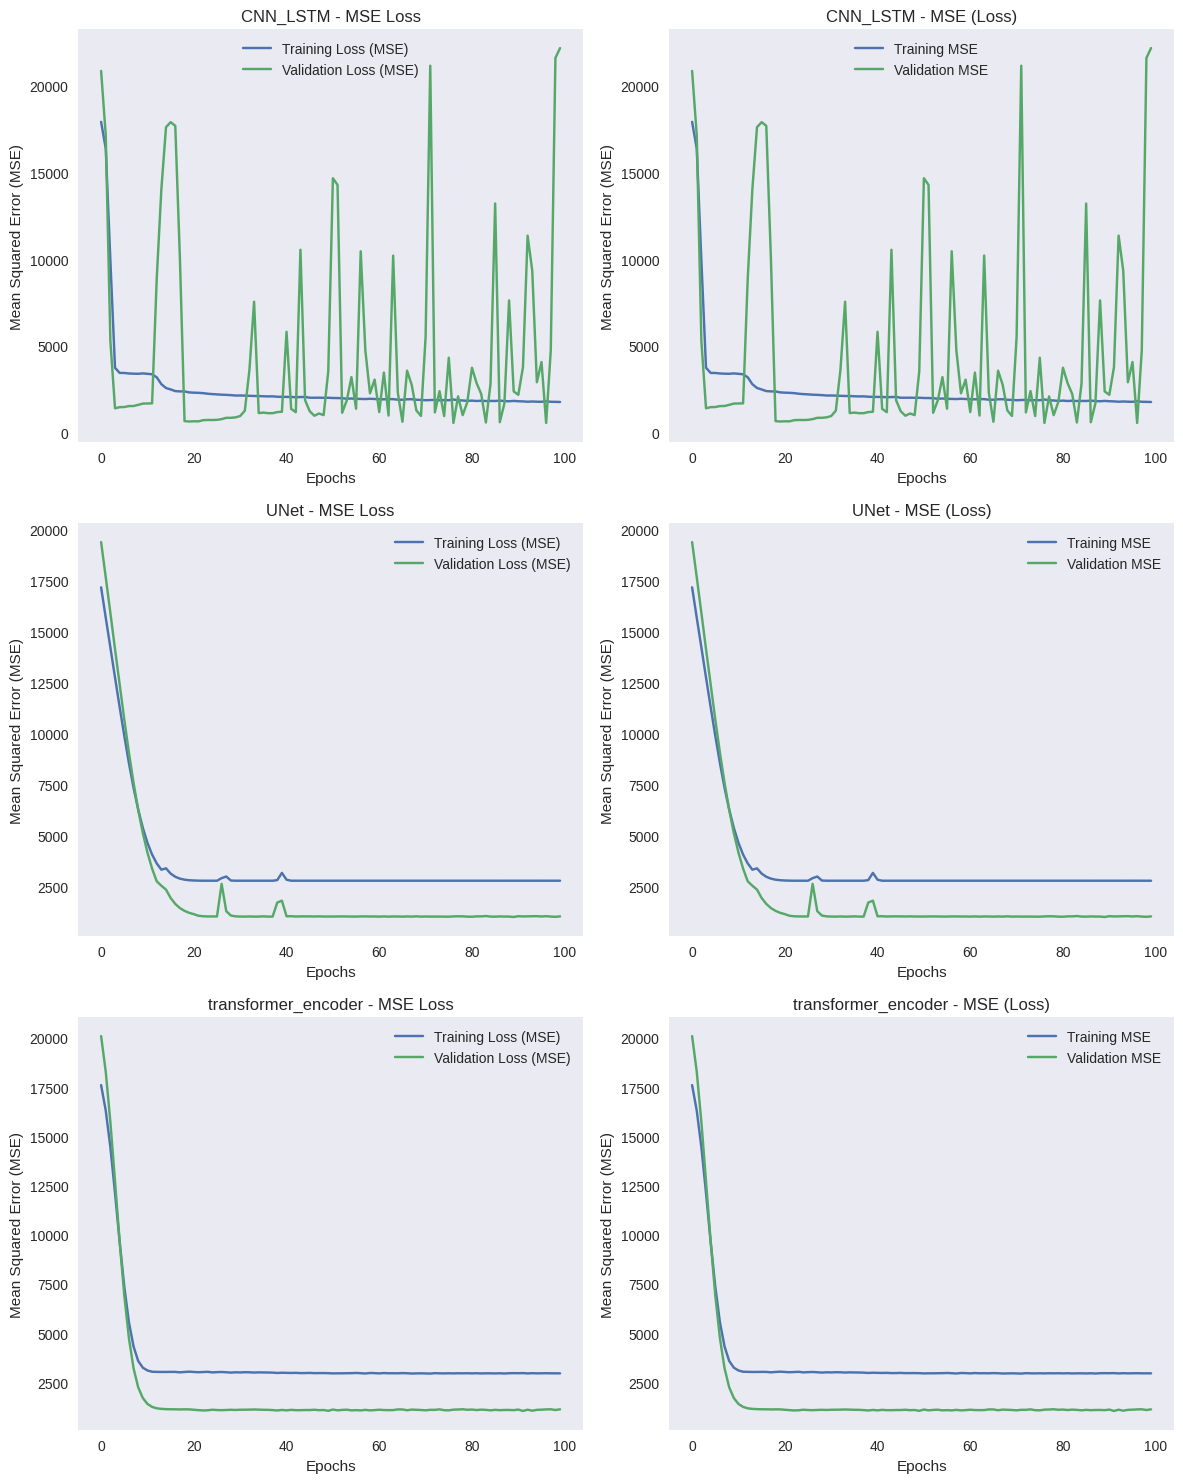

In [253]:
# loss, validation loss, acc, validation acc visualliztion

print (histories_original)

def draw_history_regression_mse(histories):
    num_models = len(histories)
    fig, ax = plt.subplots(num_models, 2, figsize=(12, 5 * num_models))

    for i, (model_name, history) in enumerate(histories.items()):
        # Plot MSE (loss) and Validation MSE (val_loss)
        ax[i, 0].plot(history.history['loss'], label='Training Loss (MSE)')  # Training MSE
        ax[i, 0].plot(history.history['val_loss'], label='Validation Loss (MSE)')  # Validation MSE
        ax[i, 0].set_title(f'{model_name} - MSE Loss')
        ax[i, 0].set_xlabel('Epochs')
        ax[i, 0].set_ylabel('Mean Squared Error (MSE)')
        ax[i, 0].legend()
        ax[i, 0].grid()

        # Plot training MSE and validation MSE using the loss
        ax[i, 1].plot(history.history['loss'], label='Training MSE')
        ax[i, 1].plot(history.history['val_loss'], label='Validation MSE')
        ax[i, 1].set_title(f'{model_name} - MSE (Loss)')
        ax[i, 1].set_xlabel('Epochs')
        ax[i, 1].set_ylabel('Mean Squared Error (MSE)')
        ax[i, 1].legend()
        ax[i, 1].grid()

    plt.tight_layout()
    plt.show()

draw_history_regression_mse(histories_original)


In [254]:
# evaulate

def extract_train_test_scores(models, X_train, y_train, X_test, y_test) :
    scores = {}
    for model_name, model in models.items():
        if model:
            train_score = model.evaluate(X_train, y_train, verbose=0)
            test_score  = model.evaluate(X_test, y_test, verbose=0)
            scores[model_name] = {'train_score': train_score, 'test_score': test_score}
    return scores


evaluation_original = extract_train_test_scores(trained_models, X_train_seq, y_train_seq,
                                                X_test_seq, y_test_seq)
print (evaluation_original)

{'CNN_LSTM': {'train_score': [19459.6484375, 19455.654296875], 'test_score': [15836.697265625, 15832.7021484375]}, 'UNet': {'train_score': [2438.50732421875, 2437.0390625], 'test_score': [772.2060546875, 770.738037109375]}, 'transformer_encoder': {'train_score': [2458.06640625, 2456.2841796875], 'test_score': [762.910400390625, 761.1298828125]}}


In [256]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def extract_performance_metrics_regression(models, X_test, y_test):
    metrics = {}
    for model_name, model in models.items():
        if model:
            # Predicting the target values
            y_pred = model.predict(X_test)
            
            # Calculating regression metrics
            mae = mean_absolute_error(y_test, y_pred)
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)  # Root Mean Squared Error
            r2 = r2_score(y_test, y_pred)  # R-squared score
            
            # Storing the results
            metrics[model_name] = {'mae': mae, 'mse': mse, 'rmse': rmse, 'r2_score': r2}
    
    return metrics

performances_original = extract_performance_metrics_regression(trained_models, X_test_seq, y_test_seq)
print(performances_original)


163/163 [==============================] - 0s 2ms/step


2024-11-09 07:22:06.778049: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-09 07:22:06.779481: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-09 07:22:06.780521: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

163/163 [==============================] - 1s 3ms/step


2024-11-09 07:22:08.340511: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-09 07:22:08.341651: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-09 07:22:08.342803: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

163/163 [==============================] - 1s 3ms/step
{'CNN_LSTM': {'mae': 122.93538802656981, 'mse': 15832.702872047461, 'rmse': 125.82806869712124, 'r2_score': -19.874869661577673}, 'UNet': {'mae': 23.56787278332158, 'mse': 770.7382461411595, 'rmse': 27.762172936230325, 'r2_score': -0.016191648476825193}, 'transformer_encoder': {'mae': 23.406780896926783, 'mse': 761.1298288911755, 'rmse': 27.588581494726682, 'r2_score': -0.00352328355086029}}
